In [187]:
# import and read intial file Michelle has transformed/merged from inpatient/outpatient recods, 
# use NaN for elements with no values
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

df = pd.read_csv("op_comb_ip_final.csv", na_values = ['no info', '.'],low_memory=False)

ParserError: Error tokenizing data. C error: out of memory

In [ ]:
print(df.shape)
df.head()

In [ ]:
df.columns

In [ ]:
df_subset = df[['MEMBER_ID', 'OPDIAG1', 'ip_4280']]

In [ ]:
# drop icd9 codes with letters
#num_df = (df_subset.drop('OPDIAG1', axis=1)
#         .join(df_subset['OPDIAG1'].apply(pd.to_numeric, errors='coerce')))
df1 = df_subset[df_subset.OPDIAG1.str[0] != 'V']
df1 = df1[df1.OPDIAG1.str[0] != 'E']
df1 = df1[df1.OPDIAG1 != 'OTHER']
df1['OPDIAG1'] = pd.to_numeric(df1['OPDIAG1'])

In [ ]:
df_subset = df3
df_subset.head()

In [ ]:
# looking at count of catagorical data
cols = ['OPDIAG1']
for name in cols:
    print(name,':')
    print(df_subset[name].value_counts(),'\n')

In [ ]:
# read in beneficiary file so can merge some features from file (age, race, sex,state)
df_merge = pd.read_csv("combined_ben_sum_AddYear.csv", na_values = ['no info', '.'])
#subset of data to merge
df_merge_subset = df_merge[['DESYNPUF_ID','Year','BENE_BIRTH_DT','BENE_SEX_IDENT_CD','BENE_RACE_CD','SP_STATE_CODE']]
#calculate age (year column - year from BENE_BIRTH_DT)
#newdf["Birth_Year"] = pd.to_datetime(newdf['BENE_BIRTH_DT']).dt.year
df_merge_subset.loc[:,'Age'] = df_merge_subset.loc[:,'Year'] - (pd.to_datetime(df_merge_subset.loc[:,'BENE_BIRTH_DT'],
                                                                             format='%Y%m%d').dt.year)

In [ ]:
# 0 - Male, 1 - Female
df_merge_subset.loc[:,'BENE_RACE_CD'] = df_merge_subset.loc[:,'BENE_RACE_CD'].replace({1:'White',2:'Black',3:'Other', 5:'Hispanic'}).apply(str)
df_merge_subset.loc[:,'BENE_SEX_IDENT_CD'] = df_merge_subset.loc[:,'BENE_SEX_IDENT_CD'].replace({1:0,2:1})
# converting number code to state name
df_merge_subset.loc[:,'SP_STATE_CODE'] = df_merge_subset.loc[:,'SP_STATE_CODE'].replace({
    1:'AL',2:'AK',3:'AZ',4:'AR',5:'CA',6:'CO',7:'CT',8:'DE',9:'DC',10:'FL',11:'GA',12:'HI',
    13:'ID',14:'IL',15:'IN',16:'IA',17:'KS',18:'KY',19:'LA',20:'ME',21:'MD',22:'MA',23:'MI',
    24:'MN',25:'MS',26:'MO',27:'MT',28:'NE',29:'NV',30:'NH',31:'NJ',32:'NM',33:'NY',34:'NC',
    35:'ND',36:'OH',37:'OK',38:'OR',39:'PA',41:'RI',42:'SC',43:'SD',44:'TN',45:'TX',
    46:'UT',47:'VT',49:'VA',50:'WA',51:'WV',52:'WI',53:'WY',54:'Other'})
# convert state to regions (South (S), Northeast (N), Midwest (M), West (W), Other (O))
df_merge_subset.loc[:,'SP_STATE_CODE'] = df_merge_subset.loc[:,'SP_STATE_CODE'].replace({
       'AK': 'O', 'AL': 'S','AR': 'S','AZ': 'W','CA': 'W','CO': 'W','CT': 'N','DC': 'N','DE': 'N',
        'FL': 'S','GA': 'S','HI': 'O','IA': 'M','ID': 'W','IL': 'M','IN': 'M','KS': 'M','KY': 'S',
        'LA': 'S','MA': 'N','MD': 'N','ME': 'N','MI': 'W','MN': 'M','MO': 'M', 'MS': 'S','MT': 'W',
        'NC': 'S','ND': 'M','NE': 'W','NH': 'N','NJ': 'N','NM': 'W','NV': 'W','NY': 'N','OH': 'M',
        'OK': 'S','OR': 'W','PA': 'N','RI': 'N','SC': 'S','SD': 'M','TN': 'S','TX': 'S','UT': 'W',
        'VA': 'S','VT': 'N','WA': 'W','WI': 'M','WV': 'S','WY': 'W', 'Other': 'O'})
df_merge_subset.head()

In [ ]:
#also delete duplicate DESYNPUF_ID before merge
df_merge_subset = df_merge_subset.drop_duplicates(['DESYNPUF_ID'], keep='first')

In [ ]:
# join df_merge_subset with original df so will now have additial features to work with such as age, race, sex, state
# first rename columns to merge on so match
df_merge_subset.rename(columns={'DESYNPUF_ID':'MEMBER_ID'}, inplace = True)
# now merge
df_join = pd.merge(df_subset,
                 df_merge_subset[['MEMBER_ID', 'BENE_SEX_IDENT_CD','SP_STATE_CODE','BENE_RACE_CD','Age']],
                 on='MEMBER_ID')

In [188]:
df_join.head()

,MEMBER_ID,OPDIAG1,ip_4280,BENE_SEX_IDENT_CD,SP_STATE_CODE,BENE_RACE_CD,Age
0,00000B48BCF4AD29,2721,1,1,S,Hispanic,85
1,00000B48BCF4AD29,72999,1,1,S,Hispanic,85
2,00000B48BCF4AD29,7216,1,1,S,Hispanic,85
3,00000B48BCF4AD29,99671,0,1,S,Hispanic,85
4,00000B48BCF4AD29,7916,0,1,S,Hispanic,85


In [189]:
df_model=df_join[['OPDIAG1', 'BENE_SEX_IDENT_CD','SP_STATE_CODE', 'BENE_RACE_CD', 'Age','ip_4280']]

In [190]:
# rename HF label column so no space
df_model.rename(columns={'HF label':'HF_label','BENE_SEX_IDENT_CD':'BENE_SEX'}, inplace = True)
df_model.head(5)

C:\Users\barba\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,OPDIAG1,BENE_SEX,SP_STATE_CODE,BENE_RACE_CD,Age,ip_4280
0,2721,1,S,Hispanic,85,1
1,72999,1,S,Hispanic,85,1
2,7216,1,S,Hispanic,85,1
3,99671,1,S,Hispanic,85,0
4,7916,1,S,Hispanic,85,0


In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
df_model['ip_4280'].value_counts()

0    12244691
1      174496
Name: ip_4280, dtype: int64

Random under-sampling:
1    174496
0    174496
Name: ip_4280, dtype: int64


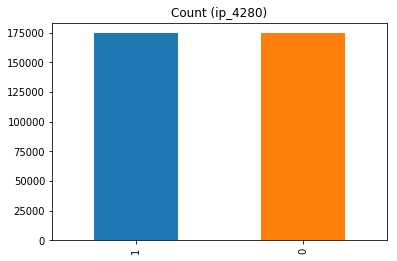

In [194]:
# Class count
count_class_0, count_class_1 = df_model.ip_4280.value_counts()

# Divide by class
df_class_0 = df_model[df_model['ip_4280'] == 0]
df_class_1 = df_model[df_model['ip_4280'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.ip_4280.value_counts())

df_test_under.ip_4280.value_counts().plot(kind='bar', title='Count (ip_4280)');

In [195]:
df_test_under.head()

,OPDIAG1,BENE_SEX,SP_STATE_CODE,BENE_RACE_CD,Age,ip_4280
5005474,28481,0,N,White,86,0
1581199,85173,0,W,White,78,0
10138561,30270,1,S,White,89,0
11762650,1721,1,S,White,61,0
9022329,72811,1,S,White,80,0


In [196]:
# looking at count of catagorical data
cols = ['OPDIAG1', 'BENE_SEX','SP_STATE_CODE', 'BENE_RACE_CD', 'Age','ip_4280']
for name in cols:
    print(name,':')
    print(df_test_under[name].value_counts(),'\n')
df_test_under['OPDIAG1'] = pd.to_numeric(df_test_under['OPDIAG1'])
df_test_under.dtypes

OPDIAG1 :
4019     9171
4011     9156
2722     2256
2724     2208
2720     2177
2723     2114
2721     2112
78651    1910
78650    1839
78659    1831
42789    1631
7802     1587
7925     1558
42760    1553
5854     1550
7851     1540
4272     1536
4271     1518
42761    1516
5853     1514
42769    1511
42731    1506
4279     1499
7850     1499
4270     1487
585      1476
5859     1459
5855     1458
5856     1452
42781    1414
         ... 
75538       1
80031       1
0820        1
74602       1
04101       1
94334       1
94241       1
80484       1
20164       1
07798       1
01132       1
75659       1
80141       1
80142       1
20114       1
64910       1
7535        1
94408       1
9783        1
9033        1
37130       1
7795        1
9490        1
5064        1
37773       1
52401       1
0062        1
05571       1
65500       1
75442       1
Name: OPDIAG1, Length: 9418, dtype: int64 

BENE_SEX :
1    202955
0    146037
Name: BENE_SEX, dtype: int64 

SP_STATE_CODE :
S    13109

OPDIAG1          float64
BENE_SEX           int64
SP_STATE_CODE     object
BENE_RACE_CD      object
Age                int64
ip_4280            int64
dtype: object

In [200]:
#vc = df_test_under.OPDIAG1.value_counts()
#df2 = df_test_under[df_test_under.OPDIAG1.isin(vc.index[vc.values > 40000])].OPDIAG1.value_counts())

SyntaxError: invalid syntax (<ipython-input-200-29d2b33bf96d>, line 2)

In [157]:
import lightgbm as lgb
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

In [158]:
#Binary Encoding Catergorical Variables without Order
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=['SP_STATE_CODE','BENE_RACE_CD'])
df_encoded = encoder.fit_transform(df_test_under)
df_encoded.head()

,OPDIAG1,BENE_SEX,SP_STATE_CODE_0,SP_STATE_CODE_1,SP_STATE_CODE_2,SP_STATE_CODE_3,BENE_RACE_CD_0,BENE_RACE_CD_1,BENE_RACE_CD_2,Age,ip_4280
671984,78079.0,1,0,0,0,1,0,0,1,74,0
10833171,53130.0,1,0,0,1,0,0,0,1,86,0
505593,4661.0,0,0,0,1,0,0,0,1,76,0
8435380,4011.0,1,0,0,1,1,0,0,1,66,0
8884438,1750.0,1,0,0,1,1,0,0,1,67,0


In [159]:
# split data for test/train
X = df_encoded.drop(['ip_4280'], axis=1)
y = df_encoded['ip_4280']
#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

In [160]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 70)
param_grid = {
    'n_estimators': [x for x in range(20, 100, 4)],
    'learning_rate': [0.05, 0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

C:\Users\barba\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's l1: 0.499533	valid_0's binary_logloss: 0.69224	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499093	valid_0's binary_logloss: 0.691431	valid_0's auc: 0.569695
[3]	valid_0's l1: 0.498669	valid_0's binary_logloss: 0.690692	valid_0's auc: 0.571002
[4]	valid_0's l1: 0.498249	valid_0's binary_logloss: 0.68999	valid_0's auc: 0.571933
[5]	valid_0's l1: 0.497876	valid_0's binary_logloss: 0.689408	valid_0's auc: 0.571848
[6]	valid_0's l1: 0.497489	valid_0's binary_logloss: 0.688822	valid_0's auc: 0.572555
[7]	valid_0's l1: 0.497162	valid_0's binary_logloss: 0.688351	valid_0's auc: 0.572987
[8]	valid_0's l1: 0.496849	valid_0's binary_logloss: 0.687917	valid_0's auc: 0.573504
[9]	valid_0's l1: 0.496544	valid_0's binary_logloss: 0.68752	valid_0's auc: 0.573525
[10]	valid_0's l1: 0.496267	valid_0's binary_logloss: 0.687172	valid_0's auc: 0.573716
[11]	valid_0's l1: 0.49601	valid_0's binary_logloss: 0.686869	valid_0's auc: 0.57

[8]	valid_0's l1: 0.497054	valid_0's binary_logloss: 0.688203	valid_0's auc: 0.573903
[9]	valid_0's l1: 0.496751	valid_0's binary_logloss: 0.687804	valid_0's auc: 0.573763
[10]	valid_0's l1: 0.496555	valid_0's binary_logloss: 0.687555	valid_0's auc: 0.574004
[11]	valid_0's l1: 0.496289	valid_0's binary_logloss: 0.687227	valid_0's auc: 0.574092
[12]	valid_0's l1: 0.496054	valid_0's binary_logloss: 0.686921	valid_0's auc: 0.574941
[13]	valid_0's l1: 0.495826	valid_0's binary_logloss: 0.686641	valid_0's auc: 0.575439
[14]	valid_0's l1: 0.495606	valid_0's binary_logloss: 0.686387	valid_0's auc: 0.575558
[15]	valid_0's l1: 0.495404	valid_0's binary_logloss: 0.686167	valid_0's auc: 0.575738
[16]	valid_0's l1: 0.495156	valid_0's binary_logloss: 0.685891	valid_0's auc: 0.576203
[17]	valid_0's l1: 0.494967	valid_0's binary_logloss: 0.685698	valid_0's auc: 0.576309
[18]	valid_0's l1: 0.494793	valid_0's binary_logloss: 0.6855	valid_0's auc: 0.576808
[19]	valid_0's l1: 0.494632	valid_0's binary_lo

[22]	valid_0's l1: 0.494129	valid_0's binary_logloss: 0.684846	valid_0's auc: 0.577805
[23]	valid_0's l1: 0.494012	valid_0's binary_logloss: 0.684756	valid_0's auc: 0.577802
[24]	valid_0's l1: 0.493894	valid_0's binary_logloss: 0.684649	valid_0's auc: 0.577853
[25]	valid_0's l1: 0.493751	valid_0's binary_logloss: 0.684495	valid_0's auc: 0.578233
[26]	valid_0's l1: 0.493587	valid_0's binary_logloss: 0.68435	valid_0's auc: 0.578366
[27]	valid_0's l1: 0.493496	valid_0's binary_logloss: 0.684263	valid_0's auc: 0.578604
[28]	valid_0's l1: 0.493404	valid_0's binary_logloss: 0.684182	valid_0's auc: 0.578682
Did not meet early stopping. Best iteration is:
[28]	valid_0's l1: 0.493404	valid_0's binary_logloss: 0.684182	valid_0's auc: 0.578682
[1]	valid_0's l1: 0.499514	valid_0's binary_logloss: 0.692204	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499042	valid_0's binary_logloss: 0.691335	valid_0's auc: 0.572349
[3]	valid_0's l1: 0.4986

[25]	valid_0's l1: 0.493751	valid_0's binary_logloss: 0.684495	valid_0's auc: 0.578233
[26]	valid_0's l1: 0.493587	valid_0's binary_logloss: 0.68435	valid_0's auc: 0.578366
[27]	valid_0's l1: 0.493496	valid_0's binary_logloss: 0.684263	valid_0's auc: 0.578604
[28]	valid_0's l1: 0.493404	valid_0's binary_logloss: 0.684182	valid_0's auc: 0.578682
[29]	valid_0's l1: 0.493285	valid_0's binary_logloss: 0.684053	valid_0's auc: 0.579068
[30]	valid_0's l1: 0.493121	valid_0's binary_logloss: 0.683931	valid_0's auc: 0.579121
[31]	valid_0's l1: 0.493062	valid_0's binary_logloss: 0.683889	valid_0's auc: 0.579195
[32]	valid_0's l1: 0.492916	valid_0's binary_logloss: 0.683782	valid_0's auc: 0.579329
Did not meet early stopping. Best iteration is:
[32]	valid_0's l1: 0.492916	valid_0's binary_logloss: 0.683782	valid_0's auc: 0.579329
[1]	valid_0's l1: 0.499514	valid_0's binary_logloss: 0.692204	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499

[16]	valid_0's l1: 0.495156	valid_0's binary_logloss: 0.685891	valid_0's auc: 0.576203
[17]	valid_0's l1: 0.494967	valid_0's binary_logloss: 0.685698	valid_0's auc: 0.576309
[18]	valid_0's l1: 0.494793	valid_0's binary_logloss: 0.6855	valid_0's auc: 0.576808
[19]	valid_0's l1: 0.494632	valid_0's binary_logloss: 0.685324	valid_0's auc: 0.577307
[20]	valid_0's l1: 0.494411	valid_0's binary_logloss: 0.685107	valid_0's auc: 0.577503
[21]	valid_0's l1: 0.494275	valid_0's binary_logloss: 0.68499	valid_0's auc: 0.577607
[22]	valid_0's l1: 0.494129	valid_0's binary_logloss: 0.684846	valid_0's auc: 0.577805
[23]	valid_0's l1: 0.494012	valid_0's binary_logloss: 0.684756	valid_0's auc: 0.577802
[24]	valid_0's l1: 0.493894	valid_0's binary_logloss: 0.684649	valid_0's auc: 0.577853
[25]	valid_0's l1: 0.493751	valid_0's binary_logloss: 0.684495	valid_0's auc: 0.578233
[26]	valid_0's l1: 0.493587	valid_0's binary_logloss: 0.68435	valid_0's auc: 0.578366
[27]	valid_0's l1: 0.493496	valid_0's binary_lo

[1]	valid_0's l1: 0.49953	valid_0's binary_logloss: 0.692234	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499077	valid_0's binary_logloss: 0.691403	valid_0's auc: 0.569805
[3]	valid_0's l1: 0.498658	valid_0's binary_logloss: 0.690668	valid_0's auc: 0.571966
[4]	valid_0's l1: 0.498262	valid_0's binary_logloss: 0.690013	valid_0's auc: 0.57238
[5]	valid_0's l1: 0.497894	valid_0's binary_logloss: 0.689433	valid_0's auc: 0.572447
[6]	valid_0's l1: 0.497557	valid_0's binary_logloss: 0.688931	valid_0's auc: 0.572659
[7]	valid_0's l1: 0.497239	valid_0's binary_logloss: 0.688478	valid_0's auc: 0.572547
[8]	valid_0's l1: 0.497054	valid_0's binary_logloss: 0.688203	valid_0's auc: 0.573903
[9]	valid_0's l1: 0.496751	valid_0's binary_logloss: 0.687804	valid_0's auc: 0.573763
[10]	valid_0's l1: 0.496555	valid_0's binary_logloss: 0.687555	valid_0's auc: 0.574004
[11]	valid_0's l1: 0.496289	valid_0's binary_logloss: 0.687227	valid_0's auc: 0.

[17]	valid_0's l1: 0.494791	valid_0's binary_logloss: 0.685434	valid_0's auc: 0.576947
[18]	valid_0's l1: 0.494618	valid_0's binary_logloss: 0.685248	valid_0's auc: 0.577343
[19]	valid_0's l1: 0.494514	valid_0's binary_logloss: 0.685127	valid_0's auc: 0.577762
[20]	valid_0's l1: 0.494325	valid_0's binary_logloss: 0.68494	valid_0's auc: 0.578114
[21]	valid_0's l1: 0.494128	valid_0's binary_logloss: 0.684755	valid_0's auc: 0.578179
[22]	valid_0's l1: 0.494032	valid_0's binary_logloss: 0.68465	valid_0's auc: 0.578526
[23]	valid_0's l1: 0.493895	valid_0's binary_logloss: 0.684496	valid_0's auc: 0.578968
[24]	valid_0's l1: 0.493761	valid_0's binary_logloss: 0.68436	valid_0's auc: 0.579216
[25]	valid_0's l1: 0.493572	valid_0's binary_logloss: 0.684199	valid_0's auc: 0.579259
[26]	valid_0's l1: 0.493479	valid_0's binary_logloss: 0.68411	valid_0's auc: 0.579514
[27]	valid_0's l1: 0.49338	valid_0's binary_logloss: 0.683986	valid_0's auc: 0.579899
[28]	valid_0's l1: 0.493247	valid_0's binary_log

[27]	valid_0's l1: 0.493386	valid_0's binary_logloss: 0.684047	valid_0's auc: 0.579185
[28]	valid_0's l1: 0.493185	valid_0's binary_logloss: 0.683881	valid_0's auc: 0.579339
[29]	valid_0's l1: 0.493063	valid_0's binary_logloss: 0.683794	valid_0's auc: 0.579331
[30]	valid_0's l1: 0.492979	valid_0's binary_logloss: 0.683694	valid_0's auc: 0.57979
[31]	valid_0's l1: 0.492802	valid_0's binary_logloss: 0.683535	valid_0's auc: 0.580006
[32]	valid_0's l1: 0.492686	valid_0's binary_logloss: 0.683439	valid_0's auc: 0.580201
[33]	valid_0's l1: 0.492507	valid_0's binary_logloss: 0.683288	valid_0's auc: 0.580373
[34]	valid_0's l1: 0.492414	valid_0's binary_logloss: 0.683228	valid_0's auc: 0.580414
[35]	valid_0's l1: 0.492242	valid_0's binary_logloss: 0.683089	valid_0's auc: 0.580602
[36]	valid_0's l1: 0.492148	valid_0's binary_logloss: 0.683025	valid_0's auc: 0.580769
[37]	valid_0's l1: 0.49208	valid_0's binary_logloss: 0.682944	valid_0's auc: 0.581111
[38]	valid_0's l1: 0.491946	valid_0's binary_

[28]	valid_0's l1: 0.493404	valid_0's binary_logloss: 0.684182	valid_0's auc: 0.578682
[29]	valid_0's l1: 0.493285	valid_0's binary_logloss: 0.684053	valid_0's auc: 0.579068
[30]	valid_0's l1: 0.493121	valid_0's binary_logloss: 0.683931	valid_0's auc: 0.579121
[31]	valid_0's l1: 0.493062	valid_0's binary_logloss: 0.683889	valid_0's auc: 0.579195
[32]	valid_0's l1: 0.492916	valid_0's binary_logloss: 0.683782	valid_0's auc: 0.579329
[33]	valid_0's l1: 0.492745	valid_0's binary_logloss: 0.683619	valid_0's auc: 0.579683
[34]	valid_0's l1: 0.492651	valid_0's binary_logloss: 0.68356	valid_0's auc: 0.579702
[35]	valid_0's l1: 0.492549	valid_0's binary_logloss: 0.683481	valid_0's auc: 0.579847
[36]	valid_0's l1: 0.492422	valid_0's binary_logloss: 0.683389	valid_0's auc: 0.579927
[37]	valid_0's l1: 0.492353	valid_0's binary_logloss: 0.683324	valid_0's auc: 0.580095
[38]	valid_0's l1: 0.492239	valid_0's binary_logloss: 0.683247	valid_0's auc: 0.580249
[39]	valid_0's l1: 0.492093	valid_0's binary

[27]	valid_0's l1: 0.49338	valid_0's binary_logloss: 0.683986	valid_0's auc: 0.579899
[28]	valid_0's l1: 0.493247	valid_0's binary_logloss: 0.683869	valid_0's auc: 0.580079
[29]	valid_0's l1: 0.493096	valid_0's binary_logloss: 0.683752	valid_0's auc: 0.580192
[30]	valid_0's l1: 0.492956	valid_0's binary_logloss: 0.683611	valid_0's auc: 0.580629
[31]	valid_0's l1: 0.492848	valid_0's binary_logloss: 0.683511	valid_0's auc: 0.580787
[32]	valid_0's l1: 0.492737	valid_0's binary_logloss: 0.683377	valid_0's auc: 0.581349
[33]	valid_0's l1: 0.492546	valid_0's binary_logloss: 0.683209	valid_0's auc: 0.581727
[34]	valid_0's l1: 0.492417	valid_0's binary_logloss: 0.683115	valid_0's auc: 0.581839
[35]	valid_0's l1: 0.492262	valid_0's binary_logloss: 0.683001	valid_0's auc: 0.581958
[36]	valid_0's l1: 0.492156	valid_0's binary_logloss: 0.682911	valid_0's auc: 0.582157
[37]	valid_0's l1: 0.492013	valid_0's binary_logloss: 0.682805	valid_0's auc: 0.582361
[38]	valid_0's l1: 0.491929	valid_0's binary

[19]	valid_0's l1: 0.494483	valid_0's binary_logloss: 0.685076	valid_0's auc: 0.577707
[20]	valid_0's l1: 0.494363	valid_0's binary_logloss: 0.684944	valid_0's auc: 0.577994
[21]	valid_0's l1: 0.494245	valid_0's binary_logloss: 0.684839	valid_0's auc: 0.578142
[22]	valid_0's l1: 0.494014	valid_0's binary_logloss: 0.684621	valid_0's auc: 0.57826
[23]	valid_0's l1: 0.493909	valid_0's binary_logloss: 0.684513	valid_0's auc: 0.57852
[24]	valid_0's l1: 0.493804	valid_0's binary_logloss: 0.684402	valid_0's auc: 0.578767
[25]	valid_0's l1: 0.493623	valid_0's binary_logloss: 0.68425	valid_0's auc: 0.578875
[26]	valid_0's l1: 0.493535	valid_0's binary_logloss: 0.684175	valid_0's auc: 0.57904
[27]	valid_0's l1: 0.493386	valid_0's binary_logloss: 0.684047	valid_0's auc: 0.579185
[28]	valid_0's l1: 0.493185	valid_0's binary_logloss: 0.683881	valid_0's auc: 0.579339
[29]	valid_0's l1: 0.493063	valid_0's binary_logloss: 0.683794	valid_0's auc: 0.579331
[30]	valid_0's l1: 0.492979	valid_0's binary_lo

[8]	valid_0's l1: 0.497054	valid_0's binary_logloss: 0.688203	valid_0's auc: 0.573903
[9]	valid_0's l1: 0.496751	valid_0's binary_logloss: 0.687804	valid_0's auc: 0.573763
[10]	valid_0's l1: 0.496555	valid_0's binary_logloss: 0.687555	valid_0's auc: 0.574004
[11]	valid_0's l1: 0.496289	valid_0's binary_logloss: 0.687227	valid_0's auc: 0.574092
[12]	valid_0's l1: 0.496054	valid_0's binary_logloss: 0.686921	valid_0's auc: 0.574941
[13]	valid_0's l1: 0.495826	valid_0's binary_logloss: 0.686641	valid_0's auc: 0.575439
[14]	valid_0's l1: 0.495606	valid_0's binary_logloss: 0.686387	valid_0's auc: 0.575558
[15]	valid_0's l1: 0.495404	valid_0's binary_logloss: 0.686167	valid_0's auc: 0.575738
[16]	valid_0's l1: 0.495156	valid_0's binary_logloss: 0.685891	valid_0's auc: 0.576203
[17]	valid_0's l1: 0.494967	valid_0's binary_logloss: 0.685698	valid_0's auc: 0.576309
[18]	valid_0's l1: 0.494793	valid_0's binary_logloss: 0.6855	valid_0's auc: 0.576808
[19]	valid_0's l1: 0.494632	valid_0's binary_lo

[47]	valid_0's l1: 0.491065	valid_0's binary_logloss: 0.68215	valid_0's auc: 0.582794
[48]	valid_0's l1: 0.490992	valid_0's binary_logloss: 0.68205	valid_0's auc: 0.583235
[49]	valid_0's l1: 0.49086	valid_0's binary_logloss: 0.681967	valid_0's auc: 0.583347
[50]	valid_0's l1: 0.490783	valid_0's binary_logloss: 0.681869	valid_0's auc: 0.583739
[51]	valid_0's l1: 0.490688	valid_0's binary_logloss: 0.681813	valid_0's auc: 0.583813
[52]	valid_0's l1: 0.490623	valid_0's binary_logloss: 0.681732	valid_0's auc: 0.584122
[53]	valid_0's l1: 0.490532	valid_0's binary_logloss: 0.681691	valid_0's auc: 0.584111
[54]	valid_0's l1: 0.490481	valid_0's binary_logloss: 0.681636	valid_0's auc: 0.584286
[55]	valid_0's l1: 0.49039	valid_0's binary_logloss: 0.681601	valid_0's auc: 0.5843
[56]	valid_0's l1: 0.490344	valid_0's binary_logloss: 0.681561	valid_0's auc: 0.584434
Did not meet early stopping. Best iteration is:
[56]	valid_0's l1: 0.490344	valid_0's binary_logloss: 0.681561	valid_0's auc: 0.584434
[

[27]	valid_0's l1: 0.493496	valid_0's binary_logloss: 0.684263	valid_0's auc: 0.578604
[28]	valid_0's l1: 0.493404	valid_0's binary_logloss: 0.684182	valid_0's auc: 0.578682
[29]	valid_0's l1: 0.493285	valid_0's binary_logloss: 0.684053	valid_0's auc: 0.579068
[30]	valid_0's l1: 0.493121	valid_0's binary_logloss: 0.683931	valid_0's auc: 0.579121
[31]	valid_0's l1: 0.493062	valid_0's binary_logloss: 0.683889	valid_0's auc: 0.579195
[32]	valid_0's l1: 0.492916	valid_0's binary_logloss: 0.683782	valid_0's auc: 0.579329
[33]	valid_0's l1: 0.492745	valid_0's binary_logloss: 0.683619	valid_0's auc: 0.579683
[34]	valid_0's l1: 0.492651	valid_0's binary_logloss: 0.68356	valid_0's auc: 0.579702
[35]	valid_0's l1: 0.492549	valid_0's binary_logloss: 0.683481	valid_0's auc: 0.579847
[36]	valid_0's l1: 0.492422	valid_0's binary_logloss: 0.683389	valid_0's auc: 0.579927
[37]	valid_0's l1: 0.492353	valid_0's binary_logloss: 0.683324	valid_0's auc: 0.580095
[38]	valid_0's l1: 0.492239	valid_0's binary

[1]	valid_0's l1: 0.499533	valid_0's binary_logloss: 0.69224	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499093	valid_0's binary_logloss: 0.691431	valid_0's auc: 0.569695
[3]	valid_0's l1: 0.498669	valid_0's binary_logloss: 0.690692	valid_0's auc: 0.571002
[4]	valid_0's l1: 0.498249	valid_0's binary_logloss: 0.68999	valid_0's auc: 0.571933
[5]	valid_0's l1: 0.497876	valid_0's binary_logloss: 0.689408	valid_0's auc: 0.571848
[6]	valid_0's l1: 0.497489	valid_0's binary_logloss: 0.688822	valid_0's auc: 0.572555
[7]	valid_0's l1: 0.497162	valid_0's binary_logloss: 0.688351	valid_0's auc: 0.572987
[8]	valid_0's l1: 0.496849	valid_0's binary_logloss: 0.687917	valid_0's auc: 0.573504
[9]	valid_0's l1: 0.496544	valid_0's binary_logloss: 0.68752	valid_0's auc: 0.573525
[10]	valid_0's l1: 0.496267	valid_0's binary_logloss: 0.687172	valid_0's auc: 0.573716
[11]	valid_0's l1: 0.49601	valid_0's binary_logloss: 0.686869	valid_0's auc: 0.57

[34]	valid_0's l1: 0.492651	valid_0's binary_logloss: 0.68356	valid_0's auc: 0.579702
[35]	valid_0's l1: 0.492549	valid_0's binary_logloss: 0.683481	valid_0's auc: 0.579847
[36]	valid_0's l1: 0.492422	valid_0's binary_logloss: 0.683389	valid_0's auc: 0.579927
[37]	valid_0's l1: 0.492353	valid_0's binary_logloss: 0.683324	valid_0's auc: 0.580095
[38]	valid_0's l1: 0.492239	valid_0's binary_logloss: 0.683247	valid_0's auc: 0.580249
[39]	valid_0's l1: 0.492093	valid_0's binary_logloss: 0.683142	valid_0's auc: 0.58032
[40]	valid_0's l1: 0.49198	valid_0's binary_logloss: 0.683057	valid_0's auc: 0.580408
[41]	valid_0's l1: 0.491922	valid_0's binary_logloss: 0.682986	valid_0's auc: 0.580719
[42]	valid_0's l1: 0.4918	valid_0's binary_logloss: 0.68291	valid_0's auc: 0.580784
[43]	valid_0's l1: 0.491651	valid_0's binary_logloss: 0.682801	valid_0's auc: 0.581011
[44]	valid_0's l1: 0.491549	valid_0's binary_logloss: 0.682744	valid_0's auc: 0.581041
[45]	valid_0's l1: 0.491485	valid_0's binary_logl

[1]	valid_0's l1: 0.499533	valid_0's binary_logloss: 0.69224	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499093	valid_0's binary_logloss: 0.691431	valid_0's auc: 0.569695
[3]	valid_0's l1: 0.498669	valid_0's binary_logloss: 0.690692	valid_0's auc: 0.571002
[4]	valid_0's l1: 0.498249	valid_0's binary_logloss: 0.68999	valid_0's auc: 0.571933
[5]	valid_0's l1: 0.497876	valid_0's binary_logloss: 0.689408	valid_0's auc: 0.571848
[6]	valid_0's l1: 0.497489	valid_0's binary_logloss: 0.688822	valid_0's auc: 0.572555
[7]	valid_0's l1: 0.497162	valid_0's binary_logloss: 0.688351	valid_0's auc: 0.572987
[8]	valid_0's l1: 0.496849	valid_0's binary_logloss: 0.687917	valid_0's auc: 0.573504
[9]	valid_0's l1: 0.496544	valid_0's binary_logloss: 0.68752	valid_0's auc: 0.573525
[10]	valid_0's l1: 0.496267	valid_0's binary_logloss: 0.687172	valid_0's auc: 0.573716
[11]	valid_0's l1: 0.49601	valid_0's binary_logloss: 0.686869	valid_0's auc: 0.57

[30]	valid_0's l1: 0.493121	valid_0's binary_logloss: 0.683931	valid_0's auc: 0.579121
[31]	valid_0's l1: 0.493062	valid_0's binary_logloss: 0.683889	valid_0's auc: 0.579195
[32]	valid_0's l1: 0.492916	valid_0's binary_logloss: 0.683782	valid_0's auc: 0.579329
[33]	valid_0's l1: 0.492745	valid_0's binary_logloss: 0.683619	valid_0's auc: 0.579683
[34]	valid_0's l1: 0.492651	valid_0's binary_logloss: 0.68356	valid_0's auc: 0.579702
[35]	valid_0's l1: 0.492549	valid_0's binary_logloss: 0.683481	valid_0's auc: 0.579847
[36]	valid_0's l1: 0.492422	valid_0's binary_logloss: 0.683389	valid_0's auc: 0.579927
[37]	valid_0's l1: 0.492353	valid_0's binary_logloss: 0.683324	valid_0's auc: 0.580095
[38]	valid_0's l1: 0.492239	valid_0's binary_logloss: 0.683247	valid_0's auc: 0.580249
[39]	valid_0's l1: 0.492093	valid_0's binary_logloss: 0.683142	valid_0's auc: 0.58032
[40]	valid_0's l1: 0.49198	valid_0's binary_logloss: 0.683057	valid_0's auc: 0.580408
[41]	valid_0's l1: 0.491922	valid_0's binary_l

[60]	valid_0's l1: 0.49009	valid_0's binary_logloss: 0.681358	valid_0's auc: 0.585078
[61]	valid_0's l1: 0.490021	valid_0's binary_logloss: 0.681342	valid_0's auc: 0.585019
[62]	valid_0's l1: 0.489975	valid_0's binary_logloss: 0.681306	valid_0's auc: 0.585122
[63]	valid_0's l1: 0.489944	valid_0's binary_logloss: 0.681289	valid_0's auc: 0.585144
[64]	valid_0's l1: 0.489896	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.585194
[65]	valid_0's l1: 0.489849	valid_0's binary_logloss: 0.681196	valid_0's auc: 0.585512
[66]	valid_0's l1: 0.48981	valid_0's binary_logloss: 0.681185	valid_0's auc: 0.58552
[67]	valid_0's l1: 0.489771	valid_0's binary_logloss: 0.681159	valid_0's auc: 0.585591
[68]	valid_0's l1: 0.489687	valid_0's binary_logloss: 0.681125	valid_0's auc: 0.585631
Did not meet early stopping. Best iteration is:
[68]	valid_0's l1: 0.489687	valid_0's binary_logloss: 0.681125	valid_0's auc: 0.585631
[1]	valid_0's l1: 0.499533	valid_0's binary_logloss: 0.69224	valid_0's auc: 0.569864


[17]	valid_0's l1: 0.494967	valid_0's binary_logloss: 0.685698	valid_0's auc: 0.576309
[18]	valid_0's l1: 0.494793	valid_0's binary_logloss: 0.6855	valid_0's auc: 0.576808
[19]	valid_0's l1: 0.494632	valid_0's binary_logloss: 0.685324	valid_0's auc: 0.577307
[20]	valid_0's l1: 0.494411	valid_0's binary_logloss: 0.685107	valid_0's auc: 0.577503
[21]	valid_0's l1: 0.494275	valid_0's binary_logloss: 0.68499	valid_0's auc: 0.577607
[22]	valid_0's l1: 0.494129	valid_0's binary_logloss: 0.684846	valid_0's auc: 0.577805
[23]	valid_0's l1: 0.494012	valid_0's binary_logloss: 0.684756	valid_0's auc: 0.577802
[24]	valid_0's l1: 0.493894	valid_0's binary_logloss: 0.684649	valid_0's auc: 0.577853
[25]	valid_0's l1: 0.493751	valid_0's binary_logloss: 0.684495	valid_0's auc: 0.578233
[26]	valid_0's l1: 0.493587	valid_0's binary_logloss: 0.68435	valid_0's auc: 0.578366
[27]	valid_0's l1: 0.493496	valid_0's binary_logloss: 0.684263	valid_0's auc: 0.578604
[28]	valid_0's l1: 0.493404	valid_0's binary_lo

[44]	valid_0's l1: 0.491355	valid_0's binary_logloss: 0.682351	valid_0's auc: 0.582563
[45]	valid_0's l1: 0.491293	valid_0's binary_logloss: 0.682285	valid_0's auc: 0.582727
[46]	valid_0's l1: 0.491158	valid_0's binary_logloss: 0.682199	valid_0's auc: 0.582818
[47]	valid_0's l1: 0.491065	valid_0's binary_logloss: 0.68215	valid_0's auc: 0.582794
[48]	valid_0's l1: 0.490992	valid_0's binary_logloss: 0.68205	valid_0's auc: 0.583235
[49]	valid_0's l1: 0.49086	valid_0's binary_logloss: 0.681967	valid_0's auc: 0.583347
[50]	valid_0's l1: 0.490783	valid_0's binary_logloss: 0.681869	valid_0's auc: 0.583739
[51]	valid_0's l1: 0.490688	valid_0's binary_logloss: 0.681813	valid_0's auc: 0.583813
[52]	valid_0's l1: 0.490623	valid_0's binary_logloss: 0.681732	valid_0's auc: 0.584122
[53]	valid_0's l1: 0.490532	valid_0's binary_logloss: 0.681691	valid_0's auc: 0.584111
[54]	valid_0's l1: 0.490481	valid_0's binary_logloss: 0.681636	valid_0's auc: 0.584286
[55]	valid_0's l1: 0.49039	valid_0's binary_lo

[71]	valid_0's l1: 0.489505	valid_0's binary_logloss: 0.680805	valid_0's auc: 0.587571
[72]	valid_0's l1: 0.489463	valid_0's binary_logloss: 0.680757	valid_0's auc: 0.587772
[73]	valid_0's l1: 0.48944	valid_0's binary_logloss: 0.680742	valid_0's auc: 0.587772
[74]	valid_0's l1: 0.489385	valid_0's binary_logloss: 0.680719	valid_0's auc: 0.58776
[75]	valid_0's l1: 0.489348	valid_0's binary_logloss: 0.680678	valid_0's auc: 0.587882
[76]	valid_0's l1: 0.48931	valid_0's binary_logloss: 0.680635	valid_0's auc: 0.588012
Did not meet early stopping. Best iteration is:
[76]	valid_0's l1: 0.48931	valid_0's binary_logloss: 0.680635	valid_0's auc: 0.588012
[1]	valid_0's l1: 0.49953	valid_0's binary_logloss: 0.692234	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499077	valid_0's binary_logloss: 0.691403	valid_0's auc: 0.569805
[3]	valid_0's l1: 0.498658	valid_0's binary_logloss: 0.690668	valid_0's auc: 0.571966
[4]	valid_0's l1: 0.498262	va

[10]	valid_0's l1: 0.496263	valid_0's binary_logloss: 0.68712	valid_0's auc: 0.575233
[11]	valid_0's l1: 0.496023	valid_0's binary_logloss: 0.686801	valid_0's auc: 0.575997
[12]	valid_0's l1: 0.49581	valid_0's binary_logloss: 0.686522	valid_0's auc: 0.576592
[13]	valid_0's l1: 0.495592	valid_0's binary_logloss: 0.68626	valid_0's auc: 0.576912
[14]	valid_0's l1: 0.495377	valid_0's binary_logloss: 0.686008	valid_0's auc: 0.577223
[15]	valid_0's l1: 0.495173	valid_0's binary_logloss: 0.685784	valid_0's auc: 0.577338
[16]	valid_0's l1: 0.495014	valid_0's binary_logloss: 0.685607	valid_0's auc: 0.577484
[17]	valid_0's l1: 0.494835	valid_0's binary_logloss: 0.68543	valid_0's auc: 0.577523
[18]	valid_0's l1: 0.494615	valid_0's binary_logloss: 0.685216	valid_0's auc: 0.577551
[19]	valid_0's l1: 0.494483	valid_0's binary_logloss: 0.685076	valid_0's auc: 0.577707
[20]	valid_0's l1: 0.494363	valid_0's binary_logloss: 0.684944	valid_0's auc: 0.577994
[21]	valid_0's l1: 0.494245	valid_0's binary_lo

[28]	valid_0's l1: 0.493247	valid_0's binary_logloss: 0.683869	valid_0's auc: 0.580079
[29]	valid_0's l1: 0.493096	valid_0's binary_logloss: 0.683752	valid_0's auc: 0.580192
[30]	valid_0's l1: 0.492956	valid_0's binary_logloss: 0.683611	valid_0's auc: 0.580629
[31]	valid_0's l1: 0.492848	valid_0's binary_logloss: 0.683511	valid_0's auc: 0.580787
[32]	valid_0's l1: 0.492737	valid_0's binary_logloss: 0.683377	valid_0's auc: 0.581349
[33]	valid_0's l1: 0.492546	valid_0's binary_logloss: 0.683209	valid_0's auc: 0.581727
[34]	valid_0's l1: 0.492417	valid_0's binary_logloss: 0.683115	valid_0's auc: 0.581839
[35]	valid_0's l1: 0.492262	valid_0's binary_logloss: 0.683001	valid_0's auc: 0.581958
[36]	valid_0's l1: 0.492156	valid_0's binary_logloss: 0.682911	valid_0's auc: 0.582157
[37]	valid_0's l1: 0.492013	valid_0's binary_logloss: 0.682805	valid_0's auc: 0.582361
[38]	valid_0's l1: 0.491929	valid_0's binary_logloss: 0.682692	valid_0's auc: 0.582867
[39]	valid_0's l1: 0.491764	valid_0's binar

[46]	valid_0's l1: 0.491436	valid_0's binary_logloss: 0.682633	valid_0's auc: 0.581467
[47]	valid_0's l1: 0.491302	valid_0's binary_logloss: 0.68254	valid_0's auc: 0.581664
[48]	valid_0's l1: 0.491181	valid_0's binary_logloss: 0.682464	valid_0's auc: 0.581833
[49]	valid_0's l1: 0.491129	valid_0's binary_logloss: 0.682416	valid_0's auc: 0.581953
[50]	valid_0's l1: 0.491013	valid_0's binary_logloss: 0.682343	valid_0's auc: 0.582083
[51]	valid_0's l1: 0.49096	valid_0's binary_logloss: 0.68229	valid_0's auc: 0.582251
[52]	valid_0's l1: 0.490863	valid_0's binary_logloss: 0.68225	valid_0's auc: 0.58226
[53]	valid_0's l1: 0.490808	valid_0's binary_logloss: 0.682177	valid_0's auc: 0.582581
[54]	valid_0's l1: 0.490747	valid_0's binary_logloss: 0.682106	valid_0's auc: 0.582848
[55]	valid_0's l1: 0.490649	valid_0's binary_logloss: 0.682064	valid_0's auc: 0.582867
[56]	valid_0's l1: 0.490599	valid_0's binary_logloss: 0.681993	valid_0's auc: 0.583166
[57]	valid_0's l1: 0.490511	valid_0's binary_log

[63]	valid_0's l1: 0.489944	valid_0's binary_logloss: 0.681289	valid_0's auc: 0.585144
[64]	valid_0's l1: 0.489896	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.585194
[65]	valid_0's l1: 0.489849	valid_0's binary_logloss: 0.681196	valid_0's auc: 0.585512
[66]	valid_0's l1: 0.48981	valid_0's binary_logloss: 0.681185	valid_0's auc: 0.58552
[67]	valid_0's l1: 0.489771	valid_0's binary_logloss: 0.681159	valid_0's auc: 0.585591
[68]	valid_0's l1: 0.489687	valid_0's binary_logloss: 0.681125	valid_0's auc: 0.585631
[69]	valid_0's l1: 0.489637	valid_0's binary_logloss: 0.681076	valid_0's auc: 0.585786
[70]	valid_0's l1: 0.489579	valid_0's binary_logloss: 0.681056	valid_0's auc: 0.585797
[71]	valid_0's l1: 0.489561	valid_0's binary_logloss: 0.681064	valid_0's auc: 0.585724
[72]	valid_0's l1: 0.489517	valid_0's binary_logloss: 0.68103	valid_0's auc: 0.585812
[73]	valid_0's l1: 0.489474	valid_0's binary_logloss: 0.681015	valid_0's auc: 0.585822
[74]	valid_0's l1: 0.48945	valid_0's binary_lo

[82]	valid_0's l1: 0.489112	valid_0's binary_logloss: 0.680556	valid_0's auc: 0.588074
[83]	valid_0's l1: 0.489098	valid_0's binary_logloss: 0.680551	valid_0's auc: 0.588069
[84]	valid_0's l1: 0.489051	valid_0's binary_logloss: 0.680507	valid_0's auc: 0.588193
Did not meet early stopping. Best iteration is:
[84]	valid_0's l1: 0.489051	valid_0's binary_logloss: 0.680507	valid_0's auc: 0.588193
[1]	valid_0's l1: 0.49953	valid_0's binary_logloss: 0.692234	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.499077	valid_0's binary_logloss: 0.691403	valid_0's auc: 0.569805
[3]	valid_0's l1: 0.498658	valid_0's binary_logloss: 0.690668	valid_0's auc: 0.571966
[4]	valid_0's l1: 0.498262	valid_0's binary_logloss: 0.690013	valid_0's auc: 0.57238
[5]	valid_0's l1: 0.497894	valid_0's binary_logloss: 0.689433	valid_0's auc: 0.572447
[6]	valid_0's l1: 0.497557	valid_0's binary_logloss: 0.688931	valid_0's auc: 0.572659
[7]	valid_0's l1: 0.497239	va

[8]	valid_0's l1: 0.496824	valid_0's binary_logloss: 0.687854	valid_0's auc: 0.57453
[9]	valid_0's l1: 0.496517	valid_0's binary_logloss: 0.687453	valid_0's auc: 0.574503
[10]	valid_0's l1: 0.496263	valid_0's binary_logloss: 0.68712	valid_0's auc: 0.575233
[11]	valid_0's l1: 0.496023	valid_0's binary_logloss: 0.686801	valid_0's auc: 0.575997
[12]	valid_0's l1: 0.49581	valid_0's binary_logloss: 0.686522	valid_0's auc: 0.576592
[13]	valid_0's l1: 0.495592	valid_0's binary_logloss: 0.68626	valid_0's auc: 0.576912
[14]	valid_0's l1: 0.495377	valid_0's binary_logloss: 0.686008	valid_0's auc: 0.577223
[15]	valid_0's l1: 0.495173	valid_0's binary_logloss: 0.685784	valid_0's auc: 0.577338
[16]	valid_0's l1: 0.495014	valid_0's binary_logloss: 0.685607	valid_0's auc: 0.577484
[17]	valid_0's l1: 0.494835	valid_0's binary_logloss: 0.68543	valid_0's auc: 0.577523
[18]	valid_0's l1: 0.494615	valid_0's binary_logloss: 0.685216	valid_0's auc: 0.577551
[19]	valid_0's l1: 0.494483	valid_0's binary_loglo

[18]	valid_0's l1: 0.494618	valid_0's binary_logloss: 0.685248	valid_0's auc: 0.577343
[19]	valid_0's l1: 0.494514	valid_0's binary_logloss: 0.685127	valid_0's auc: 0.577762
[20]	valid_0's l1: 0.494325	valid_0's binary_logloss: 0.68494	valid_0's auc: 0.578114
[21]	valid_0's l1: 0.494128	valid_0's binary_logloss: 0.684755	valid_0's auc: 0.578179
[22]	valid_0's l1: 0.494032	valid_0's binary_logloss: 0.68465	valid_0's auc: 0.578526
[23]	valid_0's l1: 0.493895	valid_0's binary_logloss: 0.684496	valid_0's auc: 0.578968
[24]	valid_0's l1: 0.493761	valid_0's binary_logloss: 0.68436	valid_0's auc: 0.579216
[25]	valid_0's l1: 0.493572	valid_0's binary_logloss: 0.684199	valid_0's auc: 0.579259
[26]	valid_0's l1: 0.493479	valid_0's binary_logloss: 0.68411	valid_0's auc: 0.579514
[27]	valid_0's l1: 0.49338	valid_0's binary_logloss: 0.683986	valid_0's auc: 0.579899
[28]	valid_0's l1: 0.493247	valid_0's binary_logloss: 0.683869	valid_0's auc: 0.580079
[29]	valid_0's l1: 0.493096	valid_0's binary_log

[26]	valid_0's l1: 0.493587	valid_0's binary_logloss: 0.68435	valid_0's auc: 0.578366
[27]	valid_0's l1: 0.493496	valid_0's binary_logloss: 0.684263	valid_0's auc: 0.578604
[28]	valid_0's l1: 0.493404	valid_0's binary_logloss: 0.684182	valid_0's auc: 0.578682
[29]	valid_0's l1: 0.493285	valid_0's binary_logloss: 0.684053	valid_0's auc: 0.579068
[30]	valid_0's l1: 0.493121	valid_0's binary_logloss: 0.683931	valid_0's auc: 0.579121
[31]	valid_0's l1: 0.493062	valid_0's binary_logloss: 0.683889	valid_0's auc: 0.579195
[32]	valid_0's l1: 0.492916	valid_0's binary_logloss: 0.683782	valid_0's auc: 0.579329
[33]	valid_0's l1: 0.492745	valid_0's binary_logloss: 0.683619	valid_0's auc: 0.579683
[34]	valid_0's l1: 0.492651	valid_0's binary_logloss: 0.68356	valid_0's auc: 0.579702
[35]	valid_0's l1: 0.492549	valid_0's binary_logloss: 0.683481	valid_0's auc: 0.579847
[36]	valid_0's l1: 0.492422	valid_0's binary_logloss: 0.683389	valid_0's auc: 0.579927
[37]	valid_0's l1: 0.492353	valid_0's binary_

[34]	valid_0's l1: 0.492414	valid_0's binary_logloss: 0.683228	valid_0's auc: 0.580414
[35]	valid_0's l1: 0.492242	valid_0's binary_logloss: 0.683089	valid_0's auc: 0.580602
[36]	valid_0's l1: 0.492148	valid_0's binary_logloss: 0.683025	valid_0's auc: 0.580769
[37]	valid_0's l1: 0.49208	valid_0's binary_logloss: 0.682944	valid_0's auc: 0.581111
[38]	valid_0's l1: 0.491946	valid_0's binary_logloss: 0.682846	valid_0's auc: 0.581219
[39]	valid_0's l1: 0.491872	valid_0's binary_logloss: 0.682795	valid_0's auc: 0.581326
[40]	valid_0's l1: 0.491729	valid_0's binary_logloss: 0.682693	valid_0's auc: 0.581412
[41]	valid_0's l1: 0.49164	valid_0's binary_logloss: 0.682609	valid_0's auc: 0.581733
[42]	valid_0's l1: 0.491574	valid_0's binary_logloss: 0.682538	valid_0's auc: 0.58203
[43]	valid_0's l1: 0.491508	valid_0's binary_logloss: 0.682464	valid_0's auc: 0.582331
[44]	valid_0's l1: 0.491355	valid_0's binary_logloss: 0.682351	valid_0's auc: 0.582563
[45]	valid_0's l1: 0.491293	valid_0's binary_l

[41]	valid_0's l1: 0.491563	valid_0's binary_logloss: 0.682383	valid_0's auc: 0.583661
[42]	valid_0's l1: 0.491422	valid_0's binary_logloss: 0.682281	valid_0's auc: 0.583842
[43]	valid_0's l1: 0.491314	valid_0's binary_logloss: 0.682218	valid_0's auc: 0.583922
[44]	valid_0's l1: 0.491261	valid_0's binary_logloss: 0.682161	valid_0's auc: 0.584107
[45]	valid_0's l1: 0.491124	valid_0's binary_logloss: 0.68206	valid_0's auc: 0.584324
[46]	valid_0's l1: 0.49103	valid_0's binary_logloss: 0.682007	valid_0's auc: 0.584355
[47]	valid_0's l1: 0.49096	valid_0's binary_logloss: 0.681915	valid_0's auc: 0.584731
[48]	valid_0's l1: 0.490835	valid_0's binary_logloss: 0.681831	valid_0's auc: 0.584895
[49]	valid_0's l1: 0.490773	valid_0's binary_logloss: 0.681754	valid_0's auc: 0.585204
[50]	valid_0's l1: 0.490718	valid_0's binary_logloss: 0.681703	valid_0's auc: 0.58538
[51]	valid_0's l1: 0.4906	valid_0's binary_logloss: 0.681626	valid_0's auc: 0.585553
[52]	valid_0's l1: 0.490543	valid_0's binary_logl

[42]	valid_0's l1: 0.4918	valid_0's binary_logloss: 0.68291	valid_0's auc: 0.580784
[43]	valid_0's l1: 0.491651	valid_0's binary_logloss: 0.682801	valid_0's auc: 0.581011
[44]	valid_0's l1: 0.491549	valid_0's binary_logloss: 0.682744	valid_0's auc: 0.581041
[45]	valid_0's l1: 0.491485	valid_0's binary_logloss: 0.682683	valid_0's auc: 0.581282
[46]	valid_0's l1: 0.491436	valid_0's binary_logloss: 0.682633	valid_0's auc: 0.581467
[47]	valid_0's l1: 0.491302	valid_0's binary_logloss: 0.68254	valid_0's auc: 0.581664
[48]	valid_0's l1: 0.491181	valid_0's binary_logloss: 0.682464	valid_0's auc: 0.581833
[49]	valid_0's l1: 0.491129	valid_0's binary_logloss: 0.682416	valid_0's auc: 0.581953
[50]	valid_0's l1: 0.491013	valid_0's binary_logloss: 0.682343	valid_0's auc: 0.582083
[51]	valid_0's l1: 0.49096	valid_0's binary_logloss: 0.68229	valid_0's auc: 0.582251
[52]	valid_0's l1: 0.490863	valid_0's binary_logloss: 0.68225	valid_0's auc: 0.58226
[53]	valid_0's l1: 0.490808	valid_0's binary_loglos

[46]	valid_0's l1: 0.491158	valid_0's binary_logloss: 0.682199	valid_0's auc: 0.582818
[47]	valid_0's l1: 0.491065	valid_0's binary_logloss: 0.68215	valid_0's auc: 0.582794
[48]	valid_0's l1: 0.490992	valid_0's binary_logloss: 0.68205	valid_0's auc: 0.583235
[49]	valid_0's l1: 0.49086	valid_0's binary_logloss: 0.681967	valid_0's auc: 0.583347
[50]	valid_0's l1: 0.490783	valid_0's binary_logloss: 0.681869	valid_0's auc: 0.583739
[51]	valid_0's l1: 0.490688	valid_0's binary_logloss: 0.681813	valid_0's auc: 0.583813
[52]	valid_0's l1: 0.490623	valid_0's binary_logloss: 0.681732	valid_0's auc: 0.584122
[53]	valid_0's l1: 0.490532	valid_0's binary_logloss: 0.681691	valid_0's auc: 0.584111
[54]	valid_0's l1: 0.490481	valid_0's binary_logloss: 0.681636	valid_0's auc: 0.584286
[55]	valid_0's l1: 0.49039	valid_0's binary_logloss: 0.681601	valid_0's auc: 0.5843
[56]	valid_0's l1: 0.490344	valid_0's binary_logloss: 0.681561	valid_0's auc: 0.584434
[57]	valid_0's l1: 0.490295	valid_0's binary_logl

[50]	valid_0's l1: 0.490718	valid_0's binary_logloss: 0.681703	valid_0's auc: 0.58538
[51]	valid_0's l1: 0.4906	valid_0's binary_logloss: 0.681626	valid_0's auc: 0.585553
[52]	valid_0's l1: 0.490543	valid_0's binary_logloss: 0.681561	valid_0's auc: 0.585786
[53]	valid_0's l1: 0.490446	valid_0's binary_logloss: 0.681518	valid_0's auc: 0.585767
[54]	valid_0's l1: 0.490402	valid_0's binary_logloss: 0.681473	valid_0's auc: 0.585932
[55]	valid_0's l1: 0.490297	valid_0's binary_logloss: 0.681413	valid_0's auc: 0.586039
[56]	valid_0's l1: 0.49024	valid_0's binary_logloss: 0.681353	valid_0's auc: 0.586245
[57]	valid_0's l1: 0.490155	valid_0's binary_logloss: 0.681321	valid_0's auc: 0.586212
[58]	valid_0's l1: 0.4901	valid_0's binary_logloss: 0.681259	valid_0's auc: 0.58644
[59]	valid_0's l1: 0.490045	valid_0's binary_logloss: 0.681208	valid_0's auc: 0.586625
[60]	valid_0's l1: 0.48999	valid_0's binary_logloss: 0.681139	valid_0's auc: 0.586905
[61]	valid_0's l1: 0.489917	valid_0's binary_loglos

[53]	valid_0's l1: 0.490808	valid_0's binary_logloss: 0.682177	valid_0's auc: 0.582581
[54]	valid_0's l1: 0.490747	valid_0's binary_logloss: 0.682106	valid_0's auc: 0.582848
[55]	valid_0's l1: 0.490649	valid_0's binary_logloss: 0.682064	valid_0's auc: 0.582867
[56]	valid_0's l1: 0.490599	valid_0's binary_logloss: 0.681993	valid_0's auc: 0.583166
[57]	valid_0's l1: 0.490511	valid_0's binary_logloss: 0.681961	valid_0's auc: 0.583186
[58]	valid_0's l1: 0.490463	valid_0's binary_logloss: 0.681915	valid_0's auc: 0.583322
[59]	valid_0's l1: 0.490373	valid_0's binary_logloss: 0.681875	valid_0's auc: 0.583356
[60]	valid_0's l1: 0.490328	valid_0's binary_logloss: 0.681823	valid_0's auc: 0.583563
[61]	valid_0's l1: 0.490267	valid_0's binary_logloss: 0.681788	valid_0's auc: 0.583605
[62]	valid_0's l1: 0.490243	valid_0's binary_logloss: 0.681777	valid_0's auc: 0.583606
[63]	valid_0's l1: 0.490191	valid_0's binary_logloss: 0.681772	valid_0's auc: 0.583566
[64]	valid_0's l1: 0.490155	valid_0's binar

[52]	valid_0's l1: 0.490623	valid_0's binary_logloss: 0.681732	valid_0's auc: 0.584122
[53]	valid_0's l1: 0.490532	valid_0's binary_logloss: 0.681691	valid_0's auc: 0.584111
[54]	valid_0's l1: 0.490481	valid_0's binary_logloss: 0.681636	valid_0's auc: 0.584286
[55]	valid_0's l1: 0.49039	valid_0's binary_logloss: 0.681601	valid_0's auc: 0.5843
[56]	valid_0's l1: 0.490344	valid_0's binary_logloss: 0.681561	valid_0's auc: 0.584434
[57]	valid_0's l1: 0.490295	valid_0's binary_logloss: 0.681509	valid_0's auc: 0.584622
[58]	valid_0's l1: 0.490208	valid_0's binary_logloss: 0.681456	valid_0's auc: 0.584765
[59]	valid_0's l1: 0.490157	valid_0's binary_logloss: 0.681389	valid_0's auc: 0.585052
[60]	valid_0's l1: 0.49009	valid_0's binary_logloss: 0.681358	valid_0's auc: 0.585078
[61]	valid_0's l1: 0.490021	valid_0's binary_logloss: 0.681342	valid_0's auc: 0.585019
[62]	valid_0's l1: 0.489975	valid_0's binary_logloss: 0.681306	valid_0's auc: 0.585122
[63]	valid_0's l1: 0.489944	valid_0's binary_lo

[7]	valid_0's l1: 0.495254	valid_0's binary_logloss: 0.685854	valid_0's auc: 0.577378
[8]	valid_0's l1: 0.494774	valid_0's binary_logloss: 0.685345	valid_0's auc: 0.577692
[9]	valid_0's l1: 0.494495	valid_0's binary_logloss: 0.685034	valid_0's auc: 0.578251
[10]	valid_0's l1: 0.494207	valid_0's binary_logloss: 0.684766	valid_0's auc: 0.578493
[11]	valid_0's l1: 0.493813	valid_0's binary_logloss: 0.684419	valid_0's auc: 0.578748
[12]	valid_0's l1: 0.493616	valid_0's binary_logloss: 0.684242	valid_0's auc: 0.578858
[13]	valid_0's l1: 0.493445	valid_0's binary_logloss: 0.684072	valid_0's auc: 0.579236
[14]	valid_0's l1: 0.493064	valid_0's binary_logloss: 0.683752	valid_0's auc: 0.579583
[15]	valid_0's l1: 0.492832	valid_0's binary_logloss: 0.683563	valid_0's auc: 0.57992
[16]	valid_0's l1: 0.492606	valid_0's binary_logloss: 0.683371	valid_0's auc: 0.580356
[17]	valid_0's l1: 0.492241	valid_0's binary_logloss: 0.68307	valid_0's auc: 0.580778
[18]	valid_0's l1: 0.491958	valid_0's binary_log

[7]	valid_0's l1: 0.495286	valid_0's binary_logloss: 0.68598	valid_0's auc: 0.575805
[8]	valid_0's l1: 0.494895	valid_0's binary_logloss: 0.685549	valid_0's auc: 0.576585
[9]	valid_0's l1: 0.494498	valid_0's binary_logloss: 0.685115	valid_0's auc: 0.577651
[10]	valid_0's l1: 0.494223	valid_0's binary_logloss: 0.684825	valid_0's auc: 0.578325
[11]	valid_0's l1: 0.49398	valid_0's binary_logloss: 0.684561	valid_0's auc: 0.578986
[12]	valid_0's l1: 0.49373	valid_0's binary_logloss: 0.684312	valid_0's auc: 0.579493
[13]	valid_0's l1: 0.493392	valid_0's binary_logloss: 0.68401	valid_0's auc: 0.579789
[14]	valid_0's l1: 0.493099	valid_0's binary_logloss: 0.683766	valid_0's auc: 0.580087
[15]	valid_0's l1: 0.492842	valid_0's binary_logloss: 0.683527	valid_0's auc: 0.580715
[16]	valid_0's l1: 0.492521	valid_0's binary_logloss: 0.683273	valid_0's auc: 0.581149
[17]	valid_0's l1: 0.492284	valid_0's binary_logloss: 0.683067	valid_0's auc: 0.581692
[18]	valid_0's l1: 0.491995	valid_0's binary_loglo

[15]	valid_0's l1: 0.492842	valid_0's binary_logloss: 0.683527	valid_0's auc: 0.580715
[16]	valid_0's l1: 0.492521	valid_0's binary_logloss: 0.683273	valid_0's auc: 0.581149
[17]	valid_0's l1: 0.492284	valid_0's binary_logloss: 0.683067	valid_0's auc: 0.581692
[18]	valid_0's l1: 0.491995	valid_0's binary_logloss: 0.682873	valid_0's auc: 0.581766
[19]	valid_0's l1: 0.491836	valid_0's binary_logloss: 0.682705	valid_0's auc: 0.582321
[20]	valid_0's l1: 0.491509	valid_0's binary_logloss: 0.682441	valid_0's auc: 0.583019
[21]	valid_0's l1: 0.491371	valid_0's binary_logloss: 0.682287	valid_0's auc: 0.583608
[22]	valid_0's l1: 0.491117	valid_0's binary_logloss: 0.682139	valid_0's auc: 0.583714
[23]	valid_0's l1: 0.490981	valid_0's binary_logloss: 0.681965	valid_0's auc: 0.584359
[24]	valid_0's l1: 0.490752	valid_0's binary_logloss: 0.681834	valid_0's auc: 0.58456
[25]	valid_0's l1: 0.490655	valid_0's binary_logloss: 0.681737	valid_0's auc: 0.584906
[26]	valid_0's l1: 0.490469	valid_0's binary

[8]	valid_0's l1: 0.494895	valid_0's binary_logloss: 0.685549	valid_0's auc: 0.576585
[9]	valid_0's l1: 0.494498	valid_0's binary_logloss: 0.685115	valid_0's auc: 0.577651
[10]	valid_0's l1: 0.494223	valid_0's binary_logloss: 0.684825	valid_0's auc: 0.578325
[11]	valid_0's l1: 0.49398	valid_0's binary_logloss: 0.684561	valid_0's auc: 0.578986
[12]	valid_0's l1: 0.49373	valid_0's binary_logloss: 0.684312	valid_0's auc: 0.579493
[13]	valid_0's l1: 0.493392	valid_0's binary_logloss: 0.68401	valid_0's auc: 0.579789
[14]	valid_0's l1: 0.493099	valid_0's binary_logloss: 0.683766	valid_0's auc: 0.580087
[15]	valid_0's l1: 0.492842	valid_0's binary_logloss: 0.683527	valid_0's auc: 0.580715
[16]	valid_0's l1: 0.492521	valid_0's binary_logloss: 0.683273	valid_0's auc: 0.581149
[17]	valid_0's l1: 0.492284	valid_0's binary_logloss: 0.683067	valid_0's auc: 0.581692
[18]	valid_0's l1: 0.491995	valid_0's binary_logloss: 0.682873	valid_0's auc: 0.581766
[19]	valid_0's l1: 0.491836	valid_0's binary_log

[34]	valid_0's l1: 0.48958	valid_0's binary_logloss: 0.681115	valid_0's auc: 0.585352
[35]	valid_0's l1: 0.48949	valid_0's binary_logloss: 0.681014	valid_0's auc: 0.585726
[36]	valid_0's l1: 0.489435	valid_0's binary_logloss: 0.680958	valid_0's auc: 0.585999
Did not meet early stopping. Best iteration is:
[36]	valid_0's l1: 0.489435	valid_0's binary_logloss: 0.680958	valid_0's auc: 0.585999
[1]	valid_0's l1: 0.499064	valid_0's binary_logloss: 0.691379	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498214	valid_0's binary_logloss: 0.68994	valid_0's auc: 0.571549
[3]	valid_0's l1: 0.49744	valid_0's binary_logloss: 0.68876	valid_0's auc: 0.572125
[4]	valid_0's l1: 0.496786	valid_0's binary_logloss: 0.687844	valid_0's auc: 0.573155
[5]	valid_0's l1: 0.496181	valid_0's binary_logloss: 0.687071	valid_0's auc: 0.573423
[6]	valid_0's l1: 0.495683	valid_0's binary_logloss: 0.686494	valid_0's auc: 0.573883
[7]	valid_0's l1: 0.495286	valid

[8]	valid_0's l1: 0.494774	valid_0's binary_logloss: 0.685345	valid_0's auc: 0.577692
[9]	valid_0's l1: 0.494495	valid_0's binary_logloss: 0.685034	valid_0's auc: 0.578251
[10]	valid_0's l1: 0.494207	valid_0's binary_logloss: 0.684766	valid_0's auc: 0.578493
[11]	valid_0's l1: 0.493813	valid_0's binary_logloss: 0.684419	valid_0's auc: 0.578748
[12]	valid_0's l1: 0.493616	valid_0's binary_logloss: 0.684242	valid_0's auc: 0.578858
[13]	valid_0's l1: 0.493445	valid_0's binary_logloss: 0.684072	valid_0's auc: 0.579236
[14]	valid_0's l1: 0.493064	valid_0's binary_logloss: 0.683752	valid_0's auc: 0.579583
[15]	valid_0's l1: 0.492832	valid_0's binary_logloss: 0.683563	valid_0's auc: 0.57992
[16]	valid_0's l1: 0.492606	valid_0's binary_logloss: 0.683371	valid_0's auc: 0.580356
[17]	valid_0's l1: 0.492241	valid_0's binary_logloss: 0.68307	valid_0's auc: 0.580778
[18]	valid_0's l1: 0.491958	valid_0's binary_logloss: 0.682868	valid_0's auc: 0.581014
[19]	valid_0's l1: 0.4918	valid_0's binary_logl

[18]	valid_0's l1: 0.492325	valid_0's binary_logloss: 0.683308	valid_0's auc: 0.580283
[19]	valid_0's l1: 0.492076	valid_0's binary_logloss: 0.683127	valid_0's auc: 0.580549
[20]	valid_0's l1: 0.491909	valid_0's binary_logloss: 0.682991	valid_0's auc: 0.580908
[21]	valid_0's l1: 0.491753	valid_0's binary_logloss: 0.682837	valid_0's auc: 0.581323
[22]	valid_0's l1: 0.49145	valid_0's binary_logloss: 0.682621	valid_0's auc: 0.581672
[23]	valid_0's l1: 0.491339	valid_0's binary_logloss: 0.682588	valid_0's auc: 0.581556
[24]	valid_0's l1: 0.491117	valid_0's binary_logloss: 0.682466	valid_0's auc: 0.581565
[25]	valid_0's l1: 0.491016	valid_0's binary_logloss: 0.682375	valid_0's auc: 0.581847
[26]	valid_0's l1: 0.490823	valid_0's binary_logloss: 0.682308	valid_0's auc: 0.581762
[27]	valid_0's l1: 0.490754	valid_0's binary_logloss: 0.682257	valid_0's auc: 0.581936
[28]	valid_0's l1: 0.490663	valid_0's binary_logloss: 0.682151	valid_0's auc: 0.582289
[29]	valid_0's l1: 0.490476	valid_0's binary

[23]	valid_0's l1: 0.490981	valid_0's binary_logloss: 0.681965	valid_0's auc: 0.584359
[24]	valid_0's l1: 0.490752	valid_0's binary_logloss: 0.681834	valid_0's auc: 0.58456
[25]	valid_0's l1: 0.490655	valid_0's binary_logloss: 0.681737	valid_0's auc: 0.584906
[26]	valid_0's l1: 0.490469	valid_0's binary_logloss: 0.681651	valid_0's auc: 0.584934
[27]	valid_0's l1: 0.490363	valid_0's binary_logloss: 0.681534	valid_0's auc: 0.585305
[28]	valid_0's l1: 0.490177	valid_0's binary_logloss: 0.681463	valid_0's auc: 0.585296
[29]	valid_0's l1: 0.490069	valid_0's binary_logloss: 0.681331	valid_0's auc: 0.585808
[30]	valid_0's l1: 0.489973	valid_0's binary_logloss: 0.681231	valid_0's auc: 0.586162
[31]	valid_0's l1: 0.48985	valid_0's binary_logloss: 0.681172	valid_0's auc: 0.58621
[32]	valid_0's l1: 0.489784	valid_0's binary_logloss: 0.681113	valid_0's auc: 0.586456
[33]	valid_0's l1: 0.489657	valid_0's binary_logloss: 0.681058	valid_0's auc: 0.586525
[34]	valid_0's l1: 0.489593	valid_0's binary_l

[18]	valid_0's l1: 0.491958	valid_0's binary_logloss: 0.682868	valid_0's auc: 0.581014
[19]	valid_0's l1: 0.4918	valid_0's binary_logloss: 0.682753	valid_0's auc: 0.581283
[20]	valid_0's l1: 0.491553	valid_0's binary_logloss: 0.682613	valid_0's auc: 0.581263
[21]	valid_0's l1: 0.491428	valid_0's binary_logloss: 0.682468	valid_0's auc: 0.581881
[22]	valid_0's l1: 0.491338	valid_0's binary_logloss: 0.682399	valid_0's auc: 0.581988
[23]	valid_0's l1: 0.491068	valid_0's binary_logloss: 0.682226	valid_0's auc: 0.582297
[24]	valid_0's l1: 0.490913	valid_0's binary_logloss: 0.682028	valid_0's auc: 0.583102
[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583502
[27]	valid_0's l1: 0.490436	valid_0's binary_logloss: 0.681632	valid_0's auc: 0.584228
[28]	valid_0's l1: 0.490232	valid_0's binary_logloss: 0.681524	valid_0's auc: 0.584368
[29]	valid_0's l1: 0.490098	valid_0's binary_

[9]	valid_0's l1: 0.494671	valid_0's binary_logloss: 0.685327	valid_0's auc: 0.577725
[10]	valid_0's l1: 0.494324	valid_0's binary_logloss: 0.685012	valid_0's auc: 0.577727
[11]	valid_0's l1: 0.493922	valid_0's binary_logloss: 0.684613	valid_0's auc: 0.578217
[12]	valid_0's l1: 0.493667	valid_0's binary_logloss: 0.684419	valid_0's auc: 0.578469
[13]	valid_0's l1: 0.493497	valid_0's binary_logloss: 0.684265	valid_0's auc: 0.578763
[14]	valid_0's l1: 0.493301	valid_0's binary_logloss: 0.684071	valid_0's auc: 0.579219
[15]	valid_0's l1: 0.493048	valid_0's binary_logloss: 0.683887	valid_0's auc: 0.579273
[16]	valid_0's l1: 0.492782	valid_0's binary_logloss: 0.683667	valid_0's auc: 0.57962
[17]	valid_0's l1: 0.492523	valid_0's binary_logloss: 0.683484	valid_0's auc: 0.579928
[18]	valid_0's l1: 0.492325	valid_0's binary_logloss: 0.683308	valid_0's auc: 0.580283
[19]	valid_0's l1: 0.492076	valid_0's binary_logloss: 0.683127	valid_0's auc: 0.580549
[20]	valid_0's l1: 0.491909	valid_0's binary_

[50]	valid_0's l1: 0.488612	valid_0's binary_logloss: 0.680497	valid_0's auc: 0.587038
[51]	valid_0's l1: 0.488533	valid_0's binary_logloss: 0.680486	valid_0's auc: 0.587011
[52]	valid_0's l1: 0.488509	valid_0's binary_logloss: 0.680483	valid_0's auc: 0.587024
Did not meet early stopping. Best iteration is:
[52]	valid_0's l1: 0.488509	valid_0's binary_logloss: 0.680483	valid_0's auc: 0.587024
[1]	valid_0's l1: 0.499064	valid_0's binary_logloss: 0.691379	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498214	valid_0's binary_logloss: 0.68994	valid_0's auc: 0.571549
[3]	valid_0's l1: 0.49744	valid_0's binary_logloss: 0.68876	valid_0's auc: 0.572125
[4]	valid_0's l1: 0.496786	valid_0's binary_logloss: 0.687844	valid_0's auc: 0.573155
[5]	valid_0's l1: 0.496181	valid_0's binary_logloss: 0.687071	valid_0's auc: 0.573423
[6]	valid_0's l1: 0.495683	valid_0's binary_logloss: 0.686494	valid_0's auc: 0.573883
[7]	valid_0's l1: 0.495286	val

[35]	valid_0's l1: 0.489785	valid_0's binary_logloss: 0.681514	valid_0's auc: 0.584227
[36]	valid_0's l1: 0.489721	valid_0's binary_logloss: 0.681458	valid_0's auc: 0.584354
[37]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.681432	valid_0's auc: 0.584337
[38]	valid_0's l1: 0.489558	valid_0's binary_logloss: 0.681351	valid_0's auc: 0.584639
[39]	valid_0's l1: 0.489515	valid_0's binary_logloss: 0.681324	valid_0's auc: 0.584707
[40]	valid_0's l1: 0.489491	valid_0's binary_logloss: 0.681325	valid_0's auc: 0.584637
[41]	valid_0's l1: 0.489426	valid_0's binary_logloss: 0.681326	valid_0's auc: 0.584573
[42]	valid_0's l1: 0.48932	valid_0's binary_logloss: 0.681286	valid_0's auc: 0.584649
[43]	valid_0's l1: 0.489287	valid_0's binary_logloss: 0.681295	valid_0's auc: 0.584594
[44]	valid_0's l1: 0.489214	valid_0's binary_logloss: 0.681194	valid_0's auc: 0.585008
[45]	valid_0's l1: 0.489197	valid_0's binary_logloss: 0.681207	valid_0's auc: 0.584944
[46]	valid_0's l1: 0.48918	valid_0's binary_

[24]	valid_0's l1: 0.490752	valid_0's binary_logloss: 0.681834	valid_0's auc: 0.58456
[25]	valid_0's l1: 0.490655	valid_0's binary_logloss: 0.681737	valid_0's auc: 0.584906
[26]	valid_0's l1: 0.490469	valid_0's binary_logloss: 0.681651	valid_0's auc: 0.584934
[27]	valid_0's l1: 0.490363	valid_0's binary_logloss: 0.681534	valid_0's auc: 0.585305
[28]	valid_0's l1: 0.490177	valid_0's binary_logloss: 0.681463	valid_0's auc: 0.585296
[29]	valid_0's l1: 0.490069	valid_0's binary_logloss: 0.681331	valid_0's auc: 0.585808
[30]	valid_0's l1: 0.489973	valid_0's binary_logloss: 0.681231	valid_0's auc: 0.586162
[31]	valid_0's l1: 0.48985	valid_0's binary_logloss: 0.681172	valid_0's auc: 0.58621
[32]	valid_0's l1: 0.489784	valid_0's binary_logloss: 0.681113	valid_0's auc: 0.586456
[33]	valid_0's l1: 0.489657	valid_0's binary_logloss: 0.681058	valid_0's auc: 0.586525
[34]	valid_0's l1: 0.489593	valid_0's binary_logloss: 0.681009	valid_0's auc: 0.586667
[35]	valid_0's l1: 0.489519	valid_0's binary_l

[1]	valid_0's l1: 0.499027	valid_0's binary_logloss: 0.691309	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498118	valid_0's binary_logloss: 0.689767	valid_0's auc: 0.57303
[3]	valid_0's l1: 0.497348	valid_0's binary_logloss: 0.688584	valid_0's auc: 0.574266
[4]	valid_0's l1: 0.496681	valid_0's binary_logloss: 0.687673	valid_0's auc: 0.573863
[5]	valid_0's l1: 0.496157	valid_0's binary_logloss: 0.686978	valid_0's auc: 0.575346
[6]	valid_0's l1: 0.495683	valid_0's binary_logloss: 0.686363	valid_0's auc: 0.5769
[7]	valid_0's l1: 0.495254	valid_0's binary_logloss: 0.685854	valid_0's auc: 0.577378
[8]	valid_0's l1: 0.494774	valid_0's binary_logloss: 0.685345	valid_0's auc: 0.577692
[9]	valid_0's l1: 0.494495	valid_0's binary_logloss: 0.685034	valid_0's auc: 0.578251
[10]	valid_0's l1: 0.494207	valid_0's binary_logloss: 0.684766	valid_0's auc: 0.578493
[11]	valid_0's l1: 0.493813	valid_0's binary_logloss: 0.684419	valid_0's auc: 0.5

[51]	valid_0's l1: 0.488528	valid_0's binary_logloss: 0.680309	valid_0's auc: 0.588214
[52]	valid_0's l1: 0.48846	valid_0's binary_logloss: 0.680236	valid_0's auc: 0.588428
[53]	valid_0's l1: 0.488441	valid_0's binary_logloss: 0.680233	valid_0's auc: 0.588469
[54]	valid_0's l1: 0.48844	valid_0's binary_logloss: 0.680253	valid_0's auc: 0.588352
[55]	valid_0's l1: 0.48841	valid_0's binary_logloss: 0.680244	valid_0's auc: 0.588362
[56]	valid_0's l1: 0.488387	valid_0's binary_logloss: 0.680247	valid_0's auc: 0.588338
[57]	valid_0's l1: 0.488338	valid_0's binary_logloss: 0.6802	valid_0's auc: 0.588594
[58]	valid_0's l1: 0.488347	valid_0's binary_logloss: 0.680242	valid_0's auc: 0.588453
[59]	valid_0's l1: 0.488325	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.588446
[60]	valid_0's l1: 0.488254	valid_0's binary_logloss: 0.680156	valid_0's auc: 0.588695
[61]	valid_0's l1: 0.488198	valid_0's binary_logloss: 0.680092	valid_0's auc: 0.588839
[62]	valid_0's l1: 0.488201	valid_0's binary_log

[16]	valid_0's l1: 0.492606	valid_0's binary_logloss: 0.683371	valid_0's auc: 0.580356
[17]	valid_0's l1: 0.492241	valid_0's binary_logloss: 0.68307	valid_0's auc: 0.580778
[18]	valid_0's l1: 0.491958	valid_0's binary_logloss: 0.682868	valid_0's auc: 0.581014
[19]	valid_0's l1: 0.4918	valid_0's binary_logloss: 0.682753	valid_0's auc: 0.581283
[20]	valid_0's l1: 0.491553	valid_0's binary_logloss: 0.682613	valid_0's auc: 0.581263
[21]	valid_0's l1: 0.491428	valid_0's binary_logloss: 0.682468	valid_0's auc: 0.581881
[22]	valid_0's l1: 0.491338	valid_0's binary_logloss: 0.682399	valid_0's auc: 0.581988
[23]	valid_0's l1: 0.491068	valid_0's binary_logloss: 0.682226	valid_0's auc: 0.582297
[24]	valid_0's l1: 0.490913	valid_0's binary_logloss: 0.682028	valid_0's auc: 0.583102
[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583502
[27]	valid_0's l1: 0.490436	valid_0's binary_l

[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[65]	valid_0's l1: 0.488089	valid_0's binary_logloss: 0.680012	valid_0's auc: 0.588904
[66]	valid_0's l1: 0.488055	valid_0's binary_logloss: 0.680014	valid_0's auc: 0.588922
[67]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680019	valid_0's auc: 0.588869
[68]	valid_0's l1: 0.488027	valid_0's binary_logloss: 0.68003	valid_0's auc: 0.588809
Did not meet early stopping. Best iteration is:
[68]	valid_0's l1: 0.488027	valid_0's binary_logloss: 0.68003	valid_0's auc: 0.588809
[1]	valid_0's l1: 0.499058	valid_0's binary_logloss: 0.69137	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49822	valid_0's binary_logloss: 0.689951	valid_0's auc: 0.571702
[3]	valid_0's l1: 0.497492	valid_0's binary_logloss: 0.688839	valid_0's auc: 0.57198
[4]	valid_0's l1: 0.496863	valid_0's binary_logloss: 0.687981	valid_0's auc: 0.572127
[5]	valid_0's l1: 0.496334	val

[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583502
[27]	valid_0's l1: 0.490436	valid_0's binary_logloss: 0.681632	valid_0's auc: 0.584228
[28]	valid_0's l1: 0.490232	valid_0's binary_logloss: 0.681524	valid_0's auc: 0.584368
[29]	valid_0's l1: 0.490098	valid_0's binary_logloss: 0.681383	valid_0's auc: 0.584834
[30]	valid_0's l1: 0.489963	valid_0's binary_logloss: 0.681304	valid_0's auc: 0.585024
[31]	valid_0's l1: 0.489882	valid_0's binary_logloss: 0.681233	valid_0's auc: 0.585268
[32]	valid_0's l1: 0.489775	valid_0's binary_logloss: 0.681197	valid_0's auc: 0.585232
[33]	valid_0's l1: 0.48972	valid_0's binary_logloss: 0.681161	valid_0's auc: 0.585335
[34]	valid_0's l1: 0.48958	valid_0's binary_logloss: 0.681115	valid_0's auc: 0.585352
[35]	valid_0's l1: 0.48949	valid_0's binary_logloss: 0.681014	valid_0's auc: 0.585726
[36]	valid_0's l1: 0.489435	valid_0's binary_l

[1]	valid_0's l1: 0.499058	valid_0's binary_logloss: 0.69137	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49822	valid_0's binary_logloss: 0.689951	valid_0's auc: 0.571702
[3]	valid_0's l1: 0.497492	valid_0's binary_logloss: 0.688839	valid_0's auc: 0.57198
[4]	valid_0's l1: 0.496863	valid_0's binary_logloss: 0.687981	valid_0's auc: 0.572127
[5]	valid_0's l1: 0.496334	valid_0's binary_logloss: 0.687269	valid_0's auc: 0.574098
[6]	valid_0's l1: 0.496025	valid_0's binary_logloss: 0.686871	valid_0's auc: 0.575285
[7]	valid_0's l1: 0.495593	valid_0's binary_logloss: 0.686365	valid_0's auc: 0.575905
[8]	valid_0's l1: 0.495032	valid_0's binary_logloss: 0.685733	valid_0's auc: 0.576718
[9]	valid_0's l1: 0.494671	valid_0's binary_logloss: 0.685327	valid_0's auc: 0.577725
[10]	valid_0's l1: 0.494324	valid_0's binary_logloss: 0.685012	valid_0's auc: 0.577727
[11]	valid_0's l1: 0.493922	valid_0's binary_logloss: 0.684613	valid_0's auc: 0.5

[27]	valid_0's l1: 0.490436	valid_0's binary_logloss: 0.681632	valid_0's auc: 0.584228
[28]	valid_0's l1: 0.490232	valid_0's binary_logloss: 0.681524	valid_0's auc: 0.584368
[29]	valid_0's l1: 0.490098	valid_0's binary_logloss: 0.681383	valid_0's auc: 0.584834
[30]	valid_0's l1: 0.489963	valid_0's binary_logloss: 0.681304	valid_0's auc: 0.585024
[31]	valid_0's l1: 0.489882	valid_0's binary_logloss: 0.681233	valid_0's auc: 0.585268
[32]	valid_0's l1: 0.489775	valid_0's binary_logloss: 0.681197	valid_0's auc: 0.585232
[33]	valid_0's l1: 0.48972	valid_0's binary_logloss: 0.681161	valid_0's auc: 0.585335
[34]	valid_0's l1: 0.48958	valid_0's binary_logloss: 0.681115	valid_0's auc: 0.585352
[35]	valid_0's l1: 0.48949	valid_0's binary_logloss: 0.681014	valid_0's auc: 0.585726
[36]	valid_0's l1: 0.489435	valid_0's binary_logloss: 0.680958	valid_0's auc: 0.585999
[37]	valid_0's l1: 0.489359	valid_0's binary_logloss: 0.680933	valid_0's auc: 0.586022
[38]	valid_0's l1: 0.489272	valid_0's binary_l

[67]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680019	valid_0's auc: 0.588869
[68]	valid_0's l1: 0.488027	valid_0's binary_logloss: 0.68003	valid_0's auc: 0.588809
[69]	valid_0's l1: 0.488026	valid_0's binary_logloss: 0.680049	valid_0's auc: 0.588714
Early stopping, best iteration is:
[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[1]	valid_0's l1: 0.499058	valid_0's binary_logloss: 0.69137	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49822	valid_0's binary_logloss: 0.689951	valid_0's auc: 0.571702
[3]	valid_0's l1: 0.497492	valid_0's binary_logloss: 0.688839	valid_0's auc: 0.57198
[4]	valid_0's l1: 0.496863	valid_0's binary_logloss: 0.687981	valid_0's auc: 0.572127
[5]	valid_0's l1: 0.496334	valid_0's binary_logloss: 0.687269	valid_0's auc: 0.574098
[6]	valid_0's l1: 0.496025	valid_0's binary_logloss: 0.686871	valid_0's auc: 0.575285
[7]	valid_0's l1: 0.495593	valid_0's binary_

[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583502
[27]	valid_0's l1: 0.490436	valid_0's binary_logloss: 0.681632	valid_0's auc: 0.584228
[28]	valid_0's l1: 0.490232	valid_0's binary_logloss: 0.681524	valid_0's auc: 0.584368
[29]	valid_0's l1: 0.490098	valid_0's binary_logloss: 0.681383	valid_0's auc: 0.584834
[30]	valid_0's l1: 0.489963	valid_0's binary_logloss: 0.681304	valid_0's auc: 0.585024
[31]	valid_0's l1: 0.489882	valid_0's binary_logloss: 0.681233	valid_0's auc: 0.585268
[32]	valid_0's l1: 0.489775	valid_0's binary_logloss: 0.681197	valid_0's auc: 0.585232
[33]	valid_0's l1: 0.48972	valid_0's binary_logloss: 0.681161	valid_0's auc: 0.585335
[34]	valid_0's l1: 0.48958	valid_0's binary_logloss: 0.681115	valid_0's auc: 0.585352
[35]	valid_0's l1: 0.48949	valid_0's binary_logloss: 0.681014	valid_0's auc: 0.585726
[36]	valid_0's l1: 0.489435	valid_0's binary_l

[66]	valid_0's l1: 0.488055	valid_0's binary_logloss: 0.680014	valid_0's auc: 0.588922
[67]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680019	valid_0's auc: 0.588869
[68]	valid_0's l1: 0.488027	valid_0's binary_logloss: 0.68003	valid_0's auc: 0.588809
[69]	valid_0's l1: 0.488026	valid_0's binary_logloss: 0.680049	valid_0's auc: 0.588714
Early stopping, best iteration is:
[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[1]	valid_0's l1: 0.499058	valid_0's binary_logloss: 0.69137	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49822	valid_0's binary_logloss: 0.689951	valid_0's auc: 0.571702
[3]	valid_0's l1: 0.497492	valid_0's binary_logloss: 0.688839	valid_0's auc: 0.57198
[4]	valid_0's l1: 0.496863	valid_0's binary_logloss: 0.687981	valid_0's auc: 0.572127
[5]	valid_0's l1: 0.496334	valid_0's binary_logloss: 0.687269	valid_0's auc: 0.574098
[6]	valid_0's l1: 0.496025	valid_0's binary

[17]	valid_0's l1: 0.492241	valid_0's binary_logloss: 0.68307	valid_0's auc: 0.580778
[18]	valid_0's l1: 0.491958	valid_0's binary_logloss: 0.682868	valid_0's auc: 0.581014
[19]	valid_0's l1: 0.4918	valid_0's binary_logloss: 0.682753	valid_0's auc: 0.581283
[20]	valid_0's l1: 0.491553	valid_0's binary_logloss: 0.682613	valid_0's auc: 0.581263
[21]	valid_0's l1: 0.491428	valid_0's binary_logloss: 0.682468	valid_0's auc: 0.581881
[22]	valid_0's l1: 0.491338	valid_0's binary_logloss: 0.682399	valid_0's auc: 0.581988
[23]	valid_0's l1: 0.491068	valid_0's binary_logloss: 0.682226	valid_0's auc: 0.582297
[24]	valid_0's l1: 0.490913	valid_0's binary_logloss: 0.682028	valid_0's auc: 0.583102
[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583502
[27]	valid_0's l1: 0.490436	valid_0's binary_logloss: 0.681632	valid_0's auc: 0.584228
[28]	valid_0's l1: 0.490232	valid_0's binary_l

[67]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680019	valid_0's auc: 0.588869
[68]	valid_0's l1: 0.488027	valid_0's binary_logloss: 0.68003	valid_0's auc: 0.588809
[69]	valid_0's l1: 0.488026	valid_0's binary_logloss: 0.680049	valid_0's auc: 0.588714
Early stopping, best iteration is:
[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[1]	valid_0's l1: 0.499058	valid_0's binary_logloss: 0.69137	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49822	valid_0's binary_logloss: 0.689951	valid_0's auc: 0.571702
[3]	valid_0's l1: 0.497492	valid_0's binary_logloss: 0.688839	valid_0's auc: 0.57198
[4]	valid_0's l1: 0.496863	valid_0's binary_logloss: 0.687981	valid_0's auc: 0.572127
[5]	valid_0's l1: 0.496334	valid_0's binary_logloss: 0.687269	valid_0's auc: 0.574098
[6]	valid_0's l1: 0.496025	valid_0's binary_logloss: 0.686871	valid_0's auc: 0.575285
[7]	valid_0's l1: 0.495593	valid_0's binary_

[17]	valid_0's l1: 0.492241	valid_0's binary_logloss: 0.68307	valid_0's auc: 0.580778
[18]	valid_0's l1: 0.491958	valid_0's binary_logloss: 0.682868	valid_0's auc: 0.581014
[19]	valid_0's l1: 0.4918	valid_0's binary_logloss: 0.682753	valid_0's auc: 0.581283
[20]	valid_0's l1: 0.491553	valid_0's binary_logloss: 0.682613	valid_0's auc: 0.581263
[21]	valid_0's l1: 0.491428	valid_0's binary_logloss: 0.682468	valid_0's auc: 0.581881
[22]	valid_0's l1: 0.491338	valid_0's binary_logloss: 0.682399	valid_0's auc: 0.581988
[23]	valid_0's l1: 0.491068	valid_0's binary_logloss: 0.682226	valid_0's auc: 0.582297
[24]	valid_0's l1: 0.490913	valid_0's binary_logloss: 0.682028	valid_0's auc: 0.583102
[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583502
[27]	valid_0's l1: 0.490436	valid_0's binary_logloss: 0.681632	valid_0's auc: 0.584228
[28]	valid_0's l1: 0.490232	valid_0's binary_l

[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[65]	valid_0's l1: 0.488089	valid_0's binary_logloss: 0.680012	valid_0's auc: 0.588904
[66]	valid_0's l1: 0.488055	valid_0's binary_logloss: 0.680014	valid_0's auc: 0.588922
[67]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680019	valid_0's auc: 0.588869
[68]	valid_0's l1: 0.488027	valid_0's binary_logloss: 0.68003	valid_0's auc: 0.588809
[69]	valid_0's l1: 0.488026	valid_0's binary_logloss: 0.680049	valid_0's auc: 0.588714
Early stopping, best iteration is:
[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[1]	valid_0's l1: 0.499058	valid_0's binary_logloss: 0.69137	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49822	valid_0's binary_logloss: 0.689951	valid_0's auc: 0.571702
[3]	valid_0's l1: 0.497492	valid_0's binary_logloss: 0.688839	valid_0's auc: 0.57198
[4]	valid_0's l1: 0.496863	valid_0's bina

[18]	valid_0's l1: 0.491958	valid_0's binary_logloss: 0.682868	valid_0's auc: 0.581014
[19]	valid_0's l1: 0.4918	valid_0's binary_logloss: 0.682753	valid_0's auc: 0.581283
[20]	valid_0's l1: 0.491553	valid_0's binary_logloss: 0.682613	valid_0's auc: 0.581263
[21]	valid_0's l1: 0.491428	valid_0's binary_logloss: 0.682468	valid_0's auc: 0.581881
[22]	valid_0's l1: 0.491338	valid_0's binary_logloss: 0.682399	valid_0's auc: 0.581988
[23]	valid_0's l1: 0.491068	valid_0's binary_logloss: 0.682226	valid_0's auc: 0.582297
[24]	valid_0's l1: 0.490913	valid_0's binary_logloss: 0.682028	valid_0's auc: 0.583102
[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583502
[27]	valid_0's l1: 0.490436	valid_0's binary_logloss: 0.681632	valid_0's auc: 0.584228
[28]	valid_0's l1: 0.490232	valid_0's binary_logloss: 0.681524	valid_0's auc: 0.584368
[29]	valid_0's l1: 0.490098	valid_0's binary_

[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[65]	valid_0's l1: 0.488089	valid_0's binary_logloss: 0.680012	valid_0's auc: 0.588904
[66]	valid_0's l1: 0.488055	valid_0's binary_logloss: 0.680014	valid_0's auc: 0.588922
[67]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680019	valid_0's auc: 0.588869
[68]	valid_0's l1: 0.488027	valid_0's binary_logloss: 0.68003	valid_0's auc: 0.588809
[69]	valid_0's l1: 0.488026	valid_0's binary_logloss: 0.680049	valid_0's auc: 0.588714
Early stopping, best iteration is:
[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[1]	valid_0's l1: 0.499058	valid_0's binary_logloss: 0.69137	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49822	valid_0's binary_logloss: 0.689951	valid_0's auc: 0.571702
[3]	valid_0's l1: 0.497492	valid_0's binary_logloss: 0.688839	valid_0's auc: 0.57198
[4]	valid_0's l1: 0.496863	valid_0's bina

[22]	valid_0's l1: 0.491338	valid_0's binary_logloss: 0.682399	valid_0's auc: 0.581988
[23]	valid_0's l1: 0.491068	valid_0's binary_logloss: 0.682226	valid_0's auc: 0.582297
[24]	valid_0's l1: 0.490913	valid_0's binary_logloss: 0.682028	valid_0's auc: 0.583102
[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583502
[27]	valid_0's l1: 0.490436	valid_0's binary_logloss: 0.681632	valid_0's auc: 0.584228
[28]	valid_0's l1: 0.490232	valid_0's binary_logloss: 0.681524	valid_0's auc: 0.584368
[29]	valid_0's l1: 0.490098	valid_0's binary_logloss: 0.681383	valid_0's auc: 0.584834
[30]	valid_0's l1: 0.489963	valid_0's binary_logloss: 0.681304	valid_0's auc: 0.585024
[31]	valid_0's l1: 0.489882	valid_0's binary_logloss: 0.681233	valid_0's auc: 0.585268
[32]	valid_0's l1: 0.489775	valid_0's binary_logloss: 0.681197	valid_0's auc: 0.585232
[33]	valid_0's l1: 0.48972	valid_0's binary

[65]	valid_0's l1: 0.488089	valid_0's binary_logloss: 0.680012	valid_0's auc: 0.588904
[66]	valid_0's l1: 0.488055	valid_0's binary_logloss: 0.680014	valid_0's auc: 0.588922
[67]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680019	valid_0's auc: 0.588869
[68]	valid_0's l1: 0.488027	valid_0's binary_logloss: 0.68003	valid_0's auc: 0.588809
[69]	valid_0's l1: 0.488026	valid_0's binary_logloss: 0.680049	valid_0's auc: 0.588714
Early stopping, best iteration is:
[64]	valid_0's l1: 0.488102	valid_0's binary_logloss: 0.680007	valid_0's auc: 0.588984
[1]	valid_0's l1: 0.499058	valid_0's binary_logloss: 0.69137	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49822	valid_0's binary_logloss: 0.689951	valid_0's auc: 0.571702
[3]	valid_0's l1: 0.497492	valid_0's binary_logloss: 0.688839	valid_0's auc: 0.57198
[4]	valid_0's l1: 0.496863	valid_0's binary_logloss: 0.687981	valid_0's auc: 0.572127
[5]	valid_0's l1: 0.496334	valid_0's binar

[15]	valid_0's l1: 0.492832	valid_0's binary_logloss: 0.683563	valid_0's auc: 0.57992
[16]	valid_0's l1: 0.492606	valid_0's binary_logloss: 0.683371	valid_0's auc: 0.580356
[17]	valid_0's l1: 0.492241	valid_0's binary_logloss: 0.68307	valid_0's auc: 0.580778
[18]	valid_0's l1: 0.491958	valid_0's binary_logloss: 0.682868	valid_0's auc: 0.581014
[19]	valid_0's l1: 0.4918	valid_0's binary_logloss: 0.682753	valid_0's auc: 0.581283
[20]	valid_0's l1: 0.491553	valid_0's binary_logloss: 0.682613	valid_0's auc: 0.581263
[21]	valid_0's l1: 0.491428	valid_0's binary_logloss: 0.682468	valid_0's auc: 0.581881
[22]	valid_0's l1: 0.491338	valid_0's binary_logloss: 0.682399	valid_0's auc: 0.581988
[23]	valid_0's l1: 0.491068	valid_0's binary_logloss: 0.682226	valid_0's auc: 0.582297
[24]	valid_0's l1: 0.490913	valid_0's binary_logloss: 0.682028	valid_0's auc: 0.583102
[25]	valid_0's l1: 0.490832	valid_0's binary_logloss: 0.681981	valid_0's auc: 0.583143
[26]	valid_0's l1: 0.490577	valid_0's binary_lo

[16]	valid_0's l1: 0.491607	valid_0's binary_logloss: 0.682659	valid_0's auc: 0.581132
[17]	valid_0's l1: 0.491413	valid_0's binary_logloss: 0.682484	valid_0's auc: 0.581599
[18]	valid_0's l1: 0.491219	valid_0's binary_logloss: 0.68223	valid_0's auc: 0.582762
[19]	valid_0's l1: 0.490869	valid_0's binary_logloss: 0.681984	valid_0's auc: 0.58332
[20]	valid_0's l1: 0.490695	valid_0's binary_logloss: 0.681791	valid_0's auc: 0.583893
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 0.490695	valid_0's binary_logloss: 0.681791	valid_0's auc: 0.583893
[1]	valid_0's l1: 0.498829	valid_0's binary_logloss: 0.690969	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497801	valid_0's binary_logloss: 0.689301	valid_0's auc: 0.571625
[3]	valid_0's l1: 0.496913	valid_0's binary_logloss: 0.688008	valid_0's auc: 0.573232
[4]	valid_0's l1: 0.496165	valid_0's binary_logloss: 0.687076	valid_0's auc: 0.572819
[5]	valid_0's l1: 0.495572	

[15]	valid_0's l1: 0.491851	valid_0's binary_logloss: 0.682743	valid_0's auc: 0.582138
[16]	valid_0's l1: 0.49167	valid_0's binary_logloss: 0.682561	valid_0's auc: 0.582796
[17]	valid_0's l1: 0.491281	valid_0's binary_logloss: 0.682258	valid_0's auc: 0.583447
[18]	valid_0's l1: 0.491165	valid_0's binary_logloss: 0.682158	valid_0's auc: 0.5838
[19]	valid_0's l1: 0.490814	valid_0's binary_logloss: 0.681896	valid_0's auc: 0.584501
[20]	valid_0's l1: 0.49061	valid_0's binary_logloss: 0.681745	valid_0's auc: 0.584832
[21]	valid_0's l1: 0.490476	valid_0's binary_logloss: 0.681565	valid_0's auc: 0.585449
[22]	valid_0's l1: 0.490227	valid_0's binary_logloss: 0.68144	valid_0's auc: 0.585629
[23]	valid_0's l1: 0.490105	valid_0's binary_logloss: 0.681321	valid_0's auc: 0.585945
[24]	valid_0's l1: 0.489898	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.586044
[25]	valid_0's l1: 0.489767	valid_0's binary_logloss: 0.681059	valid_0's auc: 0.586721
[26]	valid_0's l1: 0.489678	valid_0's binary_log

[21]	valid_0's l1: 0.490476	valid_0's binary_logloss: 0.681565	valid_0's auc: 0.585449
[22]	valid_0's l1: 0.490227	valid_0's binary_logloss: 0.68144	valid_0's auc: 0.585629
[23]	valid_0's l1: 0.490105	valid_0's binary_logloss: 0.681321	valid_0's auc: 0.585945
[24]	valid_0's l1: 0.489898	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.586044
[25]	valid_0's l1: 0.489767	valid_0's binary_logloss: 0.681059	valid_0's auc: 0.586721
[26]	valid_0's l1: 0.489678	valid_0's binary_logloss: 0.680972	valid_0's auc: 0.586962
[27]	valid_0's l1: 0.489622	valid_0's binary_logloss: 0.680953	valid_0's auc: 0.586878
[28]	valid_0's l1: 0.489488	valid_0's binary_logloss: 0.680906	valid_0's auc: 0.586827
[29]	valid_0's l1: 0.489419	valid_0's binary_logloss: 0.680844	valid_0's auc: 0.586935
[30]	valid_0's l1: 0.489315	valid_0's binary_logloss: 0.680761	valid_0's auc: 0.587132
[31]	valid_0's l1: 0.489222	valid_0's binary_logloss: 0.680735	valid_0's auc: 0.587125
[32]	valid_0's l1: 0.489089	valid_0's binary

[17]	valid_0's l1: 0.491281	valid_0's binary_logloss: 0.682258	valid_0's auc: 0.583447
[18]	valid_0's l1: 0.491165	valid_0's binary_logloss: 0.682158	valid_0's auc: 0.5838
[19]	valid_0's l1: 0.490814	valid_0's binary_logloss: 0.681896	valid_0's auc: 0.584501
[20]	valid_0's l1: 0.49061	valid_0's binary_logloss: 0.681745	valid_0's auc: 0.584832
[21]	valid_0's l1: 0.490476	valid_0's binary_logloss: 0.681565	valid_0's auc: 0.585449
[22]	valid_0's l1: 0.490227	valid_0's binary_logloss: 0.68144	valid_0's auc: 0.585629
[23]	valid_0's l1: 0.490105	valid_0's binary_logloss: 0.681321	valid_0's auc: 0.585945
[24]	valid_0's l1: 0.489898	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.586044
[25]	valid_0's l1: 0.489767	valid_0's binary_logloss: 0.681059	valid_0's auc: 0.586721
[26]	valid_0's l1: 0.489678	valid_0's binary_logloss: 0.680972	valid_0's auc: 0.586962
[27]	valid_0's l1: 0.489622	valid_0's binary_logloss: 0.680953	valid_0's auc: 0.586878
[28]	valid_0's l1: 0.489488	valid_0's binary_lo

[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
Did not meet early stopping. Best iteration is:
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[1]	valid_0's l1: 0.498829	valid_0's binary_logloss: 0.690969	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497801	valid_0's binary_logloss: 0.689301	valid_0's auc: 0.571625
[3]	valid_0's l1: 0.496913	valid_0's binary_logloss: 0.688008	valid_0's auc: 0.573232
[4]	valid_0's l1: 0.496165	valid_0's binary_logloss: 0.687076	valid_0's auc: 0.572819
[5]	valid_0's l1: 0.495572	valid_0's binary_logloss: 0.686426	valid_0's auc: 0.57303
[6]	valid_0's l1: 0.495082	valid_0's binary_logloss: 0.685801	valid_0's auc: 0.575714
[7]	valid_0's l1: 0.494587	valid_0's binary_logloss: 0.685282	valid_0's auc: 0.576395
[8]	valid_0's l1: 0.494277	valid_0's binary_logloss: 0.684913	valid_0's auc: 0.577692
[9]	valid_0's l1: 0.493803	val

[15]	valid_0's l1: 0.491825	valid_0's binary_logloss: 0.682847	valid_0's auc: 0.580557
[16]	valid_0's l1: 0.491607	valid_0's binary_logloss: 0.682659	valid_0's auc: 0.581132
[17]	valid_0's l1: 0.491413	valid_0's binary_logloss: 0.682484	valid_0's auc: 0.581599
[18]	valid_0's l1: 0.491219	valid_0's binary_logloss: 0.68223	valid_0's auc: 0.582762
[19]	valid_0's l1: 0.490869	valid_0's binary_logloss: 0.681984	valid_0's auc: 0.58332
[20]	valid_0's l1: 0.490695	valid_0's binary_logloss: 0.681791	valid_0's auc: 0.583893
[21]	valid_0's l1: 0.490396	valid_0's binary_logloss: 0.681609	valid_0's auc: 0.584112
[22]	valid_0's l1: 0.490234	valid_0's binary_logloss: 0.681386	valid_0's auc: 0.585006
[23]	valid_0's l1: 0.489958	valid_0's binary_logloss: 0.681239	valid_0's auc: 0.585253
[24]	valid_0's l1: 0.489816	valid_0's binary_logloss: 0.681082	valid_0's auc: 0.585689
[25]	valid_0's l1: 0.489666	valid_0's binary_logloss: 0.681066	valid_0's auc: 0.585503
[26]	valid_0's l1: 0.489532	valid_0's binary_

[28]	valid_0's l1: 0.489691	valid_0's binary_logloss: 0.681466	valid_0's auc: 0.584194
[29]	valid_0's l1: 0.489581	valid_0's binary_logloss: 0.681446	valid_0's auc: 0.584173
[30]	valid_0's l1: 0.489521	valid_0's binary_logloss: 0.681427	valid_0's auc: 0.584197
[31]	valid_0's l1: 0.489435	valid_0's binary_logloss: 0.681368	valid_0's auc: 0.584362
[32]	valid_0's l1: 0.489351	valid_0's binary_logloss: 0.681293	valid_0's auc: 0.584586
[33]	valid_0's l1: 0.489238	valid_0's binary_logloss: 0.681262	valid_0's auc: 0.584657
[34]	valid_0's l1: 0.489213	valid_0's binary_logloss: 0.681251	valid_0's auc: 0.584689
[35]	valid_0's l1: 0.48913	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.584644
[36]	valid_0's l1: 0.489049	valid_0's binary_logloss: 0.681175	valid_0's auc: 0.584994
[37]	valid_0's l1: 0.489044	valid_0's binary_logloss: 0.681208	valid_0's auc: 0.58485
[38]	valid_0's l1: 0.488986	valid_0's binary_logloss: 0.681155	valid_0's auc: 0.585076
[39]	valid_0's l1: 0.488952	valid_0's binary_

[34]	valid_0's l1: 0.488917	valid_0's binary_logloss: 0.680546	valid_0's auc: 0.587555
[35]	valid_0's l1: 0.48883	valid_0's binary_logloss: 0.68051	valid_0's auc: 0.587593
[36]	valid_0's l1: 0.488761	valid_0's binary_logloss: 0.680505	valid_0's auc: 0.587542
[37]	valid_0's l1: 0.488649	valid_0's binary_logloss: 0.680357	valid_0's auc: 0.587914
[38]	valid_0's l1: 0.488549	valid_0's binary_logloss: 0.680237	valid_0's auc: 0.58831
[39]	valid_0's l1: 0.488535	valid_0's binary_logloss: 0.680249	valid_0's auc: 0.588235
[40]	valid_0's l1: 0.488508	valid_0's binary_logloss: 0.680252	valid_0's auc: 0.588179
[41]	valid_0's l1: 0.48847	valid_0's binary_logloss: 0.680255	valid_0's auc: 0.588125
[42]	valid_0's l1: 0.488388	valid_0's binary_logloss: 0.680147	valid_0's auc: 0.588404
[43]	valid_0's l1: 0.488314	valid_0's binary_logloss: 0.680082	valid_0's auc: 0.588622
[44]	valid_0's l1: 0.488263	valid_0's binary_logloss: 0.680042	valid_0's auc: 0.588751
[45]	valid_0's l1: 0.48826	valid_0's binary_log

[34]	valid_0's l1: 0.488762	valid_0's binary_logloss: 0.680467	valid_0's auc: 0.587077
[35]	valid_0's l1: 0.48866	valid_0's binary_logloss: 0.680347	valid_0's auc: 0.587616
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[37]	valid_0's l1: 0.488531	valid_0's binary_logloss: 0.680289	valid_0's auc: 0.587717
[38]	valid_0's l1: 0.488503	valid_0's binary_logloss: 0.680306	valid_0's auc: 0.587588
[39]	valid_0's l1: 0.488495	valid_0's binary_logloss: 0.680316	valid_0's auc: 0.587555
[40]	valid_0's l1: 0.488432	valid_0's binary_logloss: 0.680303	valid_0's auc: 0.587518
[41]	valid_0's l1: 0.488406	valid_0's binary_logloss: 0.680319	valid_0's auc: 0.587431
Early stopping, best iteration is:
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[1]	valid_0's l1: 0.498829	valid_0's binary_logloss: 0.690969	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497801	valid_0's

[41]	valid_0's l1: 0.488887	valid_0's binary_logloss: 0.681136	valid_0's auc: 0.585066
[42]	valid_0's l1: 0.488868	valid_0's binary_logloss: 0.681145	valid_0's auc: 0.58502
[43]	valid_0's l1: 0.488748	valid_0's binary_logloss: 0.681085	valid_0's auc: 0.585157
[44]	valid_0's l1: 0.488733	valid_0's binary_logloss: 0.681095	valid_0's auc: 0.585116
[45]	valid_0's l1: 0.488719	valid_0's binary_logloss: 0.681108	valid_0's auc: 0.585131
[46]	valid_0's l1: 0.48864	valid_0's binary_logloss: 0.681075	valid_0's auc: 0.585211
[47]	valid_0's l1: 0.488629	valid_0's binary_logloss: 0.681097	valid_0's auc: 0.585141
[48]	valid_0's l1: 0.488531	valid_0's binary_logloss: 0.680981	valid_0's auc: 0.585559
[49]	valid_0's l1: 0.488517	valid_0's binary_logloss: 0.680996	valid_0's auc: 0.585481
[50]	valid_0's l1: 0.488505	valid_0's binary_logloss: 0.681008	valid_0's auc: 0.585438
[51]	valid_0's l1: 0.488465	valid_0's binary_logloss: 0.680986	valid_0's auc: 0.585478
[52]	valid_0's l1: 0.488422	valid_0's binary_

[45]	valid_0's l1: 0.48826	valid_0's binary_logloss: 0.680061	valid_0's auc: 0.588688
[46]	valid_0's l1: 0.488188	valid_0's binary_logloss: 0.679985	valid_0's auc: 0.588923
[47]	valid_0's l1: 0.488104	valid_0's binary_logloss: 0.679898	valid_0's auc: 0.58917
[48]	valid_0's l1: 0.48808	valid_0's binary_logloss: 0.679889	valid_0's auc: 0.589187
[49]	valid_0's l1: 0.488067	valid_0's binary_logloss: 0.679903	valid_0's auc: 0.589145
[50]	valid_0's l1: 0.488065	valid_0's binary_logloss: 0.679929	valid_0's auc: 0.589015
[51]	valid_0's l1: 0.488004	valid_0's binary_logloss: 0.679857	valid_0's auc: 0.589216
[52]	valid_0's l1: 0.487986	valid_0's binary_logloss: 0.679868	valid_0's auc: 0.589146
[53]	valid_0's l1: 0.487948	valid_0's binary_logloss: 0.679861	valid_0's auc: 0.589157
[54]	valid_0's l1: 0.487932	valid_0's binary_logloss: 0.679872	valid_0's auc: 0.589087
[55]	valid_0's l1: 0.487868	valid_0's binary_logloss: 0.679812	valid_0's auc: 0.589177
[56]	valid_0's l1: 0.48782	valid_0's binary_lo

[27]	valid_0's l1: 0.489398	valid_0's binary_logloss: 0.680786	valid_0's auc: 0.586384
[28]	valid_0's l1: 0.489247	valid_0's binary_logloss: 0.680747	valid_0's auc: 0.586404
[29]	valid_0's l1: 0.489178	valid_0's binary_logloss: 0.680705	valid_0's auc: 0.586456
[30]	valid_0's l1: 0.489102	valid_0's binary_logloss: 0.680649	valid_0's auc: 0.586596
[31]	valid_0's l1: 0.489079	valid_0's binary_logloss: 0.680661	valid_0's auc: 0.586511
[32]	valid_0's l1: 0.488961	valid_0's binary_logloss: 0.680537	valid_0's auc: 0.586988
[33]	valid_0's l1: 0.488877	valid_0's binary_logloss: 0.680507	valid_0's auc: 0.587042
[34]	valid_0's l1: 0.488762	valid_0's binary_logloss: 0.680467	valid_0's auc: 0.587077
[35]	valid_0's l1: 0.48866	valid_0's binary_logloss: 0.680347	valid_0's auc: 0.587616
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[37]	valid_0's l1: 0.488531	valid_0's binary_logloss: 0.680289	valid_0's auc: 0.587717
[38]	valid_0's l1: 0.488503	valid_0's binary

[23]	valid_0's l1: 0.490292	valid_0's binary_logloss: 0.681816	valid_0's auc: 0.583389
[24]	valid_0's l1: 0.490089	valid_0's binary_logloss: 0.681714	valid_0's auc: 0.583583
[25]	valid_0's l1: 0.489987	valid_0's binary_logloss: 0.681623	valid_0's auc: 0.583907
[26]	valid_0's l1: 0.489875	valid_0's binary_logloss: 0.681553	valid_0's auc: 0.584127
[27]	valid_0's l1: 0.489772	valid_0's binary_logloss: 0.681531	valid_0's auc: 0.584011
[28]	valid_0's l1: 0.489691	valid_0's binary_logloss: 0.681466	valid_0's auc: 0.584194
[29]	valid_0's l1: 0.489581	valid_0's binary_logloss: 0.681446	valid_0's auc: 0.584173
[30]	valid_0's l1: 0.489521	valid_0's binary_logloss: 0.681427	valid_0's auc: 0.584197
[31]	valid_0's l1: 0.489435	valid_0's binary_logloss: 0.681368	valid_0's auc: 0.584362
[32]	valid_0's l1: 0.489351	valid_0's binary_logloss: 0.681293	valid_0's auc: 0.584586
[33]	valid_0's l1: 0.489238	valid_0's binary_logloss: 0.681262	valid_0's auc: 0.584657
[34]	valid_0's l1: 0.489213	valid_0's binar

[18]	valid_0's l1: 0.491165	valid_0's binary_logloss: 0.682158	valid_0's auc: 0.5838
[19]	valid_0's l1: 0.490814	valid_0's binary_logloss: 0.681896	valid_0's auc: 0.584501
[20]	valid_0's l1: 0.49061	valid_0's binary_logloss: 0.681745	valid_0's auc: 0.584832
[21]	valid_0's l1: 0.490476	valid_0's binary_logloss: 0.681565	valid_0's auc: 0.585449
[22]	valid_0's l1: 0.490227	valid_0's binary_logloss: 0.68144	valid_0's auc: 0.585629
[23]	valid_0's l1: 0.490105	valid_0's binary_logloss: 0.681321	valid_0's auc: 0.585945
[24]	valid_0's l1: 0.489898	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.586044
[25]	valid_0's l1: 0.489767	valid_0's binary_logloss: 0.681059	valid_0's auc: 0.586721
[26]	valid_0's l1: 0.489678	valid_0's binary_logloss: 0.680972	valid_0's auc: 0.586962
[27]	valid_0's l1: 0.489622	valid_0's binary_logloss: 0.680953	valid_0's auc: 0.586878
[28]	valid_0's l1: 0.489488	valid_0's binary_logloss: 0.680906	valid_0's auc: 0.586827
[29]	valid_0's l1: 0.489419	valid_0's binary_lo

[54]	valid_0's l1: 0.488396	valid_0's binary_logloss: 0.681002	valid_0's auc: 0.585583
[55]	valid_0's l1: 0.48837	valid_0's binary_logloss: 0.681003	valid_0's auc: 0.585544
[56]	valid_0's l1: 0.488356	valid_0's binary_logloss: 0.681017	valid_0's auc: 0.585505
[57]	valid_0's l1: 0.488337	valid_0's binary_logloss: 0.681012	valid_0's auc: 0.585539
Early stopping, best iteration is:
[52]	valid_0's l1: 0.488422	valid_0's binary_logloss: 0.680978	valid_0's auc: 0.585557
[1]	valid_0's l1: 0.498783	valid_0's binary_logloss: 0.690882	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49768	valid_0's binary_logloss: 0.689087	valid_0's auc: 0.573194
[3]	valid_0's l1: 0.496797	valid_0's binary_logloss: 0.687827	valid_0's auc: 0.573651
[4]	valid_0's l1: 0.496122	valid_0's binary_logloss: 0.68693	valid_0's auc: 0.575375
[5]	valid_0's l1: 0.495529	valid_0's binary_logloss: 0.686181	valid_0's auc: 0.577044
[6]	valid_0's l1: 0.494838	valid_0's binar

[54]	valid_0's l1: 0.487932	valid_0's binary_logloss: 0.679872	valid_0's auc: 0.589087
[55]	valid_0's l1: 0.487868	valid_0's binary_logloss: 0.679812	valid_0's auc: 0.589177
[56]	valid_0's l1: 0.48782	valid_0's binary_logloss: 0.679774	valid_0's auc: 0.589342
[57]	valid_0's l1: 0.487802	valid_0's binary_logloss: 0.679784	valid_0's auc: 0.589328
[58]	valid_0's l1: 0.487776	valid_0's binary_logloss: 0.679784	valid_0's auc: 0.58934
[59]	valid_0's l1: 0.487778	valid_0's binary_logloss: 0.679807	valid_0's auc: 0.589217
[60]	valid_0's l1: 0.487774	valid_0's binary_logloss: 0.679839	valid_0's auc: 0.589104
[61]	valid_0's l1: 0.487727	valid_0's binary_logloss: 0.679797	valid_0's auc: 0.589212
Early stopping, best iteration is:
[56]	valid_0's l1: 0.48782	valid_0's binary_logloss: 0.679774	valid_0's auc: 0.589342
[1]	valid_0's l1: 0.498822	valid_0's binary_logloss: 0.690958	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497803	valid_0's b

[34]	valid_0's l1: 0.488762	valid_0's binary_logloss: 0.680467	valid_0's auc: 0.587077
[35]	valid_0's l1: 0.48866	valid_0's binary_logloss: 0.680347	valid_0's auc: 0.587616
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[37]	valid_0's l1: 0.488531	valid_0's binary_logloss: 0.680289	valid_0's auc: 0.587717
[38]	valid_0's l1: 0.488503	valid_0's binary_logloss: 0.680306	valid_0's auc: 0.587588
[39]	valid_0's l1: 0.488495	valid_0's binary_logloss: 0.680316	valid_0's auc: 0.587555
[40]	valid_0's l1: 0.488432	valid_0's binary_logloss: 0.680303	valid_0's auc: 0.587518
[41]	valid_0's l1: 0.488406	valid_0's binary_logloss: 0.680319	valid_0's auc: 0.587431
Early stopping, best iteration is:
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[1]	valid_0's l1: 0.498829	valid_0's binary_logloss: 0.690969	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497801	valid_0's

[27]	valid_0's l1: 0.489772	valid_0's binary_logloss: 0.681531	valid_0's auc: 0.584011
[28]	valid_0's l1: 0.489691	valid_0's binary_logloss: 0.681466	valid_0's auc: 0.584194
[29]	valid_0's l1: 0.489581	valid_0's binary_logloss: 0.681446	valid_0's auc: 0.584173
[30]	valid_0's l1: 0.489521	valid_0's binary_logloss: 0.681427	valid_0's auc: 0.584197
[31]	valid_0's l1: 0.489435	valid_0's binary_logloss: 0.681368	valid_0's auc: 0.584362
[32]	valid_0's l1: 0.489351	valid_0's binary_logloss: 0.681293	valid_0's auc: 0.584586
[33]	valid_0's l1: 0.489238	valid_0's binary_logloss: 0.681262	valid_0's auc: 0.584657
[34]	valid_0's l1: 0.489213	valid_0's binary_logloss: 0.681251	valid_0's auc: 0.584689
[35]	valid_0's l1: 0.48913	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.584644
[36]	valid_0's l1: 0.489049	valid_0's binary_logloss: 0.681175	valid_0's auc: 0.584994
[37]	valid_0's l1: 0.489044	valid_0's binary_logloss: 0.681208	valid_0's auc: 0.58485
[38]	valid_0's l1: 0.488986	valid_0's binary_

[23]	valid_0's l1: 0.490105	valid_0's binary_logloss: 0.681321	valid_0's auc: 0.585945
[24]	valid_0's l1: 0.489898	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.586044
[25]	valid_0's l1: 0.489767	valid_0's binary_logloss: 0.681059	valid_0's auc: 0.586721
[26]	valid_0's l1: 0.489678	valid_0's binary_logloss: 0.680972	valid_0's auc: 0.586962
[27]	valid_0's l1: 0.489622	valid_0's binary_logloss: 0.680953	valid_0's auc: 0.586878
[28]	valid_0's l1: 0.489488	valid_0's binary_logloss: 0.680906	valid_0's auc: 0.586827
[29]	valid_0's l1: 0.489419	valid_0's binary_logloss: 0.680844	valid_0's auc: 0.586935
[30]	valid_0's l1: 0.489315	valid_0's binary_logloss: 0.680761	valid_0's auc: 0.587132
[31]	valid_0's l1: 0.489222	valid_0's binary_logloss: 0.680735	valid_0's auc: 0.587125
[32]	valid_0's l1: 0.489089	valid_0's binary_logloss: 0.680687	valid_0's auc: 0.587166
[33]	valid_0's l1: 0.488968	valid_0's binary_logloss: 0.680542	valid_0's auc: 0.587648
[34]	valid_0's l1: 0.488917	valid_0's binar

[1]	valid_0's l1: 0.498783	valid_0's binary_logloss: 0.690882	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49768	valid_0's binary_logloss: 0.689087	valid_0's auc: 0.573194
[3]	valid_0's l1: 0.496797	valid_0's binary_logloss: 0.687827	valid_0's auc: 0.573651
[4]	valid_0's l1: 0.496122	valid_0's binary_logloss: 0.68693	valid_0's auc: 0.575375
[5]	valid_0's l1: 0.495529	valid_0's binary_logloss: 0.686181	valid_0's auc: 0.577044
[6]	valid_0's l1: 0.494838	valid_0's binary_logloss: 0.68545	valid_0's auc: 0.576998
[7]	valid_0's l1: 0.494478	valid_0's binary_logloss: 0.685034	valid_0's auc: 0.577821
[8]	valid_0's l1: 0.494162	valid_0's binary_logloss: 0.6847	valid_0's auc: 0.578452
[9]	valid_0's l1: 0.493823	valid_0's binary_logloss: 0.684417	valid_0's auc: 0.578587
[10]	valid_0's l1: 0.493364	valid_0's binary_logloss: 0.684032	valid_0's auc: 0.578892
[11]	valid_0's l1: 0.493146	valid_0's binary_logloss: 0.683833	valid_0's auc: 0.579

[58]	valid_0's l1: 0.487776	valid_0's binary_logloss: 0.679784	valid_0's auc: 0.58934
[59]	valid_0's l1: 0.487778	valid_0's binary_logloss: 0.679807	valid_0's auc: 0.589217
[60]	valid_0's l1: 0.487774	valid_0's binary_logloss: 0.679839	valid_0's auc: 0.589104
[61]	valid_0's l1: 0.487727	valid_0's binary_logloss: 0.679797	valid_0's auc: 0.589212
Early stopping, best iteration is:
[56]	valid_0's l1: 0.48782	valid_0's binary_logloss: 0.679774	valid_0's auc: 0.589342
[1]	valid_0's l1: 0.498822	valid_0's binary_logloss: 0.690958	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497803	valid_0's binary_logloss: 0.689305	valid_0's auc: 0.571749
[3]	valid_0's l1: 0.496946	valid_0's binary_logloss: 0.688089	valid_0's auc: 0.572005
[4]	valid_0's l1: 0.496465	valid_0's binary_logloss: 0.68743	valid_0's auc: 0.574334
[5]	valid_0's l1: 0.495817	valid_0's binary_logloss: 0.686661	valid_0's auc: 0.574516
[6]	valid_0's l1: 0.495262	valid_0's binar

[35]	valid_0's l1: 0.48866	valid_0's binary_logloss: 0.680347	valid_0's auc: 0.587616
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[37]	valid_0's l1: 0.488531	valid_0's binary_logloss: 0.680289	valid_0's auc: 0.587717
[38]	valid_0's l1: 0.488503	valid_0's binary_logloss: 0.680306	valid_0's auc: 0.587588
[39]	valid_0's l1: 0.488495	valid_0's binary_logloss: 0.680316	valid_0's auc: 0.587555
[40]	valid_0's l1: 0.488432	valid_0's binary_logloss: 0.680303	valid_0's auc: 0.587518
[41]	valid_0's l1: 0.488406	valid_0's binary_logloss: 0.680319	valid_0's auc: 0.587431
Early stopping, best iteration is:
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[1]	valid_0's l1: 0.498829	valid_0's binary_logloss: 0.690969	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497801	valid_0's binary_logloss: 0.689301	valid_0's auc: 0.571625
[3]	valid_0's l1: 0.496913	valid_0's 

[26]	valid_0's l1: 0.489875	valid_0's binary_logloss: 0.681553	valid_0's auc: 0.584127
[27]	valid_0's l1: 0.489772	valid_0's binary_logloss: 0.681531	valid_0's auc: 0.584011
[28]	valid_0's l1: 0.489691	valid_0's binary_logloss: 0.681466	valid_0's auc: 0.584194
[29]	valid_0's l1: 0.489581	valid_0's binary_logloss: 0.681446	valid_0's auc: 0.584173
[30]	valid_0's l1: 0.489521	valid_0's binary_logloss: 0.681427	valid_0's auc: 0.584197
[31]	valid_0's l1: 0.489435	valid_0's binary_logloss: 0.681368	valid_0's auc: 0.584362
[32]	valid_0's l1: 0.489351	valid_0's binary_logloss: 0.681293	valid_0's auc: 0.584586
[33]	valid_0's l1: 0.489238	valid_0's binary_logloss: 0.681262	valid_0's auc: 0.584657
[34]	valid_0's l1: 0.489213	valid_0's binary_logloss: 0.681251	valid_0's auc: 0.584689
[35]	valid_0's l1: 0.48913	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.584644
[36]	valid_0's l1: 0.489049	valid_0's binary_logloss: 0.681175	valid_0's auc: 0.584994
[37]	valid_0's l1: 0.489044	valid_0's binary

[20]	valid_0's l1: 0.49061	valid_0's binary_logloss: 0.681745	valid_0's auc: 0.584832
[21]	valid_0's l1: 0.490476	valid_0's binary_logloss: 0.681565	valid_0's auc: 0.585449
[22]	valid_0's l1: 0.490227	valid_0's binary_logloss: 0.68144	valid_0's auc: 0.585629
[23]	valid_0's l1: 0.490105	valid_0's binary_logloss: 0.681321	valid_0's auc: 0.585945
[24]	valid_0's l1: 0.489898	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.586044
[25]	valid_0's l1: 0.489767	valid_0's binary_logloss: 0.681059	valid_0's auc: 0.586721
[26]	valid_0's l1: 0.489678	valid_0's binary_logloss: 0.680972	valid_0's auc: 0.586962
[27]	valid_0's l1: 0.489622	valid_0's binary_logloss: 0.680953	valid_0's auc: 0.586878
[28]	valid_0's l1: 0.489488	valid_0's binary_logloss: 0.680906	valid_0's auc: 0.586827
[29]	valid_0's l1: 0.489419	valid_0's binary_logloss: 0.680844	valid_0's auc: 0.586935
[30]	valid_0's l1: 0.489315	valid_0's binary_logloss: 0.680761	valid_0's auc: 0.587132
[31]	valid_0's l1: 0.489222	valid_0's binary_

[1]	valid_0's l1: 0.498783	valid_0's binary_logloss: 0.690882	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.49768	valid_0's binary_logloss: 0.689087	valid_0's auc: 0.573194
[3]	valid_0's l1: 0.496797	valid_0's binary_logloss: 0.687827	valid_0's auc: 0.573651
[4]	valid_0's l1: 0.496122	valid_0's binary_logloss: 0.68693	valid_0's auc: 0.575375
[5]	valid_0's l1: 0.495529	valid_0's binary_logloss: 0.686181	valid_0's auc: 0.577044
[6]	valid_0's l1: 0.494838	valid_0's binary_logloss: 0.68545	valid_0's auc: 0.576998
[7]	valid_0's l1: 0.494478	valid_0's binary_logloss: 0.685034	valid_0's auc: 0.577821
[8]	valid_0's l1: 0.494162	valid_0's binary_logloss: 0.6847	valid_0's auc: 0.578452
[9]	valid_0's l1: 0.493823	valid_0's binary_logloss: 0.684417	valid_0's auc: 0.578587
[10]	valid_0's l1: 0.493364	valid_0's binary_logloss: 0.684032	valid_0's auc: 0.578892
[11]	valid_0's l1: 0.493146	valid_0's binary_logloss: 0.683833	valid_0's auc: 0.579

[57]	valid_0's l1: 0.487802	valid_0's binary_logloss: 0.679784	valid_0's auc: 0.589328
[58]	valid_0's l1: 0.487776	valid_0's binary_logloss: 0.679784	valid_0's auc: 0.58934
[59]	valid_0's l1: 0.487778	valid_0's binary_logloss: 0.679807	valid_0's auc: 0.589217
[60]	valid_0's l1: 0.487774	valid_0's binary_logloss: 0.679839	valid_0's auc: 0.589104
[61]	valid_0's l1: 0.487727	valid_0's binary_logloss: 0.679797	valid_0's auc: 0.589212
Early stopping, best iteration is:
[56]	valid_0's l1: 0.48782	valid_0's binary_logloss: 0.679774	valid_0's auc: 0.589342
[1]	valid_0's l1: 0.498822	valid_0's binary_logloss: 0.690958	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497803	valid_0's binary_logloss: 0.689305	valid_0's auc: 0.571749
[3]	valid_0's l1: 0.496946	valid_0's binary_logloss: 0.688089	valid_0's auc: 0.572005
[4]	valid_0's l1: 0.496465	valid_0's binary_logloss: 0.68743	valid_0's auc: 0.574334
[5]	valid_0's l1: 0.495817	valid_0's bina

[38]	valid_0's l1: 0.488503	valid_0's binary_logloss: 0.680306	valid_0's auc: 0.587588
[39]	valid_0's l1: 0.488495	valid_0's binary_logloss: 0.680316	valid_0's auc: 0.587555
[40]	valid_0's l1: 0.488432	valid_0's binary_logloss: 0.680303	valid_0's auc: 0.587518
[41]	valid_0's l1: 0.488406	valid_0's binary_logloss: 0.680319	valid_0's auc: 0.587431
Early stopping, best iteration is:
[36]	valid_0's l1: 0.488605	valid_0's binary_logloss: 0.680297	valid_0's auc: 0.587749
[1]	valid_0's l1: 0.498829	valid_0's binary_logloss: 0.690969	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497801	valid_0's binary_logloss: 0.689301	valid_0's auc: 0.571625
[3]	valid_0's l1: 0.496913	valid_0's binary_logloss: 0.688008	valid_0's auc: 0.573232
[4]	valid_0's l1: 0.496165	valid_0's binary_logloss: 0.687076	valid_0's auc: 0.572819
[5]	valid_0's l1: 0.495572	valid_0's binary_logloss: 0.686426	valid_0's auc: 0.57303
[6]	valid_0's l1: 0.495082	valid_0's bin

[32]	valid_0's l1: 0.489351	valid_0's binary_logloss: 0.681293	valid_0's auc: 0.584586
[33]	valid_0's l1: 0.489238	valid_0's binary_logloss: 0.681262	valid_0's auc: 0.584657
[34]	valid_0's l1: 0.489213	valid_0's binary_logloss: 0.681251	valid_0's auc: 0.584689
[35]	valid_0's l1: 0.48913	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.584644
[36]	valid_0's l1: 0.489049	valid_0's binary_logloss: 0.681175	valid_0's auc: 0.584994
[37]	valid_0's l1: 0.489044	valid_0's binary_logloss: 0.681208	valid_0's auc: 0.58485
[38]	valid_0's l1: 0.488986	valid_0's binary_logloss: 0.681155	valid_0's auc: 0.585076
[39]	valid_0's l1: 0.488952	valid_0's binary_logloss: 0.681155	valid_0's auc: 0.585051
[40]	valid_0's l1: 0.488904	valid_0's binary_logloss: 0.681121	valid_0's auc: 0.585143
[41]	valid_0's l1: 0.488887	valid_0's binary_logloss: 0.681136	valid_0's auc: 0.585066
[42]	valid_0's l1: 0.488868	valid_0's binary_logloss: 0.681145	valid_0's auc: 0.58502
[43]	valid_0's l1: 0.488748	valid_0's binary_l

[9]	valid_0's l1: 0.493141	valid_0's binary_logloss: 0.68401	valid_0's auc: 0.5785
[10]	valid_0's l1: 0.49295	valid_0's binary_logloss: 0.6839	valid_0's auc: 0.578468
[11]	valid_0's l1: 0.492608	valid_0's binary_logloss: 0.683636	valid_0's auc: 0.578882
[12]	valid_0's l1: 0.492159	valid_0's binary_logloss: 0.683246	valid_0's auc: 0.579806
[13]	valid_0's l1: 0.492023	valid_0's binary_logloss: 0.683152	valid_0's auc: 0.579881
[14]	valid_0's l1: 0.491678	valid_0's binary_logloss: 0.682966	valid_0's auc: 0.579907
[15]	valid_0's l1: 0.491494	valid_0's binary_logloss: 0.682762	valid_0's auc: 0.580668
[16]	valid_0's l1: 0.491085	valid_0's binary_logloss: 0.682496	valid_0's auc: 0.581125
[17]	valid_0's l1: 0.490861	valid_0's binary_logloss: 0.682204	valid_0's auc: 0.582317
[18]	valid_0's l1: 0.490565	valid_0's binary_logloss: 0.682082	valid_0's auc: 0.582388
[19]	valid_0's l1: 0.49048	valid_0's binary_logloss: 0.682053	valid_0's auc: 0.582292
[20]	valid_0's l1: 0.490329	valid_0's binary_loglos

[10]	valid_0's l1: 0.492753	valid_0's binary_logloss: 0.683492	valid_0's auc: 0.579918
[11]	valid_0's l1: 0.49224	valid_0's binary_logloss: 0.683074	valid_0's auc: 0.580509
[12]	valid_0's l1: 0.491957	valid_0's binary_logloss: 0.682907	valid_0's auc: 0.580723
[13]	valid_0's l1: 0.49154	valid_0's binary_logloss: 0.682618	valid_0's auc: 0.581022
[14]	valid_0's l1: 0.49134	valid_0's binary_logloss: 0.682435	valid_0's auc: 0.581623
[15]	valid_0's l1: 0.491171	valid_0's binary_logloss: 0.682274	valid_0's auc: 0.582232
[16]	valid_0's l1: 0.490752	valid_0's binary_logloss: 0.681998	valid_0's auc: 0.582718
[17]	valid_0's l1: 0.490555	valid_0's binary_logloss: 0.681758	valid_0's auc: 0.583713
[18]	valid_0's l1: 0.490203	valid_0's binary_logloss: 0.681563	valid_0's auc: 0.583983
[19]	valid_0's l1: 0.490046	valid_0's binary_logloss: 0.68139	valid_0's auc: 0.584635
[20]	valid_0's l1: 0.489866	valid_0's binary_logloss: 0.681313	valid_0's auc: 0.584748
[21]	valid_0's l1: 0.489777	valid_0's binary_lo

[26]	valid_0's l1: 0.489051	valid_0's binary_logloss: 0.680859	valid_0's auc: 0.585621
[27]	valid_0's l1: 0.489026	valid_0's binary_logloss: 0.680876	valid_0's auc: 0.585517
[28]	valid_0's l1: 0.488947	valid_0's binary_logloss: 0.680819	valid_0's auc: 0.585797
Did not meet early stopping. Best iteration is:
[28]	valid_0's l1: 0.488947	valid_0's binary_logloss: 0.680819	valid_0's auc: 0.585797
[1]	valid_0's l1: 0.498595	valid_0's binary_logloss: 0.690572	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497378	valid_0's binary_logloss: 0.688673	valid_0's auc: 0.572387
[3]	valid_0's l1: 0.496368	valid_0's binary_logloss: 0.687304	valid_0's auc: 0.573752
[4]	valid_0's l1: 0.495619	valid_0's binary_logloss: 0.686424	valid_0's auc: 0.574202
[5]	valid_0's l1: 0.495007	valid_0's binary_logloss: 0.685688	valid_0's auc: 0.576363
[6]	valid_0's l1: 0.494379	valid_0's binary_logloss: 0.685101	valid_0's auc: 0.576313
[7]	valid_0's l1: 0.493933	

[25]	valid_0's l1: 0.489223	valid_0's binary_logloss: 0.680936	valid_0's auc: 0.585505
[26]	valid_0's l1: 0.489051	valid_0's binary_logloss: 0.680859	valid_0's auc: 0.585621
[27]	valid_0's l1: 0.489026	valid_0's binary_logloss: 0.680876	valid_0's auc: 0.585517
[28]	valid_0's l1: 0.488947	valid_0's binary_logloss: 0.680819	valid_0's auc: 0.585797
[29]	valid_0's l1: 0.488861	valid_0's binary_logloss: 0.68081	valid_0's auc: 0.58584
[30]	valid_0's l1: 0.488751	valid_0's binary_logloss: 0.680791	valid_0's auc: 0.585742
[31]	valid_0's l1: 0.488726	valid_0's binary_logloss: 0.680795	valid_0's auc: 0.585764
[32]	valid_0's l1: 0.488625	valid_0's binary_logloss: 0.68069	valid_0's auc: 0.586075
Did not meet early stopping. Best iteration is:
[32]	valid_0's l1: 0.488625	valid_0's binary_logloss: 0.68069	valid_0's auc: 0.586075
[1]	valid_0's l1: 0.498595	valid_0's binary_logloss: 0.690572	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497378

[14]	valid_0's l1: 0.49134	valid_0's binary_logloss: 0.682435	valid_0's auc: 0.581623
[15]	valid_0's l1: 0.491171	valid_0's binary_logloss: 0.682274	valid_0's auc: 0.582232
[16]	valid_0's l1: 0.490752	valid_0's binary_logloss: 0.681998	valid_0's auc: 0.582718
[17]	valid_0's l1: 0.490555	valid_0's binary_logloss: 0.681758	valid_0's auc: 0.583713
[18]	valid_0's l1: 0.490203	valid_0's binary_logloss: 0.681563	valid_0's auc: 0.583983
[19]	valid_0's l1: 0.490046	valid_0's binary_logloss: 0.68139	valid_0's auc: 0.584635
[20]	valid_0's l1: 0.489866	valid_0's binary_logloss: 0.681313	valid_0's auc: 0.584748
[21]	valid_0's l1: 0.489777	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.584801
[22]	valid_0's l1: 0.489593	valid_0's binary_logloss: 0.681074	valid_0's auc: 0.585381
[23]	valid_0's l1: 0.489396	valid_0's binary_logloss: 0.680998	valid_0's auc: 0.585482
[24]	valid_0's l1: 0.489332	valid_0's binary_logloss: 0.680973	valid_0's auc: 0.585497
[25]	valid_0's l1: 0.489223	valid_0's binary_

[1]	valid_0's l1: 0.49854	valid_0's binary_logloss: 0.690469	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497256	valid_0's binary_logloss: 0.688468	valid_0's auc: 0.573223
[3]	valid_0's l1: 0.496256	valid_0's binary_logloss: 0.68714	valid_0's auc: 0.573735
[4]	valid_0's l1: 0.495505	valid_0's binary_logloss: 0.686202	valid_0's auc: 0.575851
[5]	valid_0's l1: 0.494884	valid_0's binary_logloss: 0.685451	valid_0's auc: 0.577669
[6]	valid_0's l1: 0.494409	valid_0's binary_logloss: 0.684952	valid_0's auc: 0.578118
[7]	valid_0's l1: 0.494001	valid_0's binary_logloss: 0.684541	valid_0's auc: 0.578604
[8]	valid_0's l1: 0.493434	valid_0's binary_logloss: 0.684071	valid_0's auc: 0.578795
[9]	valid_0's l1: 0.493143	valid_0's binary_logloss: 0.683796	valid_0's auc: 0.579451
[10]	valid_0's l1: 0.492753	valid_0's binary_logloss: 0.683492	valid_0's auc: 0.579918
[11]	valid_0's l1: 0.49224	valid_0's binary_logloss: 0.683074	valid_0's auc: 0.5

[21]	valid_0's l1: 0.490185	valid_0's binary_logloss: 0.68169	valid_0's auc: 0.583649
[22]	valid_0's l1: 0.489948	valid_0's binary_logloss: 0.681616	valid_0's auc: 0.583714
[23]	valid_0's l1: 0.489794	valid_0's binary_logloss: 0.68142	valid_0's auc: 0.584443
[24]	valid_0's l1: 0.489632	valid_0's binary_logloss: 0.681374	valid_0's auc: 0.584529
[25]	valid_0's l1: 0.489566	valid_0's binary_logloss: 0.681359	valid_0's auc: 0.584635
[26]	valid_0's l1: 0.489497	valid_0's binary_logloss: 0.68129	valid_0's auc: 0.584812
[27]	valid_0's l1: 0.489346	valid_0's binary_logloss: 0.681237	valid_0's auc: 0.584845
[28]	valid_0's l1: 0.489275	valid_0's binary_logloss: 0.681243	valid_0's auc: 0.584812
[29]	valid_0's l1: 0.489164	valid_0's binary_logloss: 0.681221	valid_0's auc: 0.584757
[30]	valid_0's l1: 0.489084	valid_0's binary_logloss: 0.681144	valid_0's auc: 0.584964
[31]	valid_0's l1: 0.489078	valid_0's binary_logloss: 0.681173	valid_0's auc: 0.584869
[32]	valid_0's l1: 0.489043	valid_0's binary_l

[31]	valid_0's l1: 0.488685	valid_0's binary_logloss: 0.680476	valid_0's auc: 0.58732
[32]	valid_0's l1: 0.488665	valid_0's binary_logloss: 0.680486	valid_0's auc: 0.587202
[33]	valid_0's l1: 0.488587	valid_0's binary_logloss: 0.680476	valid_0's auc: 0.587226
Early stopping, best iteration is:
[28]	valid_0's l1: 0.488833	valid_0's binary_logloss: 0.680548	valid_0's auc: 0.587327
[1]	valid_0's l1: 0.498586	valid_0's binary_logloss: 0.69056	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497401	valid_0's binary_logloss: 0.688715	valid_0's auc: 0.571779
[3]	valid_0's l1: 0.496834	valid_0's binary_logloss: 0.687937	valid_0's auc: 0.573279
[4]	valid_0's l1: 0.496009	valid_0's binary_logloss: 0.68691	valid_0's auc: 0.573913
[5]	valid_0's l1: 0.495325	valid_0's binary_logloss: 0.686112	valid_0's auc: 0.575168
[6]	valid_0's l1: 0.494768	valid_0's binary_logloss: 0.685554	valid_0's auc: 0.576002
[7]	valid_0's l1: 0.494043	valid_0's binary

[42]	valid_0's l1: 0.488055	valid_0's binary_logloss: 0.680343	valid_0's auc: 0.587156
[43]	valid_0's l1: 0.488022	valid_0's binary_logloss: 0.68036	valid_0's auc: 0.587109
[44]	valid_0's l1: 0.487929	valid_0's binary_logloss: 0.68025	valid_0's auc: 0.587425
[45]	valid_0's l1: 0.487872	valid_0's binary_logloss: 0.680193	valid_0's auc: 0.587584
[46]	valid_0's l1: 0.48783	valid_0's binary_logloss: 0.680172	valid_0's auc: 0.587633
[47]	valid_0's l1: 0.48781	valid_0's binary_logloss: 0.680183	valid_0's auc: 0.587538
[48]	valid_0's l1: 0.487763	valid_0's binary_logloss: 0.680147	valid_0's auc: 0.587675
Did not meet early stopping. Best iteration is:
[48]	valid_0's l1: 0.487763	valid_0's binary_logloss: 0.680147	valid_0's auc: 0.587675
[1]	valid_0's l1: 0.498595	valid_0's binary_logloss: 0.690572	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497378	valid_0's binary_logloss: 0.688673	valid_0's auc: 0.572387
[3]	valid_0's l1: 0.496368	

[9]	valid_0's l1: 0.493143	valid_0's binary_logloss: 0.683796	valid_0's auc: 0.579451
[10]	valid_0's l1: 0.492753	valid_0's binary_logloss: 0.683492	valid_0's auc: 0.579918
[11]	valid_0's l1: 0.49224	valid_0's binary_logloss: 0.683074	valid_0's auc: 0.580509
[12]	valid_0's l1: 0.491957	valid_0's binary_logloss: 0.682907	valid_0's auc: 0.580723
[13]	valid_0's l1: 0.49154	valid_0's binary_logloss: 0.682618	valid_0's auc: 0.581022
[14]	valid_0's l1: 0.49134	valid_0's binary_logloss: 0.682435	valid_0's auc: 0.581623
[15]	valid_0's l1: 0.491171	valid_0's binary_logloss: 0.682274	valid_0's auc: 0.582232
[16]	valid_0's l1: 0.490752	valid_0's binary_logloss: 0.681998	valid_0's auc: 0.582718
[17]	valid_0's l1: 0.490555	valid_0's binary_logloss: 0.681758	valid_0's auc: 0.583713
[18]	valid_0's l1: 0.490203	valid_0's binary_logloss: 0.681563	valid_0's auc: 0.583983
[19]	valid_0's l1: 0.490046	valid_0's binary_logloss: 0.68139	valid_0's auc: 0.584635
[20]	valid_0's l1: 0.489866	valid_0's binary_log

[17]	valid_0's l1: 0.490861	valid_0's binary_logloss: 0.682204	valid_0's auc: 0.582317
[18]	valid_0's l1: 0.490565	valid_0's binary_logloss: 0.682082	valid_0's auc: 0.582388
[19]	valid_0's l1: 0.49048	valid_0's binary_logloss: 0.682053	valid_0's auc: 0.582292
[20]	valid_0's l1: 0.490329	valid_0's binary_logloss: 0.681853	valid_0's auc: 0.583129
[21]	valid_0's l1: 0.490185	valid_0's binary_logloss: 0.68169	valid_0's auc: 0.583649
[22]	valid_0's l1: 0.489948	valid_0's binary_logloss: 0.681616	valid_0's auc: 0.583714
[23]	valid_0's l1: 0.489794	valid_0's binary_logloss: 0.68142	valid_0's auc: 0.584443
[24]	valid_0's l1: 0.489632	valid_0's binary_logloss: 0.681374	valid_0's auc: 0.584529
[25]	valid_0's l1: 0.489566	valid_0's binary_logloss: 0.681359	valid_0's auc: 0.584635
[26]	valid_0's l1: 0.489497	valid_0's binary_logloss: 0.68129	valid_0's auc: 0.584812
[27]	valid_0's l1: 0.489346	valid_0's binary_logloss: 0.681237	valid_0's auc: 0.584845
[28]	valid_0's l1: 0.489275	valid_0's binary_lo

[7]	valid_0's l1: 0.493933	valid_0's binary_logloss: 0.684592	valid_0's auc: 0.577758
[8]	valid_0's l1: 0.493567	valid_0's binary_logloss: 0.684251	valid_0's auc: 0.578674
[9]	valid_0's l1: 0.493155	valid_0's binary_logloss: 0.683897	valid_0's auc: 0.579212
[10]	valid_0's l1: 0.492702	valid_0's binary_logloss: 0.683545	valid_0's auc: 0.579518
[11]	valid_0's l1: 0.492222	valid_0's binary_logloss: 0.683188	valid_0's auc: 0.580023
[12]	valid_0's l1: 0.491906	valid_0's binary_logloss: 0.682931	valid_0's auc: 0.580595
[13]	valid_0's l1: 0.491647	valid_0's binary_logloss: 0.682747	valid_0's auc: 0.58117
[14]	valid_0's l1: 0.4913	valid_0's binary_logloss: 0.682518	valid_0's auc: 0.581636
[15]	valid_0's l1: 0.491084	valid_0's binary_logloss: 0.682255	valid_0's auc: 0.582783
[16]	valid_0's l1: 0.490756	valid_0's binary_logloss: 0.682092	valid_0's auc: 0.582927
[17]	valid_0's l1: 0.49055	valid_0's binary_logloss: 0.681835	valid_0's auc: 0.583893
[18]	valid_0's l1: 0.490272	valid_0's binary_loglo

[20]	valid_0's l1: 0.489866	valid_0's binary_logloss: 0.681313	valid_0's auc: 0.584748
[21]	valid_0's l1: 0.489777	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.584801
[22]	valid_0's l1: 0.489593	valid_0's binary_logloss: 0.681074	valid_0's auc: 0.585381
[23]	valid_0's l1: 0.489396	valid_0's binary_logloss: 0.680998	valid_0's auc: 0.585482
[24]	valid_0's l1: 0.489332	valid_0's binary_logloss: 0.680973	valid_0's auc: 0.585497
[25]	valid_0's l1: 0.489223	valid_0's binary_logloss: 0.680936	valid_0's auc: 0.585505
[26]	valid_0's l1: 0.489051	valid_0's binary_logloss: 0.680859	valid_0's auc: 0.585621
[27]	valid_0's l1: 0.489026	valid_0's binary_logloss: 0.680876	valid_0's auc: 0.585517
[28]	valid_0's l1: 0.488947	valid_0's binary_logloss: 0.680819	valid_0's auc: 0.585797
[29]	valid_0's l1: 0.488861	valid_0's binary_logloss: 0.68081	valid_0's auc: 0.58584
[30]	valid_0's l1: 0.488751	valid_0's binary_logloss: 0.680791	valid_0's auc: 0.585742
[31]	valid_0's l1: 0.488726	valid_0's binary_

[36]	valid_0's l1: 0.488834	valid_0's binary_logloss: 0.681118	valid_0's auc: 0.584992
[37]	valid_0's l1: 0.488768	valid_0's binary_logloss: 0.681094	valid_0's auc: 0.585075
[38]	valid_0's l1: 0.488733	valid_0's binary_logloss: 0.681101	valid_0's auc: 0.585064
[39]	valid_0's l1: 0.488646	valid_0's binary_logloss: 0.680996	valid_0's auc: 0.585361
[40]	valid_0's l1: 0.488585	valid_0's binary_logloss: 0.68095	valid_0's auc: 0.585518
[41]	valid_0's l1: 0.48853	valid_0's binary_logloss: 0.680973	valid_0's auc: 0.585484
[42]	valid_0's l1: 0.488484	valid_0's binary_logloss: 0.680931	valid_0's auc: 0.585576
[43]	valid_0's l1: 0.488437	valid_0's binary_logloss: 0.680896	valid_0's auc: 0.585679
[44]	valid_0's l1: 0.488414	valid_0's binary_logloss: 0.68091	valid_0's auc: 0.585687
[45]	valid_0's l1: 0.488396	valid_0's binary_logloss: 0.680927	valid_0's auc: 0.585648
[46]	valid_0's l1: 0.488371	valid_0's binary_logloss: 0.680932	valid_0's auc: 0.585605
[47]	valid_0's l1: 0.488372	valid_0's binary_l

[29]	valid_0's l1: 0.488815	valid_0's binary_logloss: 0.680589	valid_0's auc: 0.587195
[30]	valid_0's l1: 0.488783	valid_0's binary_logloss: 0.680579	valid_0's auc: 0.587103
[31]	valid_0's l1: 0.488685	valid_0's binary_logloss: 0.680476	valid_0's auc: 0.58732
[32]	valid_0's l1: 0.488665	valid_0's binary_logloss: 0.680486	valid_0's auc: 0.587202
[33]	valid_0's l1: 0.488587	valid_0's binary_logloss: 0.680476	valid_0's auc: 0.587226
Early stopping, best iteration is:
[28]	valid_0's l1: 0.488833	valid_0's binary_logloss: 0.680548	valid_0's auc: 0.587327
[1]	valid_0's l1: 0.498586	valid_0's binary_logloss: 0.69056	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497401	valid_0's binary_logloss: 0.688715	valid_0's auc: 0.571779
[3]	valid_0's l1: 0.496834	valid_0's binary_logloss: 0.687937	valid_0's auc: 0.573279
[4]	valid_0's l1: 0.496009	valid_0's binary_logloss: 0.68691	valid_0's auc: 0.573913
[5]	valid_0's l1: 0.495325	valid_0's bina

[43]	valid_0's l1: 0.488022	valid_0's binary_logloss: 0.68036	valid_0's auc: 0.587109
[44]	valid_0's l1: 0.487929	valid_0's binary_logloss: 0.68025	valid_0's auc: 0.587425
[45]	valid_0's l1: 0.487872	valid_0's binary_logloss: 0.680193	valid_0's auc: 0.587584
[46]	valid_0's l1: 0.48783	valid_0's binary_logloss: 0.680172	valid_0's auc: 0.587633
[47]	valid_0's l1: 0.48781	valid_0's binary_logloss: 0.680183	valid_0's auc: 0.587538
[48]	valid_0's l1: 0.487763	valid_0's binary_logloss: 0.680147	valid_0's auc: 0.587675
[49]	valid_0's l1: 0.487751	valid_0's binary_logloss: 0.680165	valid_0's auc: 0.587602
[50]	valid_0's l1: 0.487739	valid_0's binary_logloss: 0.680173	valid_0's auc: 0.58754
[51]	valid_0's l1: 0.487729	valid_0's binary_logloss: 0.680214	valid_0's auc: 0.587469
[52]	valid_0's l1: 0.487677	valid_0's binary_logloss: 0.680159	valid_0's auc: 0.587665
[53]	valid_0's l1: 0.487661	valid_0's binary_logloss: 0.680179	valid_0's auc: 0.587624
Early stopping, best iteration is:
[48]	valid_0'

[1]	valid_0's l1: 0.49854	valid_0's binary_logloss: 0.690469	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497256	valid_0's binary_logloss: 0.688468	valid_0's auc: 0.573223
[3]	valid_0's l1: 0.496256	valid_0's binary_logloss: 0.68714	valid_0's auc: 0.573735
[4]	valid_0's l1: 0.495505	valid_0's binary_logloss: 0.686202	valid_0's auc: 0.575851
[5]	valid_0's l1: 0.494884	valid_0's binary_logloss: 0.685451	valid_0's auc: 0.577669
[6]	valid_0's l1: 0.494409	valid_0's binary_logloss: 0.684952	valid_0's auc: 0.578118
[7]	valid_0's l1: 0.494001	valid_0's binary_logloss: 0.684541	valid_0's auc: 0.578604
[8]	valid_0's l1: 0.493434	valid_0's binary_logloss: 0.684071	valid_0's auc: 0.578795
[9]	valid_0's l1: 0.493143	valid_0's binary_logloss: 0.683796	valid_0's auc: 0.579451
[10]	valid_0's l1: 0.492753	valid_0's binary_logloss: 0.683492	valid_0's auc: 0.579918
[11]	valid_0's l1: 0.49224	valid_0's binary_logloss: 0.683074	valid_0's auc: 0.5

[7]	valid_0's l1: 0.494043	valid_0's binary_logloss: 0.684864	valid_0's auc: 0.576367
[8]	valid_0's l1: 0.493649	valid_0's binary_logloss: 0.684464	valid_0's auc: 0.577753
[9]	valid_0's l1: 0.493141	valid_0's binary_logloss: 0.68401	valid_0's auc: 0.5785
[10]	valid_0's l1: 0.49295	valid_0's binary_logloss: 0.6839	valid_0's auc: 0.578468
[11]	valid_0's l1: 0.492608	valid_0's binary_logloss: 0.683636	valid_0's auc: 0.578882
[12]	valid_0's l1: 0.492159	valid_0's binary_logloss: 0.683246	valid_0's auc: 0.579806
[13]	valid_0's l1: 0.492023	valid_0's binary_logloss: 0.683152	valid_0's auc: 0.579881
[14]	valid_0's l1: 0.491678	valid_0's binary_logloss: 0.682966	valid_0's auc: 0.579907
[15]	valid_0's l1: 0.491494	valid_0's binary_logloss: 0.682762	valid_0's auc: 0.580668
[16]	valid_0's l1: 0.491085	valid_0's binary_logloss: 0.682496	valid_0's auc: 0.581125
[17]	valid_0's l1: 0.490861	valid_0's binary_logloss: 0.682204	valid_0's auc: 0.582317
[18]	valid_0's l1: 0.490565	valid_0's binary_logloss

[1]	valid_0's l1: 0.498595	valid_0's binary_logloss: 0.690572	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497378	valid_0's binary_logloss: 0.688673	valid_0's auc: 0.572387
[3]	valid_0's l1: 0.496368	valid_0's binary_logloss: 0.687304	valid_0's auc: 0.573752
[4]	valid_0's l1: 0.495619	valid_0's binary_logloss: 0.686424	valid_0's auc: 0.574202
[5]	valid_0's l1: 0.495007	valid_0's binary_logloss: 0.685688	valid_0's auc: 0.576363
[6]	valid_0's l1: 0.494379	valid_0's binary_logloss: 0.685101	valid_0's auc: 0.576313
[7]	valid_0's l1: 0.493933	valid_0's binary_logloss: 0.684592	valid_0's auc: 0.577758
[8]	valid_0's l1: 0.493567	valid_0's binary_logloss: 0.684251	valid_0's auc: 0.578674
[9]	valid_0's l1: 0.493155	valid_0's binary_logloss: 0.683897	valid_0's auc: 0.579212
[10]	valid_0's l1: 0.492702	valid_0's binary_logloss: 0.683545	valid_0's auc: 0.579518
[11]	valid_0's l1: 0.492222	valid_0's binary_logloss: 0.683188	valid_0's auc: 

[12]	valid_0's l1: 0.491957	valid_0's binary_logloss: 0.682907	valid_0's auc: 0.580723
[13]	valid_0's l1: 0.49154	valid_0's binary_logloss: 0.682618	valid_0's auc: 0.581022
[14]	valid_0's l1: 0.49134	valid_0's binary_logloss: 0.682435	valid_0's auc: 0.581623
[15]	valid_0's l1: 0.491171	valid_0's binary_logloss: 0.682274	valid_0's auc: 0.582232
[16]	valid_0's l1: 0.490752	valid_0's binary_logloss: 0.681998	valid_0's auc: 0.582718
[17]	valid_0's l1: 0.490555	valid_0's binary_logloss: 0.681758	valid_0's auc: 0.583713
[18]	valid_0's l1: 0.490203	valid_0's binary_logloss: 0.681563	valid_0's auc: 0.583983
[19]	valid_0's l1: 0.490046	valid_0's binary_logloss: 0.68139	valid_0's auc: 0.584635
[20]	valid_0's l1: 0.489866	valid_0's binary_logloss: 0.681313	valid_0's auc: 0.584748
[21]	valid_0's l1: 0.489777	valid_0's binary_logloss: 0.681266	valid_0's auc: 0.584801
[22]	valid_0's l1: 0.489593	valid_0's binary_logloss: 0.681074	valid_0's auc: 0.585381
[23]	valid_0's l1: 0.489396	valid_0's binary_l

[26]	valid_0's l1: 0.489497	valid_0's binary_logloss: 0.68129	valid_0's auc: 0.584812
[27]	valid_0's l1: 0.489346	valid_0's binary_logloss: 0.681237	valid_0's auc: 0.584845
[28]	valid_0's l1: 0.489275	valid_0's binary_logloss: 0.681243	valid_0's auc: 0.584812
[29]	valid_0's l1: 0.489164	valid_0's binary_logloss: 0.681221	valid_0's auc: 0.584757
[30]	valid_0's l1: 0.489084	valid_0's binary_logloss: 0.681144	valid_0's auc: 0.584964
[31]	valid_0's l1: 0.489078	valid_0's binary_logloss: 0.681173	valid_0's auc: 0.584869
[32]	valid_0's l1: 0.489043	valid_0's binary_logloss: 0.681166	valid_0's auc: 0.584891
[33]	valid_0's l1: 0.489007	valid_0's binary_logloss: 0.681172	valid_0's auc: 0.584852
[34]	valid_0's l1: 0.489005	valid_0's binary_logloss: 0.681208	valid_0's auc: 0.58468
[35]	valid_0's l1: 0.488905	valid_0's binary_logloss: 0.681104	valid_0's auc: 0.585071
[36]	valid_0's l1: 0.488834	valid_0's binary_logloss: 0.681118	valid_0's auc: 0.584992
[37]	valid_0's l1: 0.488768	valid_0's binary_

[17]	valid_0's l1: 0.49055	valid_0's binary_logloss: 0.681835	valid_0's auc: 0.583893
[18]	valid_0's l1: 0.490272	valid_0's binary_logloss: 0.681643	valid_0's auc: 0.584447
[19]	valid_0's l1: 0.490085	valid_0's binary_logloss: 0.681438	valid_0's auc: 0.585118
[20]	valid_0's l1: 0.489901	valid_0's binary_logloss: 0.681379	valid_0's auc: 0.58508
[21]	valid_0's l1: 0.48976	valid_0's binary_logloss: 0.681211	valid_0's auc: 0.585529
[22]	valid_0's l1: 0.489586	valid_0's binary_logloss: 0.68117	valid_0's auc: 0.585471
[23]	valid_0's l1: 0.48942	valid_0's binary_logloss: 0.680987	valid_0's auc: 0.5861
[24]	valid_0's l1: 0.489268	valid_0's binary_logloss: 0.680842	valid_0's auc: 0.586577
[25]	valid_0's l1: 0.489124	valid_0's binary_logloss: 0.680803	valid_0's auc: 0.586624
[26]	valid_0's l1: 0.489028	valid_0's binary_logloss: 0.680776	valid_0's auc: 0.586524
[27]	valid_0's l1: 0.488883	valid_0's binary_logloss: 0.680593	valid_0's auc: 0.587214
[28]	valid_0's l1: 0.488833	valid_0's binary_loglo

[34]	valid_0's l1: 0.488437	valid_0's binary_logloss: 0.680464	valid_0's auc: 0.586921
[35]	valid_0's l1: 0.488385	valid_0's binary_logloss: 0.680486	valid_0's auc: 0.586762
[36]	valid_0's l1: 0.488306	valid_0's binary_logloss: 0.680432	valid_0's auc: 0.58699
[37]	valid_0's l1: 0.488256	valid_0's binary_logloss: 0.680408	valid_0's auc: 0.587073
[38]	valid_0's l1: 0.48825	valid_0's binary_logloss: 0.680438	valid_0's auc: 0.58701
[39]	valid_0's l1: 0.488229	valid_0's binary_logloss: 0.680471	valid_0's auc: 0.586845
[40]	valid_0's l1: 0.488145	valid_0's binary_logloss: 0.680399	valid_0's auc: 0.587049
[41]	valid_0's l1: 0.488071	valid_0's binary_logloss: 0.680335	valid_0's auc: 0.587226
[42]	valid_0's l1: 0.488055	valid_0's binary_logloss: 0.680343	valid_0's auc: 0.587156
[43]	valid_0's l1: 0.488022	valid_0's binary_logloss: 0.68036	valid_0's auc: 0.587109
[44]	valid_0's l1: 0.487929	valid_0's binary_logloss: 0.68025	valid_0's auc: 0.587425
[45]	valid_0's l1: 0.487872	valid_0's binary_log

[42]	valid_0's l1: 0.488484	valid_0's binary_logloss: 0.680931	valid_0's auc: 0.585576
[43]	valid_0's l1: 0.488437	valid_0's binary_logloss: 0.680896	valid_0's auc: 0.585679
[44]	valid_0's l1: 0.488414	valid_0's binary_logloss: 0.68091	valid_0's auc: 0.585687
[45]	valid_0's l1: 0.488396	valid_0's binary_logloss: 0.680927	valid_0's auc: 0.585648
[46]	valid_0's l1: 0.488371	valid_0's binary_logloss: 0.680932	valid_0's auc: 0.585605
[47]	valid_0's l1: 0.488372	valid_0's binary_logloss: 0.680984	valid_0's auc: 0.585532
[48]	valid_0's l1: 0.488315	valid_0's binary_logloss: 0.680954	valid_0's auc: 0.585659
Early stopping, best iteration is:
[43]	valid_0's l1: 0.488437	valid_0's binary_logloss: 0.680896	valid_0's auc: 0.585679
[1]	valid_0's l1: 0.49854	valid_0's binary_logloss: 0.690469	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497256	valid_0's binary_logloss: 0.688468	valid_0's auc: 0.573223
[3]	valid_0's l1: 0.496256	valid_0's b

[1]	valid_0's l1: 0.498586	valid_0's binary_logloss: 0.69056	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497401	valid_0's binary_logloss: 0.688715	valid_0's auc: 0.571779
[3]	valid_0's l1: 0.496834	valid_0's binary_logloss: 0.687937	valid_0's auc: 0.573279
[4]	valid_0's l1: 0.496009	valid_0's binary_logloss: 0.68691	valid_0's auc: 0.573913
[5]	valid_0's l1: 0.495325	valid_0's binary_logloss: 0.686112	valid_0's auc: 0.575168
[6]	valid_0's l1: 0.494768	valid_0's binary_logloss: 0.685554	valid_0's auc: 0.576002
[7]	valid_0's l1: 0.494043	valid_0's binary_logloss: 0.684864	valid_0's auc: 0.576367
[8]	valid_0's l1: 0.493649	valid_0's binary_logloss: 0.684464	valid_0's auc: 0.577753
[9]	valid_0's l1: 0.493141	valid_0's binary_logloss: 0.68401	valid_0's auc: 0.5785
[10]	valid_0's l1: 0.49295	valid_0's binary_logloss: 0.6839	valid_0's auc: 0.578468
[11]	valid_0's l1: 0.492608	valid_0's binary_logloss: 0.683636	valid_0's auc: 0.578882

[49]	valid_0's l1: 0.487751	valid_0's binary_logloss: 0.680165	valid_0's auc: 0.587602
[50]	valid_0's l1: 0.487739	valid_0's binary_logloss: 0.680173	valid_0's auc: 0.58754
[51]	valid_0's l1: 0.487729	valid_0's binary_logloss: 0.680214	valid_0's auc: 0.587469
[52]	valid_0's l1: 0.487677	valid_0's binary_logloss: 0.680159	valid_0's auc: 0.587665
[53]	valid_0's l1: 0.487661	valid_0's binary_logloss: 0.680179	valid_0's auc: 0.587624
Early stopping, best iteration is:
[48]	valid_0's l1: 0.487763	valid_0's binary_logloss: 0.680147	valid_0's auc: 0.587675
[1]	valid_0's l1: 0.498361	valid_0's binary_logloss: 0.690187	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496978	valid_0's binary_logloss: 0.688121	valid_0's auc: 0.572507
[3]	valid_0's l1: 0.495863	valid_0's binary_logloss: 0.686708	valid_0's auc: 0.573824
[4]	valid_0's l1: 0.495019	valid_0's binary_logloss: 0.685801	valid_0's auc: 0.574204
[5]	valid_0's l1: 0.494374	valid_0's bi

[24]	valid_0's l1: 0.488883	valid_0's binary_logloss: 0.680652	valid_0's auc: 0.586764
Did not meet early stopping. Best iteration is:
[24]	valid_0's l1: 0.488883	valid_0's binary_logloss: 0.680652	valid_0's auc: 0.586764
[1]	valid_0's l1: 0.49835	valid_0's binary_logloss: 0.690175	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497012	valid_0's binary_logloss: 0.688182	valid_0's auc: 0.571689
[3]	valid_0's l1: 0.496374	valid_0's binary_logloss: 0.68736	valid_0's auc: 0.573315
[4]	valid_0's l1: 0.495378	valid_0's binary_logloss: 0.686161	valid_0's auc: 0.574906
[5]	valid_0's l1: 0.494641	valid_0's binary_logloss: 0.685371	valid_0's auc: 0.576148
[6]	valid_0's l1: 0.494123	valid_0's binary_logloss: 0.684893	valid_0's auc: 0.57696
[7]	valid_0's l1: 0.493382	valid_0's binary_logloss: 0.684166	valid_0's auc: 0.578393
[8]	valid_0's l1: 0.493051	valid_0's binary_logloss: 0.683867	valid_0's auc: 0.579028
[9]	valid_0's l1: 0.492636	valid

[10]	valid_0's l1: 0.492288	valid_0's binary_logloss: 0.683243	valid_0's auc: 0.580444
[11]	valid_0's l1: 0.491993	valid_0's binary_logloss: 0.683121	valid_0's auc: 0.580377
[12]	valid_0's l1: 0.491435	valid_0's binary_logloss: 0.682718	valid_0's auc: 0.58099
[13]	valid_0's l1: 0.491062	valid_0's binary_logloss: 0.682537	valid_0's auc: 0.580776
[14]	valid_0's l1: 0.490854	valid_0's binary_logloss: 0.682311	valid_0's auc: 0.581568
[15]	valid_0's l1: 0.490693	valid_0's binary_logloss: 0.682156	valid_0's auc: 0.582096
[16]	valid_0's l1: 0.490376	valid_0's binary_logloss: 0.682036	valid_0's auc: 0.582211
[17]	valid_0's l1: 0.490183	valid_0's binary_logloss: 0.681774	valid_0's auc: 0.583488
[18]	valid_0's l1: 0.490019	valid_0's binary_logloss: 0.681693	valid_0's auc: 0.583494
[19]	valid_0's l1: 0.48977	valid_0's binary_logloss: 0.681628	valid_0's auc: 0.583589
[20]	valid_0's l1: 0.489547	valid_0's binary_logloss: 0.681519	valid_0's auc: 0.583837
[21]	valid_0's l1: 0.489464	valid_0's binary_

[18]	valid_0's l1: 0.490019	valid_0's binary_logloss: 0.681693	valid_0's auc: 0.583494
[19]	valid_0's l1: 0.48977	valid_0's binary_logloss: 0.681628	valid_0's auc: 0.583589
[20]	valid_0's l1: 0.489547	valid_0's binary_logloss: 0.681519	valid_0's auc: 0.583837
[21]	valid_0's l1: 0.489464	valid_0's binary_logloss: 0.681514	valid_0's auc: 0.583849
[22]	valid_0's l1: 0.489332	valid_0's binary_logloss: 0.681376	valid_0's auc: 0.584303
[23]	valid_0's l1: 0.48917	valid_0's binary_logloss: 0.681203	valid_0's auc: 0.584975
[24]	valid_0's l1: 0.489106	valid_0's binary_logloss: 0.681214	valid_0's auc: 0.584941
[25]	valid_0's l1: 0.489038	valid_0's binary_logloss: 0.681222	valid_0's auc: 0.584972
[26]	valid_0's l1: 0.488987	valid_0's binary_logloss: 0.6812	valid_0's auc: 0.584965
[27]	valid_0's l1: 0.488841	valid_0's binary_logloss: 0.681022	valid_0's auc: 0.585542
[28]	valid_0's l1: 0.488729	valid_0's binary_logloss: 0.680879	valid_0's auc: 0.585873
[29]	valid_0's l1: 0.488692	valid_0's binary_lo

[7]	valid_0's l1: 0.493382	valid_0's binary_logloss: 0.684166	valid_0's auc: 0.578393
[8]	valid_0's l1: 0.493051	valid_0's binary_logloss: 0.683867	valid_0's auc: 0.579028
[9]	valid_0's l1: 0.492636	valid_0's binary_logloss: 0.68358	valid_0's auc: 0.579428
[10]	valid_0's l1: 0.492288	valid_0's binary_logloss: 0.683243	valid_0's auc: 0.580444
[11]	valid_0's l1: 0.491993	valid_0's binary_logloss: 0.683121	valid_0's auc: 0.580377
[12]	valid_0's l1: 0.491435	valid_0's binary_logloss: 0.682718	valid_0's auc: 0.58099
[13]	valid_0's l1: 0.491062	valid_0's binary_logloss: 0.682537	valid_0's auc: 0.580776
[14]	valid_0's l1: 0.490854	valid_0's binary_logloss: 0.682311	valid_0's auc: 0.581568
[15]	valid_0's l1: 0.490693	valid_0's binary_logloss: 0.682156	valid_0's auc: 0.582096
[16]	valid_0's l1: 0.490376	valid_0's binary_logloss: 0.682036	valid_0's auc: 0.582211
[17]	valid_0's l1: 0.490183	valid_0's binary_logloss: 0.681774	valid_0's auc: 0.583488
[18]	valid_0's l1: 0.490019	valid_0's binary_log

[28]	valid_0's l1: 0.488485	valid_0's binary_logloss: 0.680328	valid_0's auc: 0.58768
[29]	valid_0's l1: 0.488449	valid_0's binary_logloss: 0.680317	valid_0's auc: 0.5877
[30]	valid_0's l1: 0.488388	valid_0's binary_logloss: 0.68033	valid_0's auc: 0.587642
[31]	valid_0's l1: 0.488372	valid_0's binary_logloss: 0.680364	valid_0's auc: 0.587448
[32]	valid_0's l1: 0.488326	valid_0's binary_logloss: 0.680361	valid_0's auc: 0.587466
[33]	valid_0's l1: 0.48818	valid_0's binary_logloss: 0.680153	valid_0's auc: 0.588088
[34]	valid_0's l1: 0.488164	valid_0's binary_logloss: 0.680175	valid_0's auc: 0.58792
[35]	valid_0's l1: 0.488068	valid_0's binary_logloss: 0.680117	valid_0's auc: 0.587943
[36]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680138	valid_0's auc: 0.587848
[37]	valid_0's l1: 0.487992	valid_0's binary_logloss: 0.680106	valid_0's auc: 0.587953
[38]	valid_0's l1: 0.487928	valid_0's binary_logloss: 0.680033	valid_0's auc: 0.588171
[39]	valid_0's l1: 0.487895	valid_0's binary_logl

[1]	valid_0's l1: 0.498361	valid_0's binary_logloss: 0.690187	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496978	valid_0's binary_logloss: 0.688121	valid_0's auc: 0.572507
[3]	valid_0's l1: 0.495863	valid_0's binary_logloss: 0.686708	valid_0's auc: 0.573824
[4]	valid_0's l1: 0.495019	valid_0's binary_logloss: 0.685801	valid_0's auc: 0.574204
[5]	valid_0's l1: 0.494374	valid_0's binary_logloss: 0.685024	valid_0's auc: 0.57708
[6]	valid_0's l1: 0.493922	valid_0's binary_logloss: 0.684481	valid_0's auc: 0.578832
[7]	valid_0's l1: 0.493421	valid_0's binary_logloss: 0.684032	valid_0's auc: 0.579583
[8]	valid_0's l1: 0.49288	valid_0's binary_logloss: 0.683632	valid_0's auc: 0.579744
[9]	valid_0's l1: 0.492354	valid_0's binary_logloss: 0.683213	valid_0's auc: 0.580681
[10]	valid_0's l1: 0.492071	valid_0's binary_logloss: 0.682882	valid_0's auc: 0.581901
[11]	valid_0's l1: 0.491482	valid_0's binary_logloss: 0.682412	valid_0's auc: 0.

[17]	valid_0's l1: 0.489837	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.584934
[18]	valid_0's l1: 0.489732	valid_0's binary_logloss: 0.681217	valid_0's auc: 0.584823
[19]	valid_0's l1: 0.489565	valid_0's binary_logloss: 0.681073	valid_0's auc: 0.585211
[20]	valid_0's l1: 0.48939	valid_0's binary_logloss: 0.680985	valid_0's auc: 0.585454
[21]	valid_0's l1: 0.489183	valid_0's binary_logloss: 0.680947	valid_0's auc: 0.585334
[22]	valid_0's l1: 0.489044	valid_0's binary_logloss: 0.680801	valid_0's auc: 0.585695
[23]	valid_0's l1: 0.489008	valid_0's binary_logloss: 0.680835	valid_0's auc: 0.585531
[24]	valid_0's l1: 0.488902	valid_0's binary_logloss: 0.680779	valid_0's auc: 0.585745
[25]	valid_0's l1: 0.488828	valid_0's binary_logloss: 0.680804	valid_0's auc: 0.585568
[26]	valid_0's l1: 0.488706	valid_0's binary_logloss: 0.680799	valid_0's auc: 0.585553
[27]	valid_0's l1: 0.488604	valid_0's binary_logloss: 0.680697	valid_0's auc: 0.58596
[28]	valid_0's l1: 0.488578	valid_0's binary_

[25]	valid_0's l1: 0.489038	valid_0's binary_logloss: 0.681222	valid_0's auc: 0.584972
[26]	valid_0's l1: 0.488987	valid_0's binary_logloss: 0.6812	valid_0's auc: 0.584965
[27]	valid_0's l1: 0.488841	valid_0's binary_logloss: 0.681022	valid_0's auc: 0.585542
[28]	valid_0's l1: 0.488729	valid_0's binary_logloss: 0.680879	valid_0's auc: 0.585873
[29]	valid_0's l1: 0.488692	valid_0's binary_logloss: 0.680867	valid_0's auc: 0.585899
[30]	valid_0's l1: 0.488542	valid_0's binary_logloss: 0.680806	valid_0's auc: 0.585913
[31]	valid_0's l1: 0.488497	valid_0's binary_logloss: 0.680779	valid_0's auc: 0.585969
[32]	valid_0's l1: 0.488487	valid_0's binary_logloss: 0.680847	valid_0's auc: 0.58572
[33]	valid_0's l1: 0.488464	valid_0's binary_logloss: 0.680898	valid_0's auc: 0.585492
[34]	valid_0's l1: 0.488383	valid_0's binary_logloss: 0.680818	valid_0's auc: 0.585676
[35]	valid_0's l1: 0.488323	valid_0's binary_logloss: 0.680805	valid_0's auc: 0.585649
[36]	valid_0's l1: 0.488322	valid_0's binary_l

[45]	valid_0's l1: 0.487688	valid_0's binary_logloss: 0.679983	valid_0's auc: 0.588136
[46]	valid_0's l1: 0.487666	valid_0's binary_logloss: 0.679979	valid_0's auc: 0.588078
Early stopping, best iteration is:
[41]	valid_0's l1: 0.487744	valid_0's binary_logloss: 0.679902	valid_0's auc: 0.588543
[1]	valid_0's l1: 0.49835	valid_0's binary_logloss: 0.690175	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497012	valid_0's binary_logloss: 0.688182	valid_0's auc: 0.571689
[3]	valid_0's l1: 0.496374	valid_0's binary_logloss: 0.68736	valid_0's auc: 0.573315
[4]	valid_0's l1: 0.495378	valid_0's binary_logloss: 0.686161	valid_0's auc: 0.574906
[5]	valid_0's l1: 0.494641	valid_0's binary_logloss: 0.685371	valid_0's auc: 0.576148
[6]	valid_0's l1: 0.494123	valid_0's binary_logloss: 0.684893	valid_0's auc: 0.57696
[7]	valid_0's l1: 0.493382	valid_0's binary_logloss: 0.684166	valid_0's auc: 0.578393
[8]	valid_0's l1: 0.493051	valid_0's binary_

[17]	valid_0's l1: 0.489838	valid_0's binary_logloss: 0.681141	valid_0's auc: 0.586247
[18]	valid_0's l1: 0.489594	valid_0's binary_logloss: 0.681053	valid_0's auc: 0.586315
[19]	valid_0's l1: 0.489463	valid_0's binary_logloss: 0.680939	valid_0's auc: 0.586603
[20]	valid_0's l1: 0.489312	valid_0's binary_logloss: 0.680834	valid_0's auc: 0.586657
[21]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.680762	valid_0's auc: 0.586821
[22]	valid_0's l1: 0.489037	valid_0's binary_logloss: 0.680718	valid_0's auc: 0.586767
[23]	valid_0's l1: 0.488978	valid_0's binary_logloss: 0.680699	valid_0's auc: 0.586743
[24]	valid_0's l1: 0.488883	valid_0's binary_logloss: 0.680652	valid_0's auc: 0.586764
[25]	valid_0's l1: 0.488739	valid_0's binary_logloss: 0.680558	valid_0's auc: 0.58699
[26]	valid_0's l1: 0.488646	valid_0's binary_logloss: 0.680477	valid_0's auc: 0.587257
[27]	valid_0's l1: 0.488552	valid_0's binary_logloss: 0.680376	valid_0's auc: 0.587579
[28]	valid_0's l1: 0.488485	valid_0's binary

[28]	valid_0's l1: 0.488578	valid_0's binary_logloss: 0.680702	valid_0's auc: 0.585942
[29]	valid_0's l1: 0.48848	valid_0's binary_logloss: 0.680722	valid_0's auc: 0.585802
[30]	valid_0's l1: 0.488484	valid_0's binary_logloss: 0.680782	valid_0's auc: 0.585489
[31]	valid_0's l1: 0.488369	valid_0's binary_logloss: 0.680635	valid_0's auc: 0.585977
[32]	valid_0's l1: 0.488314	valid_0's binary_logloss: 0.680616	valid_0's auc: 0.585966
[33]	valid_0's l1: 0.488263	valid_0's binary_logloss: 0.680606	valid_0's auc: 0.58608
[34]	valid_0's l1: 0.488223	valid_0's binary_logloss: 0.680586	valid_0's auc: 0.586167
[35]	valid_0's l1: 0.488166	valid_0's binary_logloss: 0.680553	valid_0's auc: 0.586231
[36]	valid_0's l1: 0.488075	valid_0's binary_logloss: 0.68044	valid_0's auc: 0.586554
[37]	valid_0's l1: 0.488034	valid_0's binary_logloss: 0.680454	valid_0's auc: 0.586474
[38]	valid_0's l1: 0.488001	valid_0's binary_logloss: 0.680465	valid_0's auc: 0.586463
[39]	valid_0's l1: 0.487966	valid_0's binary_l

[1]	valid_0's l1: 0.498296	valid_0's binary_logloss: 0.690069	valid_0's auc: 0.571538
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496941	valid_0's binary_logloss: 0.688045	valid_0's auc: 0.572961
[3]	valid_0's l1: 0.495953	valid_0's binary_logloss: 0.68678	valid_0's auc: 0.574678
[4]	valid_0's l1: 0.495166	valid_0's binary_logloss: 0.685805	valid_0's auc: 0.576653
[5]	valid_0's l1: 0.494423	valid_0's binary_logloss: 0.685053	valid_0's auc: 0.577117
[6]	valid_0's l1: 0.493923	valid_0's binary_logloss: 0.684582	valid_0's auc: 0.577779
[7]	valid_0's l1: 0.493417	valid_0's binary_logloss: 0.68416	valid_0's auc: 0.578275
[8]	valid_0's l1: 0.493119	valid_0's binary_logloss: 0.683843	valid_0's auc: 0.57946
[9]	valid_0's l1: 0.492684	valid_0's binary_logloss: 0.683521	valid_0's auc: 0.579698
[10]	valid_0's l1: 0.492043	valid_0's binary_logloss: 0.683	valid_0's auc: 0.580393
[11]	valid_0's l1: 0.49185	valid_0's binary_logloss: 0.68285	valid_0's auc: 0.580597

[7]	valid_0's l1: 0.493382	valid_0's binary_logloss: 0.684166	valid_0's auc: 0.578393
[8]	valid_0's l1: 0.493051	valid_0's binary_logloss: 0.683867	valid_0's auc: 0.579028
[9]	valid_0's l1: 0.492636	valid_0's binary_logloss: 0.68358	valid_0's auc: 0.579428
[10]	valid_0's l1: 0.492288	valid_0's binary_logloss: 0.683243	valid_0's auc: 0.580444
[11]	valid_0's l1: 0.491993	valid_0's binary_logloss: 0.683121	valid_0's auc: 0.580377
[12]	valid_0's l1: 0.491435	valid_0's binary_logloss: 0.682718	valid_0's auc: 0.58099
[13]	valid_0's l1: 0.491062	valid_0's binary_logloss: 0.682537	valid_0's auc: 0.580776
[14]	valid_0's l1: 0.490854	valid_0's binary_logloss: 0.682311	valid_0's auc: 0.581568
[15]	valid_0's l1: 0.490693	valid_0's binary_logloss: 0.682156	valid_0's auc: 0.582096
[16]	valid_0's l1: 0.490376	valid_0's binary_logloss: 0.682036	valid_0's auc: 0.582211
[17]	valid_0's l1: 0.490183	valid_0's binary_logloss: 0.681774	valid_0's auc: 0.583488
[18]	valid_0's l1: 0.490019	valid_0's binary_log

[21]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.680762	valid_0's auc: 0.586821
[22]	valid_0's l1: 0.489037	valid_0's binary_logloss: 0.680718	valid_0's auc: 0.586767
[23]	valid_0's l1: 0.488978	valid_0's binary_logloss: 0.680699	valid_0's auc: 0.586743
[24]	valid_0's l1: 0.488883	valid_0's binary_logloss: 0.680652	valid_0's auc: 0.586764
[25]	valid_0's l1: 0.488739	valid_0's binary_logloss: 0.680558	valid_0's auc: 0.58699
[26]	valid_0's l1: 0.488646	valid_0's binary_logloss: 0.680477	valid_0's auc: 0.587257
[27]	valid_0's l1: 0.488552	valid_0's binary_logloss: 0.680376	valid_0's auc: 0.587579
[28]	valid_0's l1: 0.488485	valid_0's binary_logloss: 0.680328	valid_0's auc: 0.58768
[29]	valid_0's l1: 0.488449	valid_0's binary_logloss: 0.680317	valid_0's auc: 0.5877
[30]	valid_0's l1: 0.488388	valid_0's binary_logloss: 0.68033	valid_0's auc: 0.587642
[31]	valid_0's l1: 0.488372	valid_0's binary_logloss: 0.680364	valid_0's auc: 0.587448
[32]	valid_0's l1: 0.488326	valid_0's binary_log

[37]	valid_0's l1: 0.488034	valid_0's binary_logloss: 0.680454	valid_0's auc: 0.586474
[38]	valid_0's l1: 0.488001	valid_0's binary_logloss: 0.680465	valid_0's auc: 0.586463
[39]	valid_0's l1: 0.487966	valid_0's binary_logloss: 0.680462	valid_0's auc: 0.586483
[40]	valid_0's l1: 0.48794	valid_0's binary_logloss: 0.680506	valid_0's auc: 0.58636
[41]	valid_0's l1: 0.487916	valid_0's binary_logloss: 0.680516	valid_0's auc: 0.586363
Early stopping, best iteration is:
[36]	valid_0's l1: 0.488075	valid_0's binary_logloss: 0.68044	valid_0's auc: 0.586554
[1]	valid_0's l1: 0.498361	valid_0's binary_logloss: 0.690187	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496978	valid_0's binary_logloss: 0.688121	valid_0's auc: 0.572507
[3]	valid_0's l1: 0.495863	valid_0's binary_logloss: 0.686708	valid_0's auc: 0.573824
[4]	valid_0's l1: 0.495019	valid_0's binary_logloss: 0.685801	valid_0's auc: 0.574204
[5]	valid_0's l1: 0.494374	valid_0's bina

[8]	valid_0's l1: 0.493119	valid_0's binary_logloss: 0.683843	valid_0's auc: 0.57946
[9]	valid_0's l1: 0.492684	valid_0's binary_logloss: 0.683521	valid_0's auc: 0.579698
[10]	valid_0's l1: 0.492043	valid_0's binary_logloss: 0.683	valid_0's auc: 0.580393
[11]	valid_0's l1: 0.49185	valid_0's binary_logloss: 0.68285	valid_0's auc: 0.580597
[12]	valid_0's l1: 0.491277	valid_0's binary_logloss: 0.682427	valid_0's auc: 0.581423
[13]	valid_0's l1: 0.491008	valid_0's binary_logloss: 0.682123	valid_0's auc: 0.582642
[14]	valid_0's l1: 0.49058	valid_0's binary_logloss: 0.681837	valid_0's auc: 0.583136
[15]	valid_0's l1: 0.490351	valid_0's binary_logloss: 0.681563	valid_0's auc: 0.584086
[16]	valid_0's l1: 0.490028	valid_0's binary_logloss: 0.681432	valid_0's auc: 0.584215
[17]	valid_0's l1: 0.489837	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.584934
[18]	valid_0's l1: 0.489732	valid_0's binary_logloss: 0.681217	valid_0's auc: 0.584823
[19]	valid_0's l1: 0.489565	valid_0's binary_logloss

[15]	valid_0's l1: 0.490693	valid_0's binary_logloss: 0.682156	valid_0's auc: 0.582096
[16]	valid_0's l1: 0.490376	valid_0's binary_logloss: 0.682036	valid_0's auc: 0.582211
[17]	valid_0's l1: 0.490183	valid_0's binary_logloss: 0.681774	valid_0's auc: 0.583488
[18]	valid_0's l1: 0.490019	valid_0's binary_logloss: 0.681693	valid_0's auc: 0.583494
[19]	valid_0's l1: 0.48977	valid_0's binary_logloss: 0.681628	valid_0's auc: 0.583589
[20]	valid_0's l1: 0.489547	valid_0's binary_logloss: 0.681519	valid_0's auc: 0.583837
[21]	valid_0's l1: 0.489464	valid_0's binary_logloss: 0.681514	valid_0's auc: 0.583849
[22]	valid_0's l1: 0.489332	valid_0's binary_logloss: 0.681376	valid_0's auc: 0.584303
[23]	valid_0's l1: 0.48917	valid_0's binary_logloss: 0.681203	valid_0's auc: 0.584975
[24]	valid_0's l1: 0.489106	valid_0's binary_logloss: 0.681214	valid_0's auc: 0.584941
[25]	valid_0's l1: 0.489038	valid_0's binary_logloss: 0.681222	valid_0's auc: 0.584972
[26]	valid_0's l1: 0.488987	valid_0's binary_

[31]	valid_0's l1: 0.488372	valid_0's binary_logloss: 0.680364	valid_0's auc: 0.587448
[32]	valid_0's l1: 0.488326	valid_0's binary_logloss: 0.680361	valid_0's auc: 0.587466
[33]	valid_0's l1: 0.48818	valid_0's binary_logloss: 0.680153	valid_0's auc: 0.588088
[34]	valid_0's l1: 0.488164	valid_0's binary_logloss: 0.680175	valid_0's auc: 0.58792
[35]	valid_0's l1: 0.488068	valid_0's binary_logloss: 0.680117	valid_0's auc: 0.587943
[36]	valid_0's l1: 0.488039	valid_0's binary_logloss: 0.680138	valid_0's auc: 0.587848
[37]	valid_0's l1: 0.487992	valid_0's binary_logloss: 0.680106	valid_0's auc: 0.587953
[38]	valid_0's l1: 0.487928	valid_0's binary_logloss: 0.680033	valid_0's auc: 0.588171
[39]	valid_0's l1: 0.487895	valid_0's binary_logloss: 0.680034	valid_0's auc: 0.588195
[40]	valid_0's l1: 0.48782	valid_0's binary_logloss: 0.679988	valid_0's auc: 0.588271
[41]	valid_0's l1: 0.487744	valid_0's binary_logloss: 0.679902	valid_0's auc: 0.588543
[42]	valid_0's l1: 0.487746	valid_0's binary_l

[1]	valid_0's l1: 0.498361	valid_0's binary_logloss: 0.690187	valid_0's auc: 0.569864
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496978	valid_0's binary_logloss: 0.688121	valid_0's auc: 0.572507
[3]	valid_0's l1: 0.495863	valid_0's binary_logloss: 0.686708	valid_0's auc: 0.573824
[4]	valid_0's l1: 0.495019	valid_0's binary_logloss: 0.685801	valid_0's auc: 0.574204
[5]	valid_0's l1: 0.494374	valid_0's binary_logloss: 0.685024	valid_0's auc: 0.57708
[6]	valid_0's l1: 0.493922	valid_0's binary_logloss: 0.684481	valid_0's auc: 0.578832
[7]	valid_0's l1: 0.493421	valid_0's binary_logloss: 0.684032	valid_0's auc: 0.579583
[8]	valid_0's l1: 0.49288	valid_0's binary_logloss: 0.683632	valid_0's auc: 0.579744
[9]	valid_0's l1: 0.492354	valid_0's binary_logloss: 0.683213	valid_0's auc: 0.580681
[10]	valid_0's l1: 0.492071	valid_0's binary_logloss: 0.682882	valid_0's auc: 0.581901
[11]	valid_0's l1: 0.491482	valid_0's binary_logloss: 0.682412	valid_0's auc: 0.

[15]	valid_0's l1: 0.490351	valid_0's binary_logloss: 0.681563	valid_0's auc: 0.584086
[16]	valid_0's l1: 0.490028	valid_0's binary_logloss: 0.681432	valid_0's auc: 0.584215
[17]	valid_0's l1: 0.489837	valid_0's binary_logloss: 0.681224	valid_0's auc: 0.584934
[18]	valid_0's l1: 0.489732	valid_0's binary_logloss: 0.681217	valid_0's auc: 0.584823
[19]	valid_0's l1: 0.489565	valid_0's binary_logloss: 0.681073	valid_0's auc: 0.585211
[20]	valid_0's l1: 0.48939	valid_0's binary_logloss: 0.680985	valid_0's auc: 0.585454
[21]	valid_0's l1: 0.489183	valid_0's binary_logloss: 0.680947	valid_0's auc: 0.585334
[22]	valid_0's l1: 0.489044	valid_0's binary_logloss: 0.680801	valid_0's auc: 0.585695
[23]	valid_0's l1: 0.489008	valid_0's binary_logloss: 0.680835	valid_0's auc: 0.585531
[24]	valid_0's l1: 0.488902	valid_0's binary_logloss: 0.680779	valid_0's auc: 0.585745
[25]	valid_0's l1: 0.488828	valid_0's binary_logloss: 0.680804	valid_0's auc: 0.585568
[26]	valid_0's l1: 0.488706	valid_0's binary

[24]	valid_0's l1: 0.489106	valid_0's binary_logloss: 0.681214	valid_0's auc: 0.584941
[25]	valid_0's l1: 0.489038	valid_0's binary_logloss: 0.681222	valid_0's auc: 0.584972
[26]	valid_0's l1: 0.488987	valid_0's binary_logloss: 0.6812	valid_0's auc: 0.584965
[27]	valid_0's l1: 0.488841	valid_0's binary_logloss: 0.681022	valid_0's auc: 0.585542
[28]	valid_0's l1: 0.488729	valid_0's binary_logloss: 0.680879	valid_0's auc: 0.585873
[29]	valid_0's l1: 0.488692	valid_0's binary_logloss: 0.680867	valid_0's auc: 0.585899
[30]	valid_0's l1: 0.488542	valid_0's binary_logloss: 0.680806	valid_0's auc: 0.585913
[31]	valid_0's l1: 0.488497	valid_0's binary_logloss: 0.680779	valid_0's auc: 0.585969
[32]	valid_0's l1: 0.488487	valid_0's binary_logloss: 0.680847	valid_0's auc: 0.58572
[33]	valid_0's l1: 0.488464	valid_0's binary_logloss: 0.680898	valid_0's auc: 0.585492
[34]	valid_0's l1: 0.488383	valid_0's binary_logloss: 0.680818	valid_0's auc: 0.585676
[35]	valid_0's l1: 0.488323	valid_0's binary_l

[1]	valid_0's l1: 0.49835	valid_0's binary_logloss: 0.690175	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497012	valid_0's binary_logloss: 0.688182	valid_0's auc: 0.571689
[3]	valid_0's l1: 0.496374	valid_0's binary_logloss: 0.68736	valid_0's auc: 0.573315
[4]	valid_0's l1: 0.495378	valid_0's binary_logloss: 0.686161	valid_0's auc: 0.574906
[5]	valid_0's l1: 0.494641	valid_0's binary_logloss: 0.685371	valid_0's auc: 0.576148
[6]	valid_0's l1: 0.494123	valid_0's binary_logloss: 0.684893	valid_0's auc: 0.57696
[7]	valid_0's l1: 0.493382	valid_0's binary_logloss: 0.684166	valid_0's auc: 0.578393
[8]	valid_0's l1: 0.493051	valid_0's binary_logloss: 0.683867	valid_0's auc: 0.579028
[9]	valid_0's l1: 0.492636	valid_0's binary_logloss: 0.68358	valid_0's auc: 0.579428
[10]	valid_0's l1: 0.492288	valid_0's binary_logloss: 0.683243	valid_0's auc: 0.580444
[11]	valid_0's l1: 0.491993	valid_0's binary_logloss: 0.683121	valid_0's auc: 0.58

[14]	valid_0's l1: 0.4906	valid_0's binary_logloss: 0.681699	valid_0's auc: 0.584907
[15]	valid_0's l1: 0.490214	valid_0's binary_logloss: 0.681517	valid_0's auc: 0.585014
[16]	valid_0's l1: 0.490004	valid_0's binary_logloss: 0.681333	valid_0's auc: 0.58568
[17]	valid_0's l1: 0.489838	valid_0's binary_logloss: 0.681141	valid_0's auc: 0.586247
[18]	valid_0's l1: 0.489594	valid_0's binary_logloss: 0.681053	valid_0's auc: 0.586315
[19]	valid_0's l1: 0.489463	valid_0's binary_logloss: 0.680939	valid_0's auc: 0.586603
[20]	valid_0's l1: 0.489312	valid_0's binary_logloss: 0.680834	valid_0's auc: 0.586657
[21]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.680762	valid_0's auc: 0.586821
[22]	valid_0's l1: 0.489037	valid_0's binary_logloss: 0.680718	valid_0's auc: 0.586767
[23]	valid_0's l1: 0.488978	valid_0's binary_logloss: 0.680699	valid_0's auc: 0.586743
[24]	valid_0's l1: 0.488883	valid_0's binary_logloss: 0.680652	valid_0's auc: 0.586764
[25]	valid_0's l1: 0.488739	valid_0's binary_l

[26]	valid_0's l1: 0.488706	valid_0's binary_logloss: 0.680799	valid_0's auc: 0.585553
[27]	valid_0's l1: 0.488604	valid_0's binary_logloss: 0.680697	valid_0's auc: 0.58596
[28]	valid_0's l1: 0.488578	valid_0's binary_logloss: 0.680702	valid_0's auc: 0.585942
[29]	valid_0's l1: 0.48848	valid_0's binary_logloss: 0.680722	valid_0's auc: 0.585802
[30]	valid_0's l1: 0.488484	valid_0's binary_logloss: 0.680782	valid_0's auc: 0.585489
[31]	valid_0's l1: 0.488369	valid_0's binary_logloss: 0.680635	valid_0's auc: 0.585977
[32]	valid_0's l1: 0.488314	valid_0's binary_logloss: 0.680616	valid_0's auc: 0.585966
[33]	valid_0's l1: 0.488263	valid_0's binary_logloss: 0.680606	valid_0's auc: 0.58608
[34]	valid_0's l1: 0.488223	valid_0's binary_logloss: 0.680586	valid_0's auc: 0.586167
[35]	valid_0's l1: 0.488166	valid_0's binary_logloss: 0.680553	valid_0's auc: 0.586231
[36]	valid_0's l1: 0.488075	valid_0's binary_logloss: 0.68044	valid_0's auc: 0.586554
[37]	valid_0's l1: 0.488034	valid_0's binary_lo

[17]	valid_0's l1: 0.489349	valid_0's binary_logloss: 0.680981	valid_0's auc: 0.586352
[18]	valid_0's l1: 0.489246	valid_0's binary_logloss: 0.680928	valid_0's auc: 0.586567
[19]	valid_0's l1: 0.489047	valid_0's binary_logloss: 0.680687	valid_0's auc: 0.587336
[20]	valid_0's l1: 0.488929	valid_0's binary_logloss: 0.680676	valid_0's auc: 0.587274
[21]	valid_0's l1: 0.48883	valid_0's binary_logloss: 0.680591	valid_0's auc: 0.587472
[22]	valid_0's l1: 0.488696	valid_0's binary_logloss: 0.680453	valid_0's auc: 0.587826
[23]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.680392	valid_0's auc: 0.587992
[24]	valid_0's l1: 0.488578	valid_0's binary_logloss: 0.680443	valid_0's auc: 0.587814
Did not meet early stopping. Best iteration is:
[24]	valid_0's l1: 0.488578	valid_0's binary_logloss: 0.680443	valid_0's auc: 0.587814
[1]	valid_0's l1: 0.498115	valid_0's binary_logloss: 0.689804	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496

[8]	valid_0's l1: 0.492312	valid_0's binary_logloss: 0.683416	valid_0's auc: 0.579004
[9]	valid_0's l1: 0.49203	valid_0's binary_logloss: 0.683139	valid_0's auc: 0.579852
[10]	valid_0's l1: 0.49162	valid_0's binary_logloss: 0.682865	valid_0's auc: 0.580129
[11]	valid_0's l1: 0.491307	valid_0's binary_logloss: 0.682504	valid_0's auc: 0.581561
[12]	valid_0's l1: 0.490756	valid_0's binary_logloss: 0.682186	valid_0's auc: 0.582052
[13]	valid_0's l1: 0.490574	valid_0's binary_logloss: 0.682032	valid_0's auc: 0.582692
[14]	valid_0's l1: 0.490159	valid_0's binary_logloss: 0.68182	valid_0's auc: 0.583024
[15]	valid_0's l1: 0.48991	valid_0's binary_logloss: 0.681516	valid_0's auc: 0.5841
[16]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.68147	valid_0's auc: 0.58408
[17]	valid_0's l1: 0.489508	valid_0's binary_logloss: 0.681416	valid_0's auc: 0.584077
[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.681284	valid_0's auc: 0.58443
[19]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0

[15]	valid_0's l1: 0.48991	valid_0's binary_logloss: 0.681516	valid_0's auc: 0.5841
[16]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.68147	valid_0's auc: 0.58408
[17]	valid_0's l1: 0.489508	valid_0's binary_logloss: 0.681416	valid_0's auc: 0.584077
[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.681284	valid_0's auc: 0.58443
[19]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.68127	valid_0's auc: 0.584469
[20]	valid_0's l1: 0.489057	valid_0's binary_logloss: 0.681234	valid_0's auc: 0.584509
[21]	valid_0's l1: 0.489017	valid_0's binary_logloss: 0.681231	valid_0's auc: 0.584464
[22]	valid_0's l1: 0.488972	valid_0's binary_logloss: 0.681251	valid_0's auc: 0.584374
[23]	valid_0's l1: 0.488813	valid_0's binary_logloss: 0.68105	valid_0's auc: 0.585085
[24]	valid_0's l1: 0.488712	valid_0's binary_logloss: 0.681068	valid_0's auc: 0.585099
[25]	valid_0's l1: 0.488626	valid_0's binary_logloss: 0.680999	valid_0's auc: 0.585425
[26]	valid_0's l1: 0.488564	valid_0's binary_logloss

[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.681284	valid_0's auc: 0.58443
[19]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.68127	valid_0's auc: 0.584469
[20]	valid_0's l1: 0.489057	valid_0's binary_logloss: 0.681234	valid_0's auc: 0.584509
[21]	valid_0's l1: 0.489017	valid_0's binary_logloss: 0.681231	valid_0's auc: 0.584464
[22]	valid_0's l1: 0.488972	valid_0's binary_logloss: 0.681251	valid_0's auc: 0.584374
[23]	valid_0's l1: 0.488813	valid_0's binary_logloss: 0.68105	valid_0's auc: 0.585085
[24]	valid_0's l1: 0.488712	valid_0's binary_logloss: 0.681068	valid_0's auc: 0.585099
[25]	valid_0's l1: 0.488626	valid_0's binary_logloss: 0.680999	valid_0's auc: 0.585425
[26]	valid_0's l1: 0.488564	valid_0's binary_logloss: 0.680956	valid_0's auc: 0.585546
[27]	valid_0's l1: 0.488542	valid_0's binary_logloss: 0.680998	valid_0's auc: 0.585415
[28]	valid_0's l1: 0.488525	valid_0's binary_logloss: 0.681028	valid_0's auc: 0.585322
[29]	valid_0's l1: 0.488492	valid_0's binary_lo

[16]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.68147	valid_0's auc: 0.58408
[17]	valid_0's l1: 0.489508	valid_0's binary_logloss: 0.681416	valid_0's auc: 0.584077
[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.681284	valid_0's auc: 0.58443
[19]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.68127	valid_0's auc: 0.584469
[20]	valid_0's l1: 0.489057	valid_0's binary_logloss: 0.681234	valid_0's auc: 0.584509
[21]	valid_0's l1: 0.489017	valid_0's binary_logloss: 0.681231	valid_0's auc: 0.584464
[22]	valid_0's l1: 0.488972	valid_0's binary_logloss: 0.681251	valid_0's auc: 0.584374
[23]	valid_0's l1: 0.488813	valid_0's binary_logloss: 0.68105	valid_0's auc: 0.585085
[24]	valid_0's l1: 0.488712	valid_0's binary_logloss: 0.681068	valid_0's auc: 0.585099
[25]	valid_0's l1: 0.488626	valid_0's binary_logloss: 0.680999	valid_0's auc: 0.585425
[26]	valid_0's l1: 0.488564	valid_0's binary_logloss: 0.680956	valid_0's auc: 0.585546
[27]	valid_0's l1: 0.488542	valid_0's binary_logl

[9]	valid_0's l1: 0.49203	valid_0's binary_logloss: 0.683139	valid_0's auc: 0.579852
[10]	valid_0's l1: 0.49162	valid_0's binary_logloss: 0.682865	valid_0's auc: 0.580129
[11]	valid_0's l1: 0.491307	valid_0's binary_logloss: 0.682504	valid_0's auc: 0.581561
[12]	valid_0's l1: 0.490756	valid_0's binary_logloss: 0.682186	valid_0's auc: 0.582052
[13]	valid_0's l1: 0.490574	valid_0's binary_logloss: 0.682032	valid_0's auc: 0.582692
[14]	valid_0's l1: 0.490159	valid_0's binary_logloss: 0.68182	valid_0's auc: 0.583024
[15]	valid_0's l1: 0.48991	valid_0's binary_logloss: 0.681516	valid_0's auc: 0.5841
[16]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.68147	valid_0's auc: 0.58408
[17]	valid_0's l1: 0.489508	valid_0's binary_logloss: 0.681416	valid_0's auc: 0.584077
[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.681284	valid_0's auc: 0.58443
[19]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.68127	valid_0's auc: 0.584469
[20]	valid_0's l1: 0.489057	valid_0's binary_logloss: 0

[9]	valid_0's l1: 0.49203	valid_0's binary_logloss: 0.683139	valid_0's auc: 0.579852
[10]	valid_0's l1: 0.49162	valid_0's binary_logloss: 0.682865	valid_0's auc: 0.580129
[11]	valid_0's l1: 0.491307	valid_0's binary_logloss: 0.682504	valid_0's auc: 0.581561
[12]	valid_0's l1: 0.490756	valid_0's binary_logloss: 0.682186	valid_0's auc: 0.582052
[13]	valid_0's l1: 0.490574	valid_0's binary_logloss: 0.682032	valid_0's auc: 0.582692
[14]	valid_0's l1: 0.490159	valid_0's binary_logloss: 0.68182	valid_0's auc: 0.583024
[15]	valid_0's l1: 0.48991	valid_0's binary_logloss: 0.681516	valid_0's auc: 0.5841
[16]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.68147	valid_0's auc: 0.58408
[17]	valid_0's l1: 0.489508	valid_0's binary_logloss: 0.681416	valid_0's auc: 0.584077
[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.681284	valid_0's auc: 0.58443
[19]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.68127	valid_0's auc: 0.584469
[20]	valid_0's l1: 0.489057	valid_0's binary_logloss: 0

[9]	valid_0's l1: 0.49203	valid_0's binary_logloss: 0.683139	valid_0's auc: 0.579852
[10]	valid_0's l1: 0.49162	valid_0's binary_logloss: 0.682865	valid_0's auc: 0.580129
[11]	valid_0's l1: 0.491307	valid_0's binary_logloss: 0.682504	valid_0's auc: 0.581561
[12]	valid_0's l1: 0.490756	valid_0's binary_logloss: 0.682186	valid_0's auc: 0.582052
[13]	valid_0's l1: 0.490574	valid_0's binary_logloss: 0.682032	valid_0's auc: 0.582692
[14]	valid_0's l1: 0.490159	valid_0's binary_logloss: 0.68182	valid_0's auc: 0.583024
[15]	valid_0's l1: 0.48991	valid_0's binary_logloss: 0.681516	valid_0's auc: 0.5841
[16]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.68147	valid_0's auc: 0.58408
[17]	valid_0's l1: 0.489508	valid_0's binary_logloss: 0.681416	valid_0's auc: 0.584077
[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.681284	valid_0's auc: 0.58443
[19]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.68127	valid_0's auc: 0.584469
[20]	valid_0's l1: 0.489057	valid_0's binary_logloss: 0

[9]	valid_0's l1: 0.49203	valid_0's binary_logloss: 0.683139	valid_0's auc: 0.579852
[10]	valid_0's l1: 0.49162	valid_0's binary_logloss: 0.682865	valid_0's auc: 0.580129
[11]	valid_0's l1: 0.491307	valid_0's binary_logloss: 0.682504	valid_0's auc: 0.581561
[12]	valid_0's l1: 0.490756	valid_0's binary_logloss: 0.682186	valid_0's auc: 0.582052
[13]	valid_0's l1: 0.490574	valid_0's binary_logloss: 0.682032	valid_0's auc: 0.582692
[14]	valid_0's l1: 0.490159	valid_0's binary_logloss: 0.68182	valid_0's auc: 0.583024
[15]	valid_0's l1: 0.48991	valid_0's binary_logloss: 0.681516	valid_0's auc: 0.5841
[16]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.68147	valid_0's auc: 0.58408
[17]	valid_0's l1: 0.489508	valid_0's binary_logloss: 0.681416	valid_0's auc: 0.584077
[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.681284	valid_0's auc: 0.58443
[19]	valid_0's l1: 0.489206	valid_0's binary_logloss: 0.68127	valid_0's auc: 0.584469
[20]	valid_0's l1: 0.489057	valid_0's binary_logloss: 0

[7]	valid_0's l1: 0.49294	valid_0's binary_logloss: 0.683925	valid_0's auc: 0.578055
[8]	valid_0's l1: 0.492312	valid_0's binary_logloss: 0.683416	valid_0's auc: 0.579004
[9]	valid_0's l1: 0.49203	valid_0's binary_logloss: 0.683139	valid_0's auc: 0.579852
[10]	valid_0's l1: 0.49162	valid_0's binary_logloss: 0.682865	valid_0's auc: 0.580129
[11]	valid_0's l1: 0.491307	valid_0's binary_logloss: 0.682504	valid_0's auc: 0.581561
[12]	valid_0's l1: 0.490756	valid_0's binary_logloss: 0.682186	valid_0's auc: 0.582052
[13]	valid_0's l1: 0.490574	valid_0's binary_logloss: 0.682032	valid_0's auc: 0.582692
[14]	valid_0's l1: 0.490159	valid_0's binary_logloss: 0.68182	valid_0's auc: 0.583024
[15]	valid_0's l1: 0.48991	valid_0's binary_logloss: 0.681516	valid_0's auc: 0.5841
[16]	valid_0's l1: 0.489634	valid_0's binary_logloss: 0.68147	valid_0's auc: 0.58408
[17]	valid_0's l1: 0.489508	valid_0's binary_logloss: 0.681416	valid_0's auc: 0.584077
[18]	valid_0's l1: 0.48929	valid_0's binary_logloss: 0.

[1]	valid_0's l1: 0.498115	valid_0's binary_logloss: 0.689804	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496626	valid_0's binary_logloss: 0.687673	valid_0's auc: 0.572324
[3]	valid_0's l1: 0.495909	valid_0's binary_logloss: 0.686792	valid_0's auc: 0.574133
[4]	valid_0's l1: 0.494888	valid_0's binary_logloss: 0.685703	valid_0's auc: 0.574423
[5]	valid_0's l1: 0.494153	valid_0's binary_logloss: 0.684902	valid_0's auc: 0.576872
[6]	valid_0's l1: 0.493504	valid_0's binary_logloss: 0.684386	valid_0's auc: 0.577373
[7]	valid_0's l1: 0.49294	valid_0's binary_logloss: 0.683925	valid_0's auc: 0.578055
[8]	valid_0's l1: 0.492312	valid_0's binary_logloss: 0.683416	valid_0's auc: 0.579004
[9]	valid_0's l1: 0.49203	valid_0's binary_logloss: 0.683139	valid_0's auc: 0.579852
[10]	valid_0's l1: 0.49162	valid_0's binary_logloss: 0.682865	valid_0's auc: 0.580129
[11]	valid_0's l1: 0.491307	valid_0's binary_logloss: 0.682504	valid_0's auc: 0.5

[27]	valid_0's l1: 0.488326	valid_0's binary_logloss: 0.680337	valid_0's auc: 0.587833
[28]	valid_0's l1: 0.488308	valid_0's binary_logloss: 0.680365	valid_0's auc: 0.587702
Early stopping, best iteration is:
[23]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.680392	valid_0's auc: 0.587992
[1]	valid_0's l1: 0.498115	valid_0's binary_logloss: 0.689804	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496626	valid_0's binary_logloss: 0.687673	valid_0's auc: 0.572324
[3]	valid_0's l1: 0.495909	valid_0's binary_logloss: 0.686792	valid_0's auc: 0.574133
[4]	valid_0's l1: 0.494888	valid_0's binary_logloss: 0.685703	valid_0's auc: 0.574423
[5]	valid_0's l1: 0.494153	valid_0's binary_logloss: 0.684902	valid_0's auc: 0.576872
[6]	valid_0's l1: 0.493504	valid_0's binary_logloss: 0.684386	valid_0's auc: 0.577373
[7]	valid_0's l1: 0.49294	valid_0's binary_logloss: 0.683925	valid_0's auc: 0.578055
[8]	valid_0's l1: 0.492312	valid_0's binar

[22]	valid_0's l1: 0.488696	valid_0's binary_logloss: 0.680453	valid_0's auc: 0.587826
[23]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.680392	valid_0's auc: 0.587992
[24]	valid_0's l1: 0.488578	valid_0's binary_logloss: 0.680443	valid_0's auc: 0.587814
[25]	valid_0's l1: 0.488482	valid_0's binary_logloss: 0.680387	valid_0's auc: 0.587921
[26]	valid_0's l1: 0.488364	valid_0's binary_logloss: 0.680324	valid_0's auc: 0.587888
[27]	valid_0's l1: 0.488326	valid_0's binary_logloss: 0.680337	valid_0's auc: 0.587833
[28]	valid_0's l1: 0.488308	valid_0's binary_logloss: 0.680365	valid_0's auc: 0.587702
Early stopping, best iteration is:
[23]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.680392	valid_0's auc: 0.587992
[1]	valid_0's l1: 0.498115	valid_0's binary_logloss: 0.689804	valid_0's auc: 0.568878
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.496626	valid_0's binary_logloss: 0.687673	valid_0's auc: 0.572324
[3]	valid_0's l1: 0.495909	valid_0's

[17]	valid_0's l1: 0.489349	valid_0's binary_logloss: 0.680981	valid_0's auc: 0.586352
[18]	valid_0's l1: 0.489246	valid_0's binary_logloss: 0.680928	valid_0's auc: 0.586567
[19]	valid_0's l1: 0.489047	valid_0's binary_logloss: 0.680687	valid_0's auc: 0.587336
[20]	valid_0's l1: 0.488929	valid_0's binary_logloss: 0.680676	valid_0's auc: 0.587274
[21]	valid_0's l1: 0.48883	valid_0's binary_logloss: 0.680591	valid_0's auc: 0.587472
[22]	valid_0's l1: 0.488696	valid_0's binary_logloss: 0.680453	valid_0's auc: 0.587826
[23]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.680392	valid_0's auc: 0.587992
[24]	valid_0's l1: 0.488578	valid_0's binary_logloss: 0.680443	valid_0's auc: 0.587814
[25]	valid_0's l1: 0.488482	valid_0's binary_logloss: 0.680387	valid_0's auc: 0.587921
[26]	valid_0's l1: 0.488364	valid_0's binary_logloss: 0.680324	valid_0's auc: 0.587888
[27]	valid_0's l1: 0.488326	valid_0's binary_logloss: 0.680337	valid_0's auc: 0.587833
[28]	valid_0's l1: 0.488308	valid_0's binary

[16]	valid_0's l1: 0.489552	valid_0's binary_logloss: 0.680985	valid_0's auc: 0.586693
[17]	valid_0's l1: 0.489349	valid_0's binary_logloss: 0.680981	valid_0's auc: 0.586352
[18]	valid_0's l1: 0.489246	valid_0's binary_logloss: 0.680928	valid_0's auc: 0.586567
[19]	valid_0's l1: 0.489047	valid_0's binary_logloss: 0.680687	valid_0's auc: 0.587336
[20]	valid_0's l1: 0.488929	valid_0's binary_logloss: 0.680676	valid_0's auc: 0.587274
[21]	valid_0's l1: 0.48883	valid_0's binary_logloss: 0.680591	valid_0's auc: 0.587472
[22]	valid_0's l1: 0.488696	valid_0's binary_logloss: 0.680453	valid_0's auc: 0.587826
[23]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.680392	valid_0's auc: 0.587992
[24]	valid_0's l1: 0.488578	valid_0's binary_logloss: 0.680443	valid_0's auc: 0.587814
[25]	valid_0's l1: 0.488482	valid_0's binary_logloss: 0.680387	valid_0's auc: 0.587921
[26]	valid_0's l1: 0.488364	valid_0's binary_logloss: 0.680324	valid_0's auc: 0.587888
[27]	valid_0's l1: 0.488326	valid_0's binary

[14]	valid_0's l1: 0.489944	valid_0's binary_logloss: 0.681367	valid_0's auc: 0.585405
[15]	valid_0's l1: 0.489673	valid_0's binary_logloss: 0.681108	valid_0's auc: 0.58637
[16]	valid_0's l1: 0.489552	valid_0's binary_logloss: 0.680985	valid_0's auc: 0.586693
[17]	valid_0's l1: 0.489349	valid_0's binary_logloss: 0.680981	valid_0's auc: 0.586352
[18]	valid_0's l1: 0.489246	valid_0's binary_logloss: 0.680928	valid_0's auc: 0.586567
[19]	valid_0's l1: 0.489047	valid_0's binary_logloss: 0.680687	valid_0's auc: 0.587336
[20]	valid_0's l1: 0.488929	valid_0's binary_logloss: 0.680676	valid_0's auc: 0.587274
[21]	valid_0's l1: 0.48883	valid_0's binary_logloss: 0.680591	valid_0's auc: 0.587472
[22]	valid_0's l1: 0.488696	valid_0's binary_logloss: 0.680453	valid_0's auc: 0.587826
[23]	valid_0's l1: 0.488611	valid_0's binary_logloss: 0.680392	valid_0's auc: 0.587992
[24]	valid_0's l1: 0.488578	valid_0's binary_logloss: 0.680443	valid_0's auc: 0.587814
[25]	valid_0's l1: 0.488482	valid_0's binary_

[12]	valid_0's l1: 0.490648	valid_0's binary_logloss: 0.681931	valid_0's auc: 0.583647
[13]	valid_0's l1: 0.490184	valid_0's binary_logloss: 0.681635	valid_0's auc: 0.584383
[14]	valid_0's l1: 0.489944	valid_0's binary_logloss: 0.681367	valid_0's auc: 0.585405
[15]	valid_0's l1: 0.489673	valid_0's binary_logloss: 0.681108	valid_0's auc: 0.58637
[16]	valid_0's l1: 0.489552	valid_0's binary_logloss: 0.680985	valid_0's auc: 0.586693
[17]	valid_0's l1: 0.489349	valid_0's binary_logloss: 0.680981	valid_0's auc: 0.586352
[18]	valid_0's l1: 0.489246	valid_0's binary_logloss: 0.680928	valid_0's auc: 0.586567
[19]	valid_0's l1: 0.489047	valid_0's binary_logloss: 0.680687	valid_0's auc: 0.587336
[20]	valid_0's l1: 0.488929	valid_0's binary_logloss: 0.680676	valid_0's auc: 0.587274
[21]	valid_0's l1: 0.48883	valid_0's binary_logloss: 0.680591	valid_0's auc: 0.587472
[22]	valid_0's l1: 0.488696	valid_0's binary_logloss: 0.680453	valid_0's auc: 0.587826
[23]	valid_0's l1: 0.488611	valid_0's binary_

[8]	valid_0's l1: 0.492329	valid_0's binary_logloss: 0.683151	valid_0's auc: 0.581189
[9]	valid_0's l1: 0.49174	valid_0's binary_logloss: 0.682762	valid_0's auc: 0.581343
[10]	valid_0's l1: 0.491383	valid_0's binary_logloss: 0.682526	valid_0's auc: 0.581829
[11]	valid_0's l1: 0.490925	valid_0's binary_logloss: 0.682266	valid_0's auc: 0.582295
[12]	valid_0's l1: 0.490648	valid_0's binary_logloss: 0.681931	valid_0's auc: 0.583647
[13]	valid_0's l1: 0.490184	valid_0's binary_logloss: 0.681635	valid_0's auc: 0.584383
[14]	valid_0's l1: 0.489944	valid_0's binary_logloss: 0.681367	valid_0's auc: 0.585405
[15]	valid_0's l1: 0.489673	valid_0's binary_logloss: 0.681108	valid_0's auc: 0.58637
[16]	valid_0's l1: 0.489552	valid_0's binary_logloss: 0.680985	valid_0's auc: 0.586693
[17]	valid_0's l1: 0.489349	valid_0's binary_logloss: 0.680981	valid_0's auc: 0.586352
[18]	valid_0's l1: 0.489246	valid_0's binary_logloss: 0.680928	valid_0's auc: 0.586567
[19]	valid_0's l1: 0.489047	valid_0's binary_lo

[7]	valid_0's l1: 0.492852	valid_0's binary_logloss: 0.683594	valid_0's auc: 0.580234
[8]	valid_0's l1: 0.492329	valid_0's binary_logloss: 0.683151	valid_0's auc: 0.581189
[9]	valid_0's l1: 0.49174	valid_0's binary_logloss: 0.682762	valid_0's auc: 0.581343
[10]	valid_0's l1: 0.491383	valid_0's binary_logloss: 0.682526	valid_0's auc: 0.581829
[11]	valid_0's l1: 0.490925	valid_0's binary_logloss: 0.682266	valid_0's auc: 0.582295
[12]	valid_0's l1: 0.490648	valid_0's binary_logloss: 0.681931	valid_0's auc: 0.583647
[13]	valid_0's l1: 0.490184	valid_0's binary_logloss: 0.681635	valid_0's auc: 0.584383
[14]	valid_0's l1: 0.489944	valid_0's binary_logloss: 0.681367	valid_0's auc: 0.585405
[15]	valid_0's l1: 0.489673	valid_0's binary_logloss: 0.681108	valid_0's auc: 0.58637
[16]	valid_0's l1: 0.489552	valid_0's binary_logloss: 0.680985	valid_0's auc: 0.586693
[17]	valid_0's l1: 0.489349	valid_0's binary_logloss: 0.680981	valid_0's auc: 0.586352
[18]	valid_0's l1: 0.489246	valid_0's binary_log

[1]	valid_0's l1: 0.498775	valid_0's binary_logloss: 0.690863	valid_0's auc: 0.572968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.497701	valid_0's binary_logloss: 0.689112	valid_0's auc: 0.574559
[3]	valid_0's l1: 0.496831	valid_0's binary_logloss: 0.68787	valid_0's auc: 0.574662
[4]	valid_0's l1: 0.496129	valid_0's binary_logloss: 0.686943	valid_0's auc: 0.575862
[5]	valid_0's l1: 0.495608	valid_0's binary_logloss: 0.686271	valid_0's auc: 0.57754
[6]	valid_0's l1: 0.495108	valid_0's binary_logloss: 0.685691	valid_0's auc: 0.578142
[7]	valid_0's l1: 0.494544	valid_0's binary_logloss: 0.685076	valid_0's auc: 0.57846
[8]	valid_0's l1: 0.494105	valid_0's binary_logloss: 0.68468	valid_0's auc: 0.578637
[9]	valid_0's l1: 0.493726	valid_0's binary_logloss: 0.684305	valid_0's auc: 0.579291
[10]	valid_0's l1: 0.493468	valid_0's binary_logloss: 0.684027	valid_0's auc: 0.579984
[11]	valid_0's l1: 0.493199	valid_0's binary_logloss: 0.683744	valid_0's auc: 0.58

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=20, n_jobs=-1, num_leaves=70,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96], 'learning_rate': [0.05, 0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [161]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.125, 'n_estimators': 52}


In [162]:
gbm = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 52)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's l1: 0.498915	valid_0's binary_logloss: 0.691121	valid_0's auc: 0.567337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.498047	valid_0's binary_logloss: 0.689695	valid_0's auc: 0.568906
[3]	valid_0's l1: 0.497367	valid_0's binary_logloss: 0.688734	valid_0's auc: 0.56816
[4]	valid_0's l1: 0.4969	valid_0's binary_logloss: 0.68806	valid_0's auc: 0.570666
[5]	valid_0's l1: 0.496411	valid_0's binary_logloss: 0.687456	valid_0's auc: 0.570813
[6]	valid_0's l1: 0.49606	valid_0's binary_logloss: 0.687029	valid_0's auc: 0.571761
[7]	valid_0's l1: 0.49554	valid_0's binary_logloss: 0.686466	valid_0's auc: 0.572025
[8]	valid_0's l1: 0.495264	valid_0's binary_logloss: 0.686166	valid_0's auc: 0.573056
[9]	valid_0's l1: 0.494966	valid_0's binary_logloss: 0.685845	valid_0's auc: 0.57356
[10]	valid_0's l1: 0.494739	valid_0's binary_logloss: 0.685657	valid_0's auc: 0.573817
[11]	valid_0's l1: 0.494377	valid_0's binary_logloss: 0.685284	valid_0's auc: 0.57448

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.125, max_depth=-1,
        metric='l1', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=52, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

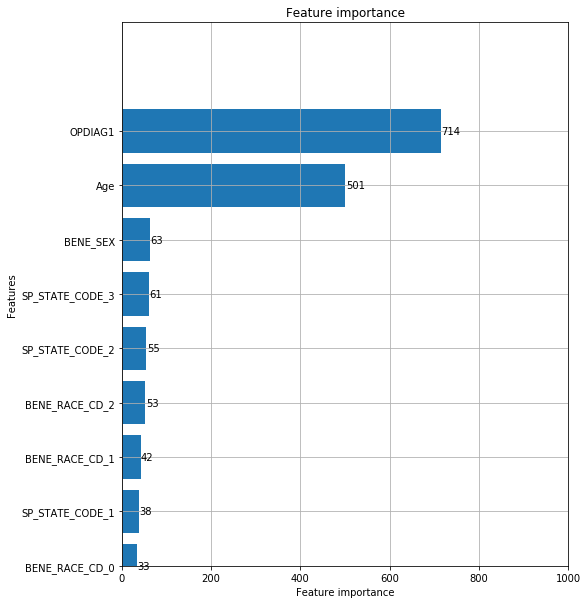

In [177]:
#Dimensionality reduction using feature importances
#features importance graph
ax = lgb.plot_importance(gbm, height = 0.8, 
                         max_num_features = 10,
                         ylabel='Features',
                         xlim = (0,1000), ylim = (0,10), 
                         figsize = (8,10))
plt.show()

Confusion matrix:
 [[21283 13766]
 [16962 17788]]


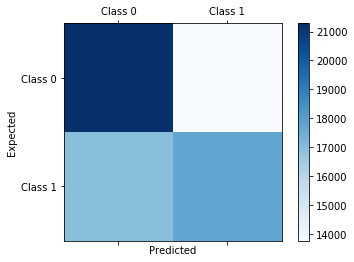

In [164]:
#Making predictions on the Test Set
y_pred = gbm.predict(X_test)

#Evaluating the predictions using a Confusion Matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [179]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('recall: {0:0.2f}'.format(recall))
print('precision: {0:0.2f}'.format(precision))

The accuracy of prediction is: 0.5597644665396352
The roc_auc_score of prediction is: 0.5595602382768954
The null acccuracy is: 0.502141864496626
recall: 0.51
precision: 0.56
